In [1875]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
from datetime import date, datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest

In [1876]:
os.getcwd()

'/Users/eleonoracocciu/Desktop/Unipi/Data Mining Advanced/fma_metadata'

In [1877]:
def tab_missing_values(df):
    FeatureMissValcount = 0
    table_ord = []
    table_ord_def = []
    tot = df.shape[0]
    headers = ["Feature", "Number of missing values", "Percentage", "Present values"]
    
    for i, value in (df.isna().sum().items()):
        if value!=0:
            FeatureMissValcount+=1
            tup = (value, tot)
            table_ord.append((i, (value, tot)))
        
    for element in sorted(table_ord, key=lambda tup:(-tup[1][0], tup[0])):
        percentage = (element[1][0] / element[1][1]) * 100
        percentage = "%.2f %%" %(percentage)
        difference = element[1][1] - element[1][0]
        new_tup = ' / '.join(map(str, (element[1])))
        table_ord_def.append((element[0], new_tup, percentage, difference))
    
    return table_ord_def, headers, FeatureMissValcount

In [1878]:
def count_zeros(df):
    tab = []
    headers = ["Features", "Zero values"]
    count = 0

    for column in df.columns:
        count_zeros = (df[column] == 0).sum()
        if count_zeros > 0:
            tab.append((column, count_zeros))
            count+=1
    
    return tab, headers, count

In [1879]:
def plot_radar_plot(df, categories, target_class, title, cmap):
    
    num_vars = len(categories)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar = True))

    classes = df[target_class].dropna().unique().tolist()
    
    num = 0
    
    if cmap:
        #palette = plt.get_cmap('Accent')
        palette = ['#0091C2', '#002EB8', '#CC0066', '#FF9124', '#668CFF', '#66CCFF', '#CCCC00', '#FFFF24', '#CC6600', 
          '#FF61B0', '#B061FF', '#CC6699', '#336600', '#52A300', '#70E000', '#99CC00']
        #palette = ['#CC6699','#CC0066', '#FF9124', '#CCCC00']
        
    else:
        palette = ['#CC0066', '#FF9124', '#CCCC00']
        
    
    for i, element in enumerate(classes):
        color = palette[num]
        num+=1
        dfc = df[df[target_class] == element]
        for index, row in dfc.iterrows():
            #val = add_to_radar(dfc, index, color, element)
            val = dfc.loc[index].drop(target_class).values.flatten().tolist()
            val += val[:1]
            ax.plot(angles, val, color= color, linewidth=1, label = element)

    #ax.legend()
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys(), loc='upper right', bbox_to_anchor=(1.9, 1), title=title, frameon=True, fontsize = 12)


    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), categories)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for category, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            category.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            category.set_horizontalalignment('left')
        else:
            category.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)

    # Add some custom styling.
    
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

    # Add title.
    ax.set_title("Comparing Track's Genre Across Dimensions", y=1.08, fontsize = 16)
    
    plt.show()

In [1880]:
def plot_distributions(df, target_col, more):
    
    if more:
        colors = ['#0091C2', '#002EB8', '#CC0066', '#FF9124', '#668CFF', '#66CCFF', '#CCCC00', '#FFFF24', '#CC6600', 
          '#FF61B0', '#B061FF', '#CC6699', '#336600', '#52A300', '#70E000', '#99CC00']
        #colors = ['#CC6699', '#CC0066', '#FF9124', '#CCCC00']
        
    else: 
        colors = ['#CC0066', '#FF9124', '#CCCC00']
        
        
    for column in df.columns:
    
        if ((column != target_col) & (column != 'artist_active_year_begin') & (column != 'album_year_created')):

            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
            ditrib_list = []
            list_element = []

            for element in df[target_col].dropna().unique():
                ditrib_list.append(df[df[target_col] == element][column])  #distribution
                list_element.append('%s' % element)                 #genre

            ax.hist(ditrib_list, label = list_element, color = colors)
            ax.legend(loc='upper right', title = "Track's genre", frameon=True, fontsize = 12)
            ax.set_title(column + " histogram", fontsize = 16)
            
            if (column == 'track_duration'):
                ax.xaxis.set_major_locator(MultipleLocator(500))
                ax.xaxis.set_minor_locator(MultipleLocator(100))
                ax.tick_params(which='major', length=7)
                ax.tick_params(which='minor', length=4, color='r')

            plt.show()

In [1881]:
def get_season(date_time):
    
    s = np.nan
    leap_year = 2000
    seasons = [('winter', (date(leap_year, 1, 1), date(leap_year, 3, 20))),
               ('spring', (date(leap_year, 3, 21), date(leap_year, 6, 20))),
               ('summer', (date(leap_year, 6, 21), date(leap_year, 9, 22))),
               ('autumn', (date(leap_year, 9, 23), date(leap_year, 12, 20))),
               ('winter', (date(leap_year, 12, 21), date(leap_year, 12, 31)))]
    
    if isinstance(date_time, datetime):
        date_time = date_time.date()

    date_time = date_time.replace(year=leap_year)

    for (season, (start, end)) in seasons:
        if (start <= date_time <= end):
            s = season
            
    return s

In [1882]:
def compare_years(df, col1, col2):
    
    released = 0
    created = 0
    both_zero = 0
    one_zero = 0
    
    for i, row in enumerate(df[col1]):
        
        idx_col1 = df.columns.get_loc(col1)
        idx_col2 = df.columns.get_loc(col2)
        
        if not((pd.isnull(df.iloc[i, idx_col1])) and not (pd.isnull(df.iloc[i, idx_col2]))):
            
            if ((df.iloc[i, idx_col1] != 0) and (df.iloc[i, idx_col2] != 0)):
                a1 = df.iloc[i, idx_col1]
                a2 = df.iloc[i, idx_col2]
                
                if (a2 < a1):  #se l'anno di rilascio è precedente a quello di creazione
                    released+=1
                elif (a1 <= a2):  #se l'anno di creazione è precedente o uguale a quello di rilascio
                    created+=1
                    
            elif ((df.iloc[i, idx_col1] == 0) and (df.iloc[i, idx_col2] == 0)):
                both_zero+=1
                
            else:
                one_zero+=1
                    
    return released, created, both_zero, one_zero

In [1883]:
def normalize_df(df_uff):
    #we create a copy of the dataset
    df = df_uff.copy()
    
    #we create a column that contains track's genre top values
    class_column = list(df["track_genre_top"].values)
    
    #we get the index of a column to reinsert track's genre top values
    new_column_idx = df.columns.get_loc('track_duration')+1
    
    #we delete track's genre top column
    del df["track_genre_top"]
    
    #we normalize the dataset
    x = df.values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    new_df = pd.DataFrame(x_scaled, columns = df.columns)
    
    #we reinsert track's genre top column
    new_df.insert(new_column_idx, 'track_genre_top', class_column)
    
    return new_df

In [1884]:
def hasNumbers(inputString):
    for i, char in enumerate(inputString):
        if char.isdigit():
            inputString = inputString.replace(char, "")
    return inputString

In [1885]:
def plot_correlation_matrix(correlation_matrix, title):
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(40, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(5.3, 120.8, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.15, cbar_kws={"shrink": .5})
    
    plt.title(title, fontsize = 20)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

<h1>Tracks dataset</h1>

In [1887]:
df_tracks = pd.read_csv("tracks.csv")

In [1888]:
df_tracks.head()

,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


We rename the columns of the dataset because there are two rows at the beginning, one for the category (<b>album</b>, <b>track</b>, <b>set</b> and <b>artist</b>) and one for the relative feature. 
So we add the name of category to each relative feature, so that we can drop the first tho rows without loosing information with respect to the category.

In [1889]:
for i, column in enumerate (df_tracks.columns):
    col = ''.join([i for i in column if not i.isdigit()])
    if col[-1] == ".":
        col = col.replace(".", "_")
    else :
        col = col+"_"
    #print (i, " ", col + str(df_tracks.iloc[0][column]))
    col = col + str(df_tracks.iloc[0][column])
    df_tracks = df_tracks.rename({column: col}, axis = 1)

In [1890]:
df_tracks

,Unnamed: _nan,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106571,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106572,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106573,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106574,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


In [1891]:
new_name = df_tracks.iloc[1]['Unnamed: _nan']
df_tracks = df_tracks.rename({'Unnamed: _nan': new_name}, axis = 1)

df_tracks

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106571,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106572,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106573,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106574,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


In [1892]:
df_tracks = df_tracks.iloc[2:]

In [1893]:
df_tracks

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106571,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106572,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106573,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106574,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


Since we eliminated two rows, we need to reset indexes.

In [1894]:
df_tracks = df_tracks.reset_index(drop=True)

In [1895]:
df_tracks

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


In [1896]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   track_id                  106574 non-null  object
 1   album_comments            106574 non-null  object
 2   album_date_created        103045 non-null  object
 3   album_date_released       70294 non-null   object
 4   album_engineer            15295 non-null   object
 5   album_favorites           106574 non-null  object
 6   album_id                  106574 non-null  object
 7   album_information         83149 non-null   object
 8   album_listens             106574 non-null  object
 9   album_producer            18060 non-null   object
 10  album_tags                106574 non-null  object
 11  album_title               105549 non-null  object
 12  album_tracks              106574 non-null  object
 13  album_type                100066 non-null  object
 14  arti

In [1897]:
tab, headers, miss_val = tab_missing_values(df_tracks)

print(tabulate(tab, headers, tablefmt = "simple", colalign = ("left", "right", "right")))

print()
print("{} features with missing values".format(miss_val))

Feature                     Number of missing values    Percentage    Present values
------------------------  --------------------------  ------------  ----------------
track_lyricist                       106263 / 106574       99.71 %               311
track_publisher                      105311 / 106574       98.81 %              1263
track_information                    104225 / 106574       97.80 %              2349
track_composer                       102904 / 106574       96.56 %              3670
artist_active_year_end               101199 / 106574       94.96 %              5375
artist_wikipedia_page                100993 / 106574       94.76 %              5581
track_date_recorded                  100415 / 106574       94.22 %              6159
artist_related_projects               93422 / 106574       87.66 %             13152
artist_associated_labels              92303 / 106574       86.61 %             14271
track_language_code                   91550 / 106574       85.90 

<b>We create a new column which contains years of creation and release of albums</b>

In [1942]:
tracks = df_tracks.copy()

In [1943]:
tracks

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


In [657]:
#dates = tracks['album_date_created'].fillna(0).astype(str)

In [1944]:
dates = tracks['album_date_created'].astype(str)
tracks['album_date_created'] = dates.apply(lambda x: x.split()[0])
tracks['album_year_created'] = pd.DatetimeIndex(tracks['album_date_created']).year.fillna(0.0).astype(int)

In [1945]:
dates = tracks['album_date_released'].astype(str)
tracks['album_date_released'] = dates.apply(lambda x: x.split()[0])
tracks['album_year_released'] = pd.DatetimeIndex(tracks['album_date_released']).year.fillna(0.0).astype(int)

In [1946]:
dates = tracks['track_date_created'].astype(str)
tracks['track_date_created'] = dates.apply(lambda x: x.split()[0])
tracks['track_year_created'] = pd.DatetimeIndex(tracks['track_date_created']).year.fillna(0.0).astype(int)

In [1947]:
date_columns = ['artist_active_year_begin', 'artist_date_created']

In [1948]:
for column in date_columns:
    dates = tracks[column].astype(str)
    tracks[column] = dates.apply(lambda x: x.split()[0])
    tracks[column] = pd.DatetimeIndex(tracks[column]).year.fillna(0.0).astype(int)

In [1949]:
tracks

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title,album_year_created,album_year_released,track_year_created
0,2,0,2008-11-26,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food,2008,2009,2008
1,3,0,2008-11-26,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave,2008,2009,2008
2,5,0,2008-11-26,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World,2008,2009,2008
3,10,0,2008-11-26,2008-02-06,NaN,4,6,NaN,47632,NaN,...,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway,2008,2008,2008
4,20,0,2008-11-26,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level,2008,2009,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30,2017-02-17,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger,2017,2017,2017
106570,155317,0,2017-03-30,2017-02-17,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby,2017,2017,2017
106571,155318,0,2017-03-30,2017-02-17,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp,2017,2017,2017
106572,155319,0,2017-03-30,2017-02-17,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths,2017,2017,2017


In [1950]:
tab, headers, miss_val = tab_missing_values(tracks)

print(tabulate(tab, headers, tablefmt = "simple", colalign = ("left", "right", "right")))

print()
print("{} features with missing values".format(miss_val))

Feature                     Number of missing values    Percentage    Present values
------------------------  --------------------------  ------------  ----------------
track_lyricist                       106263 / 106574       99.71 %               311
track_publisher                      105311 / 106574       98.81 %              1263
track_information                    104225 / 106574       97.80 %              2349
track_composer                       102904 / 106574       96.56 %              3670
artist_active_year_end               101199 / 106574       94.96 %              5375
artist_wikipedia_page                100993 / 106574       94.76 %              5581
track_date_recorded                  100415 / 106574       94.22 %              6159
artist_related_projects               93422 / 106574       87.66 %             13152
artist_associated_labels              92303 / 106574       86.61 %             14271
track_language_code                   91550 / 106574       85.90 

In [1951]:
for element in tab[:13]:
    column = element[0]
    if column != 'artist_active_year_begin':
        tracks = tracks.drop(column, axis = 1)

In [1952]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   track_id                  106574 non-null  object
 1   album_comments            106574 non-null  object
 2   album_date_created        106574 non-null  object
 3   album_date_released       106574 non-null  object
 4   album_favorites           106574 non-null  object
 5   album_id                  106574 non-null  object
 6   album_information         83149 non-null   object
 7   album_listens             106574 non-null  object
 8   album_tags                106574 non-null  object
 9   album_title               105549 non-null  object
 10  album_tracks              106574 non-null  object
 11  album_type                100066 non-null  object
 12  artist_active_year_begin  106574 non-null  int64 
 13  artist_bio                71156 non-null   object
 14  arti

In [1953]:
features_to_drop = ["album_comments", "album_favorites", "album_information", "album_title",
 "artist_bio", "artist_comments", "album_tags", "track_tags",
 "artist_longitude", "artist_members", "artist_name", "artist_tags", "artist_website", "track_comments",
 "track_favorites", "track_interest", "track_license", "track_title", "album_date_created", "album_date_released"]

In [1954]:
for column in features_to_drop:
    tracks = tracks.drop(column, axis = 1)

In [1955]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   track_id                  106574 non-null  object
 1   album_id                  106574 non-null  object
 2   album_listens             106574 non-null  object
 3   album_tracks              106574 non-null  object
 4   album_type                100066 non-null  object
 5   artist_active_year_begin  106574 non-null  int64 
 6   artist_date_created       106574 non-null  int64 
 7   artist_favorites          106574 non-null  object
 8   artist_id                 106574 non-null  object
 9   artist_location           70210 non-null   object
 10  set_split                 106574 non-null  object
 11  set_subset                106574 non-null  object
 12  track_bit_rate            106574 non-null  object
 13  track_date_created        106574 non-null  object
 14  trac

In [1956]:
tracks

,track_id,album_id,album_listens,album_tracks,album_type,artist_active_year_begin,artist_date_created,artist_favorites,artist_id,artist_location,...,track_date_created,track_duration,track_genre_top,track_genres,track_genres_all,track_listens,track_number,album_year_created,album_year_released,track_year_created
0,2,1,6073,7,Album,2006,2008,9,1,New Jersey,...,2008-11-26,168,Hip-Hop,[21],[21],1293,3,2008,2009,2008
1,3,1,6073,7,Album,2006,2008,9,1,New Jersey,...,2008-11-26,237,Hip-Hop,[21],[21],514,4,2008,2009,2008
2,5,1,6073,7,Album,2006,2008,9,1,New Jersey,...,2008-11-26,206,Hip-Hop,[21],[21],1151,6,2008,2009,2008
3,10,6,47632,2,Album,0,2008,74,6,NaN,...,2008-11-25,161,Pop,[10],[10],50135,1,2008,2008,2008
4,20,4,2710,13,Album,1990,2008,10,4,Colchester England,...,2008-11-26,311,NaN,"[76, 103]","[17, 10, 76, 103]",361,3,2008,2009,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,2017-03-30,162,Rock,[25],"[25, 12]",102,3,2017,2017,2017
106570,155317,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,2017-03-30,217,Rock,[25],"[25, 12]",165,4,2017,2017,2017
106571,155318,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,2017-03-30,404,Rock,[25],"[25, 12]",168,6,2017,2017,2017
106572,155319,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,2017-03-30,146,Rock,[25],"[25, 12]",294,5,2017,2017,2017


<b>We verify if there are duplicates</b>

In [1957]:
tracks.duplicated().any()

False

In [1958]:
#tracks['album_date_created'] = pd.to_datetime(tracks['album_date_created'])
#tracks['album_date_released'] = pd.to_datetime(tracks['album_date_released'])
tracks['track_date_created'] = pd.to_datetime(tracks['track_date_created'])

<b>We create the new column with season</b>

In [1959]:
tracks['season_track_created'] = tracks['track_date_created'].apply(lambda x: get_season(x))

In [1960]:
tracks

,track_id,album_id,album_listens,album_tracks,album_type,artist_active_year_begin,artist_date_created,artist_favorites,artist_id,artist_location,...,track_duration,track_genre_top,track_genres,track_genres_all,track_listens,track_number,album_year_created,album_year_released,track_year_created,season_track_created
0,2,1,6073,7,Album,2006,2008,9,1,New Jersey,...,168,Hip-Hop,[21],[21],1293,3,2008,2009,2008,autumn
1,3,1,6073,7,Album,2006,2008,9,1,New Jersey,...,237,Hip-Hop,[21],[21],514,4,2008,2009,2008,autumn
2,5,1,6073,7,Album,2006,2008,9,1,New Jersey,...,206,Hip-Hop,[21],[21],1151,6,2008,2009,2008,autumn
3,10,6,47632,2,Album,0,2008,74,6,NaN,...,161,Pop,[10],[10],50135,1,2008,2008,2008,autumn
4,20,4,2710,13,Album,1990,2008,10,4,Colchester England,...,311,NaN,"[76, 103]","[17, 10, 76, 103]",361,3,2008,2009,2008,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,162,Rock,[25],"[25, 12]",102,3,2017,2017,2017,spring
106570,155317,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,217,Rock,[25],"[25, 12]",165,4,2017,2017,2017,spring
106571,155318,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,404,Rock,[25],"[25, 12]",168,6,2017,2017,2017,spring
106572,155319,22940,1506,6,Live Performance,0,2017,0,24357,New Jersey,...,146,Rock,[25],"[25, 12]",294,5,2017,2017,2017,spring


In [1961]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   track_id                  106574 non-null  object        
 1   album_id                  106574 non-null  object        
 2   album_listens             106574 non-null  object        
 3   album_tracks              106574 non-null  object        
 4   album_type                100066 non-null  object        
 5   artist_active_year_begin  106574 non-null  int64         
 6   artist_date_created       106574 non-null  int64         
 7   artist_favorites          106574 non-null  object        
 8   artist_id                 106574 non-null  object        
 9   artist_location           70210 non-null   object        
 10  set_split                 106574 non-null  object        
 11  set_subset                106574 non-null  object        
 12  tr

<h3>Comparisons</h3>

<b>Album year created - Album year released</b>

In [1962]:
released, created, both_zero, one_zero = compare_years(tracks, 'album_year_created', 'album_year_released')

print("{0:45} {1}".format("anno_rilascio_album < anno_creazione_album: ", released))
print()
print("{0:39} {1}".format("anno_creazione_album <= anno_rilascio_album: ", created))
print()
print("{0:45} {1}".format("entrambi zero: ", both_zero))
print()
print("{0:45} {1}".format("solo uno zero: ", one_zero))
print()
print("{0:45} {1}".format("somma: ", released + created + both_zero + one_zero))

anno_rilascio_album < anno_creazione_album:   26500

anno_creazione_album <= anno_rilascio_album:  43794

entrambi zero:                                3529

solo uno zero:                                32751

somma:                                        106574


In [1963]:
no_zero = tracks['album_year_released'].to_numpy().nonzero()
df_no_zero = tracks.loc[no_zero]
df_no_zero = df_no_zero[(df_no_zero['album_year_released'] < df_no_zero['album_year_created'])]

In [1964]:
df_no_zero[['album_year_released', 'album_year_created']]

,album_year_released,album_year_created
12,2006,2008
13,2006,2008
15,2007,2008
17,2005,2008
20,1995,2008
...,...,...
106296,2016,2017
106297,2016,2017
106298,2016,2017
106299,2016,2017


<b>Artist active year begin - Artist date created</b>

In [1965]:
creation_artist, year_begin_activity, both_zero, one_zero = compare_years(tracks, 'artist_active_year_begin', 'artist_date_created')


print("{0:56} {1}".format("anno_creazione_artista < anno_inizio_attività_artista: ", creation_artist))
print()
print("{0:50} {1}".format("anno_inizio_attività_artista <= anno_creazione_artista: ", year_begin_activity))
print()
print("{0:56} {1}".format("entrambi zero: ", both_zero))
print()
print("{0:56} {1}".format("solo uno zero: ", one_zero))
print()
print("{0:56} {1}".format("somma: ", creation_artist + year_begin_activity + both_zero + one_zero))

anno_creazione_artista < anno_inizio_attività_artista:   0

anno_inizio_attività_artista <= anno_creazione_artista:  22711

entrambi zero:                                           856

solo uno zero:                                           83007

somma:                                                   106574


<b>Artist active year begin - Track year created</b>

In [1967]:
creation_track, year_begin_activity, both_zero, one_zero = compare_years(tracks, 'artist_active_year_begin', 'track_year_created')


print("{0:56} {1}".format("anno_creazione_traccia < anno_inizio_attività_artista: ", creation_track))
print()
print("{0:50} {1}".format("anno_inizio_attività_artista <= anno_creazione_traccia: ", year_begin_activity))
print()
print("{0:56} {1}".format("entrambi zero: ", both_zero))
print()
print("{0:56} {1}".format("solo uno zero: ", one_zero))
print()
print("{0:56} {1}".format("somma: ", creation_track + year_begin_activity + both_zero + one_zero))

anno_creazione_traccia < anno_inizio_attività_artista:   0

anno_inizio_attività_artista <= anno_creazione_traccia:  22711

entrambi zero:                                           0

solo uno zero:                                           83863

somma:                                                   106574


<b>Artist active year begin - Album year released</b>

In [1968]:
released, year_begin_activity, both_zero, one_zero = compare_years(tracks, 'artist_active_year_begin', 'album_year_released')

print("{0:56} {1}".format("anno_rilascio_album < anno_inizio_attività_artista: ", released))
print()
print("{0:56} {1}".format("anno_inizio_attività_artista <= anno_rilascio_album: ", year_begin_activity))
print()
print("{0:56} {1}".format("entrambi zero: ", both_zero))
print()
print("{0:56} {1}".format("solo uno zero: ", one_zero))
print()
print("{0:56} {1}".format("somma: ", released + year_begin_activity + both_zero + one_zero))

anno_rilascio_album < anno_inizio_attività_artista:      36

anno_inizio_attività_artista <= anno_rilascio_album:     13989

entrambi zero:                                           27594

solo uno zero:                                           64955

somma:                                                   106574


In [1969]:
no_zero = tracks['album_year_released'].to_numpy().nonzero()
df_no_zero = tracks.loc[no_zero]
df_no_zero = df_no_zero[(df_no_zero['album_year_released'] < df_no_zero['artist_active_year_begin'])]

In [1970]:
df_no_zero[['album_year_released', 'artist_active_year_begin']].head()

,album_year_released,artist_active_year_begin
7539,2001,2002
7540,2001,2002
7541,2001,2002
7542,2001,2002
7543,2001,2002


In [1971]:
df_no_zero.shape[0]

36

<b>Artist active year begin - Album year created</b>

In [1972]:
created, year_begin_activity, both_zero, one_zero = compare_years(tracks, 'artist_active_year_begin', 'album_year_created')

print("{0:56} {1}".format("anno_creazione_album < anno_inizio_attività_artista: ", created))
print()
print("{0:56} {1}".format("anno_inizio_attività_artista <= anno_creazione_album: ", year_begin_activity))
print()
print("{0:56} {1}".format("entrambi zero: ", both_zero))
print()
print("{0:56} {1}".format("solo uno zero: ", one_zero))
print()
print("{0:56} {1}".format("somma: ", created + year_begin_activity + both_zero + one_zero))

anno_creazione_album < anno_inizio_attività_artista:     0

anno_inizio_attività_artista <= anno_creazione_album:    21634

entrambi zero:                                           2452

solo uno zero:                                           82488

somma:                                                   106574


In [1973]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   track_id                  106574 non-null  object        
 1   album_id                  106574 non-null  object        
 2   album_listens             106574 non-null  object        
 3   album_tracks              106574 non-null  object        
 4   album_type                100066 non-null  object        
 5   artist_active_year_begin  106574 non-null  int64         
 6   artist_date_created       106574 non-null  int64         
 7   artist_favorites          106574 non-null  object        
 8   artist_id                 106574 non-null  object        
 9   artist_location           70210 non-null   object        
 10  set_split                 106574 non-null  object        
 11  set_subset                106574 non-null  object        
 12  tr

In [1974]:
del tracks['artist_active_year_begin']
del tracks['artist_date_created']
del tracks['track_date_created']
del tracks['album_year_created']
del tracks['album_year_released']

In [1975]:
tracks

,track_id,album_id,album_listens,album_tracks,album_type,artist_favorites,artist_id,artist_location,set_split,set_subset,track_bit_rate,track_duration,track_genre_top,track_genres,track_genres_all,track_listens,track_number,track_year_created,season_track_created
0,2,1,6073,7,Album,9,1,New Jersey,training,small,256000,168,Hip-Hop,[21],[21],1293,3,2008,autumn
1,3,1,6073,7,Album,9,1,New Jersey,training,medium,256000,237,Hip-Hop,[21],[21],514,4,2008,autumn
2,5,1,6073,7,Album,9,1,New Jersey,training,small,256000,206,Hip-Hop,[21],[21],1151,6,2008,autumn
3,10,6,47632,2,Album,74,6,NaN,training,small,192000,161,Pop,[10],[10],50135,1,2008,autumn
4,20,4,2710,13,Album,10,4,Colchester England,training,large,256000,311,NaN,"[76, 103]","[17, 10, 76, 103]",361,3,2008,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,22940,1506,6,Live Performance,0,24357,New Jersey,training,large,320000,162,Rock,[25],"[25, 12]",102,3,2017,spring
106570,155317,22940,1506,6,Live Performance,0,24357,New Jersey,training,large,320000,217,Rock,[25],"[25, 12]",165,4,2017,spring
106571,155318,22940,1506,6,Live Performance,0,24357,New Jersey,training,large,320000,404,Rock,[25],"[25, 12]",168,6,2017,spring
106572,155319,22940,1506,6,Live Performance,0,24357,New Jersey,training,large,320000,146,Rock,[25],"[25, 12]",294,5,2017,spring


<h4>Unique values</h4>

In [1976]:
some_unique_values = []
headers = ["Features with zero values", "Num", "Unique values"]
uniques = {}

for column in tracks.columns:
    unique = tracks[column].unique()
    u = [str(i) for i in unique] 
    u = [i for i in u if i!= 'nan']
        
    if (column != 'track_year_created'):
        u = [i for i in u if i!= '0']
            
    unique = np.array(u)
    some_unique_values.append((column, len(u), unique))
    uniques[column] = unique
    
print(tabulate(some_unique_values, headers, tablefmt = "simple", numalign = ("left", "left", "right")))

Features with zero values       Num  Unique values
---------------------------  ------  --------------------------------------------------------------------------
track_id                     106574  ['2' '3' '5' ... '155318' '155319' '155320']
album_id                     14928   ['1' '6' '4' ... '22936' '22937' '22940']
album_listens                11350   ['6073' '47632' '2710' ... '4422' '6196' '1206']
album_tracks                 167     ['7' '2' '13' '4' '1' '15' '10' '3' '21' '9' '18' '5' '12' '8' '16' '6'
                                      '-1' '11' '22' '74' '14' '17' '24' '19' '20' '138' '25' '23' '27' '38'
                                      '155' '39' '31' '47' '40' '49' '33' '29' '28' '32' '35' '56' '92' '30'
                                      '36' '46' '43' '110' '91' '68' '26' '34' '51' '52' '59' '6' '1' '49' '7'
                                      '10' '2' '8' '-1' '31' '11' '9' '5' '19' '4' '92' '26' '3' '18' '52' '13'
                                      '1

<h4>Zero values</h4>

In [1977]:
tab, headers, count = count_zeros(tracks)

print(tabulate(tab, headers, tablefmt = "simple", colalign = ("left", "right")))
print()
print("{} columns with zero values".format(count))

Features            Zero values
----------------  -------------
album_tracks                 84
artist_favorites          15414
track_duration                4
track_listens                 1
track_number               5953

5 columns with zero values


In [1978]:
tracks[tracks['track_duration'] == 0]

,track_id,album_id,album_listens,album_tracks,album_type,artist_favorites,artist_id,artist_location,set_split,set_subset,track_bit_rate,track_duration,track_genre_top,track_genres,track_genres_all,track_listens,track_number,track_year_created,season_track_created
69817,106611,10938,42863,14,Single Tracks,112,12351,"Seville, Spain",test,large,128000,0,NaN,"[456, 659]","[456, 659, 5, 38]",5759,12,2014,spring
69818,106613,11260,131037,44,Single Tracks,112,12351,"Seville, Spain",test,large,128000,0,NaN,"[456, 659]","[456, 659, 5, 38]",7006,99,2014,spring
76074,114497,17509,325595,389,Album,0,19510,NaN,training,large,127706,0,Pop,[76],"[10, 76]",3072,106,2015,winter
93901,137686,20682,3887,1,Single Tracks,23,20655,Los Angeles,training,large,320000,0,Instrumental,"[18, 1235]","[18, 1235]",3889,1,2016,spring


<b>Let's check again features with missing values</b>

In [1979]:
tab, headers, miss_val = tab_missing_values(tracks)

print(tabulate(tab, headers, tablefmt = "simple", colalign = ("left", "right", "right")))

print()
print("{} features with missing values".format(miss_val))

Feature            Number of missing values    Percentage    Present values
---------------  --------------------------  ------------  ----------------
track_genre_top              56976 / 106574       53.46 %             49598
artist_location              36364 / 106574       34.12 %             70210
album_type                    6508 / 106574        6.11 %            100066

3 features with missing values


In [1980]:
del tracks['artist_location']
del tracks['album_type']

<b>We verify if there are columns which have a single value for all cells.</b>

In [1981]:
(tracks.nunique() == 1).any()

False

In [1982]:
tracks.shape

(106574, 17)

In [1983]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   track_id              106574 non-null  object
 1   album_id              106574 non-null  object
 2   album_listens         106574 non-null  object
 3   album_tracks          106574 non-null  object
 4   artist_favorites      106574 non-null  object
 5   artist_id             106574 non-null  object
 6   set_split             106574 non-null  object
 7   set_subset            106574 non-null  object
 8   track_bit_rate        106574 non-null  object
 9   track_duration        106574 non-null  object
 10  track_genre_top       49598 non-null   object
 11  track_genres          106574 non-null  object
 12  track_genres_all      106574 non-null  object
 13  track_listens         106574 non-null  object
 14  track_number          106574 non-null  object
 15  track_year_create

<b>We verify if there are rows which have all values equals to 'nan'</b>

In [1984]:
(tracks.isnull().values.all(axis=0)).any()

False

<b>We verify if there are columns which have all values equals to 'nan'</b>

In [1985]:
(tracks.isnull().values.all(axis=1)).any()

False

Text(0.5, 0.98, "Track's genre")

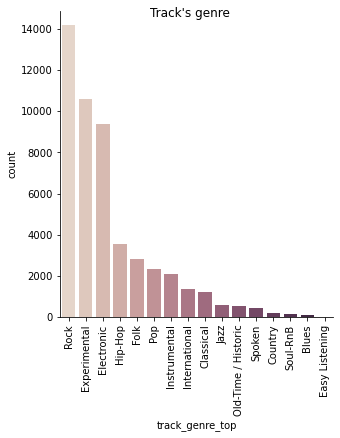

In [1986]:
ax = sns.catplot(x = "track_genre_top", data = tracks, kind = 'count', palette="ch:.15", order = tracks['track_genre_top'].value_counts().index)
ax.set_xticklabels(rotation=90)
ax.fig.suptitle("Track's genre")

In [1987]:
def number_of_elements(df, column, element):
    return df[df[column] == element].shape[0]

In [1988]:
print("{0:27} {1}".format("Tracks of Rock", number_of_elements(tracks, "track_genre_top", "Rock")))
print("{0:27} {1}".format("Tracks of Experimental", number_of_elements(tracks, "track_genre_top", "Experimental")))
print("{0:27} {1}".format("Tracks of Electronic", number_of_elements(tracks, "track_genre_top", "Electronic")))

Tracks of Rock              14182
Tracks of Experimental      10608
Tracks of Electronic        9372


<h3>TRACKS --> entire dataset</h3>

In [1989]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   track_id              106574 non-null  object
 1   album_id              106574 non-null  object
 2   album_listens         106574 non-null  object
 3   album_tracks          106574 non-null  object
 4   artist_favorites      106574 non-null  object
 5   artist_id             106574 non-null  object
 6   set_split             106574 non-null  object
 7   set_subset            106574 non-null  object
 8   track_bit_rate        106574 non-null  object
 9   track_duration        106574 non-null  object
 10  track_genre_top       49598 non-null   object
 11  track_genres          106574 non-null  object
 12  track_genres_all      106574 non-null  object
 13  track_listens         106574 non-null  object
 14  track_number          106574 non-null  object
 15  track_year_create

<h4>We create a copy of the original dataset</h4>

In [2015]:
tracks_all_genres = tracks.copy()

<h4>We create a dataset which contains only the three principal genres Rock, Experimental and Electronic</h4>

In [2016]:
tracks_3_genres = pd.DataFrame()
tracks_3_genres = tracks.loc[(tracks['track_genre_top'] == 'Rock') | 
                               (tracks['track_genre_top'] == 'Experimental') |
                              (tracks['track_genre_top'] == 'Electronic')]
tracks_3_genres

,track_id,album_id,album_listens,album_tracks,artist_favorites,artist_id,set_split,set_subset,track_bit_rate,track_duration,track_genre_top,track_genres,track_genres_all,track_listens,track_number,track_year_created,season_track_created
10,135,58,3331,4,0,52,training,large,256000,837,Rock,"[45, 58]","[58, 12, 45]",1832,0,2008,autumn
11,136,58,3331,4,0,52,training,medium,256000,509,Rock,"[45, 58]","[58, 12, 45]",1498,0,2008,autumn
12,137,59,1681,2,5,53,training,large,256000,1233,Experimental,"[1, 32]","[32, 1, 38]",1278,1,2008,autumn
13,138,59,1681,2,5,53,training,large,256000,1231,Experimental,"[1, 32]","[32, 1, 38]",489,2,2008,autumn
22,148,66,1831,1,0,57,validation,small,256000,138,Experimental,[1],"[1, 38]",1831,2,2008,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106568,155315,22940,1506,6,0,24357,training,large,320000,38,Rock,[25],"[25, 12]",128,1,2017,spring
106569,155316,22940,1506,6,0,24357,training,large,320000,162,Rock,[25],"[25, 12]",102,3,2017,spring
106570,155317,22940,1506,6,0,24357,training,large,320000,217,Rock,[25],"[25, 12]",165,4,2017,spring
106571,155318,22940,1506,6,0,24357,training,large,320000,404,Rock,[25],"[25, 12]",168,6,2017,spring


In [2017]:
#cols = ["track_year_created", "track_bit_rate", "track_duration", "artist_active_year_begin", "track_listens",
       # "artist_date_created", "track_date_created", "season_album_created"]

cols = ["track_year_created", "track_bit_rate", "track_duration", "season_track_created"]

<b>We drop all columns that are nonessential for both datasets</b>

In [2018]:
for column in tracks_3_genres.columns:
    if column != 'track_genre_top':
        if column not in cols:
            tracks_3_genres = tracks_3_genres.drop(column, axis =1)
        
tracks_3_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34162 entries, 10 to 106572
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_bit_rate        34162 non-null  object
 1   track_duration        34162 non-null  object
 2   track_genre_top       34162 non-null  object
 3   track_year_created    34162 non-null  int64 
 4   season_track_created  34162 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [2019]:
for column in tracks_all_genres.columns:
    if column != 'track_genre_top':
        if column not in cols:
            tracks_all_genres = tracks_all_genres.drop(column, axis =1)
        
tracks_all_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   track_bit_rate        106574 non-null  object
 1   track_duration        106574 non-null  object
 2   track_genre_top       49598 non-null   object
 3   track_year_created    106574 non-null  int64 
 4   season_track_created  106574 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.1+ MB


<b>We transform the season column with an ordinal encoding</b>

In [2020]:
season_dict = {
    'spring' : 1,
    'summer' : 2,
    'autumn' : 3,
    'winter' : 4,
} 

In [2021]:
tracks_3_genres['season_ordinal'] = tracks_3_genres.season_track_created.map(season_dict).fillna(0).astype(int)
tracks_all_genres['season_ordinal'] = tracks_all_genres.season_track_created.map(season_dict).fillna(0).astype(int)

In [2022]:
tracks_3_genres

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_track_created,season_ordinal
10,256000,837,Rock,2008,autumn,3
11,256000,509,Rock,2008,autumn,3
12,256000,1233,Experimental,2008,autumn,3
13,256000,1231,Experimental,2008,autumn,3
22,256000,138,Experimental,2008,autumn,3
...,...,...,...,...,...,...
106568,320000,38,Rock,2017,spring,1
106569,320000,162,Rock,2017,spring,1
106570,320000,217,Rock,2017,spring,1
106571,320000,404,Rock,2017,spring,1


In [2023]:
tracks_all_genres

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_track_created,season_ordinal
0,256000,168,Hip-Hop,2008,autumn,3
1,256000,237,Hip-Hop,2008,autumn,3
2,256000,206,Hip-Hop,2008,autumn,3
3,192000,161,Pop,2008,autumn,3
4,256000,311,NaN,2008,autumn,3
...,...,...,...,...,...,...
106569,320000,162,Rock,2017,spring,1
106570,320000,217,Rock,2017,spring,1
106571,320000,404,Rock,2017,spring,1
106572,320000,146,Rock,2017,spring,1


In [2024]:
tracks_3_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34162 entries, 10 to 106572
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_bit_rate        34162 non-null  object
 1   track_duration        34162 non-null  object
 2   track_genre_top       34162 non-null  object
 3   track_year_created    34162 non-null  int64 
 4   season_track_created  34162 non-null  object
 5   season_ordinal        34162 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


In [2025]:
del tracks_3_genres['season_track_created']
del tracks_all_genres['season_track_created']

<b>We convert the dtype of all columns except that of track's genre</b>

In [2026]:
object_columns = [i for i in tracks_3_genres.select_dtypes(include=['object']).columns if i != 'track_genre_top']
object_columns

['track_bit_rate', 'track_duration']

In [2027]:
datasets = [tracks_3_genres, tracks_all_genres]

for df in datasets:
    for column in df:
        if column in object_columns:
            df[column] = df[column].astype(int)

In [2028]:
tracks_3_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34162 entries, 10 to 106572
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_bit_rate      34162 non-null  int64 
 1   track_duration      34162 non-null  int64 
 2   track_genre_top     34162 non-null  object
 3   track_year_created  34162 non-null  int64 
 4   season_ordinal      34162 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


In [2029]:
tracks_all_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   track_bit_rate      106574 non-null  int64 
 1   track_duration      106574 non-null  int64 
 2   track_genre_top     49598 non-null   object
 3   track_year_created  106574 non-null  int64 
 4   season_ordinal      106574 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.1+ MB


<h3>Distributions</h3>

<h4>Distribution of the three main track's genres across variables</h4>

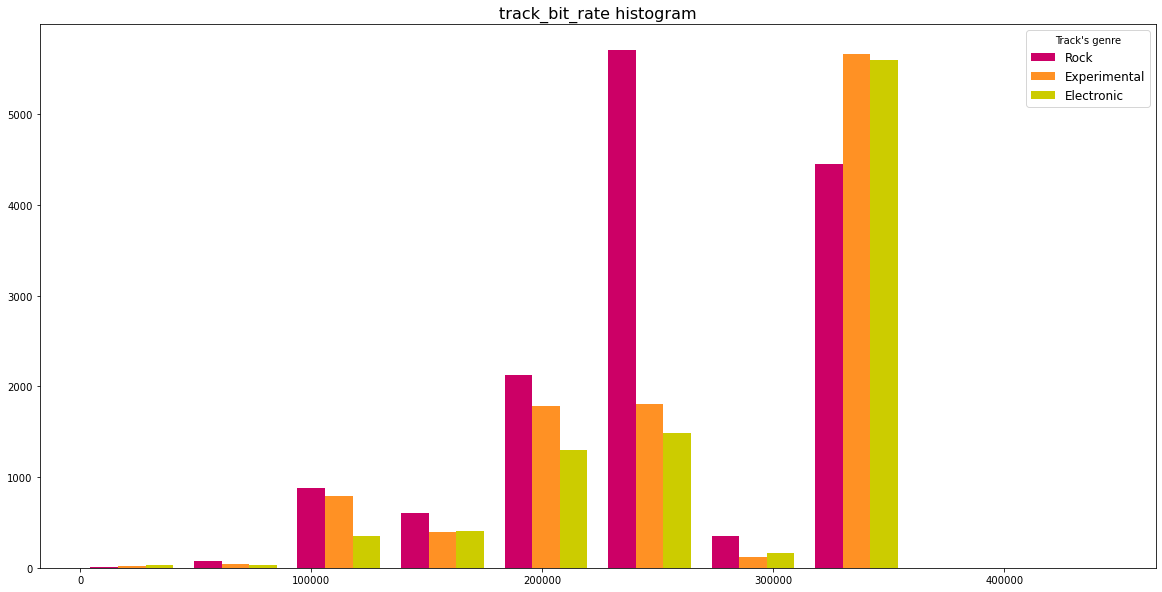

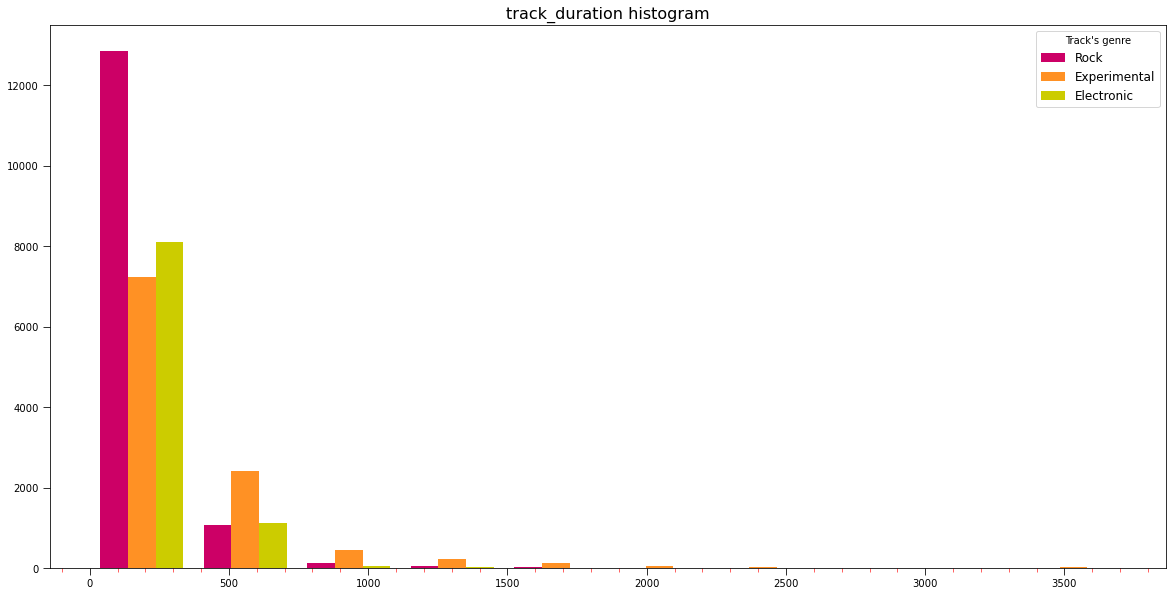

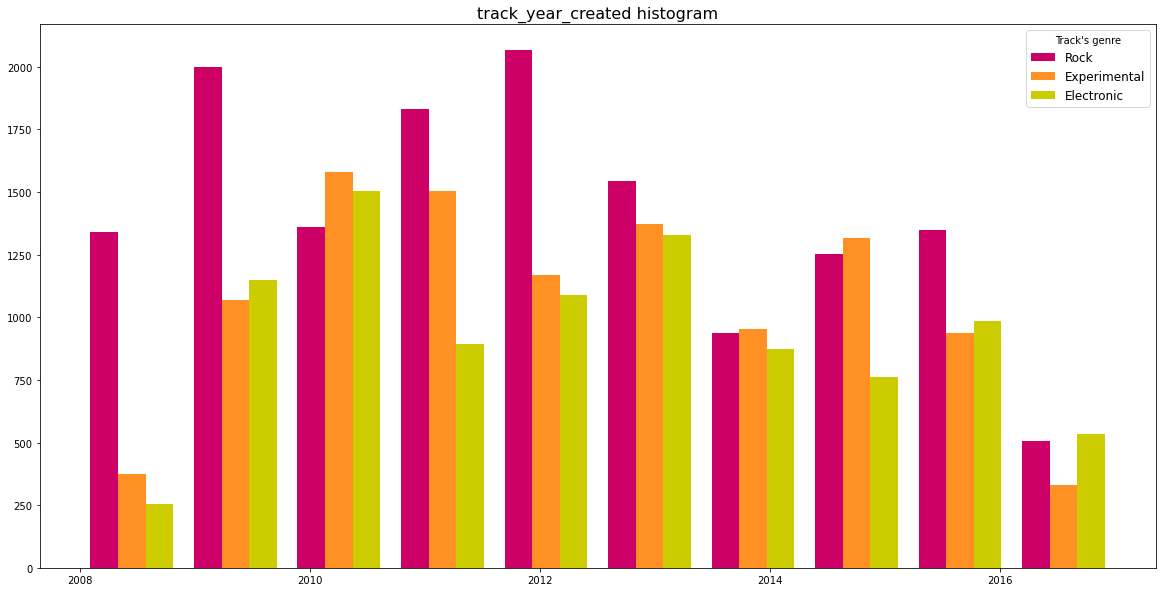

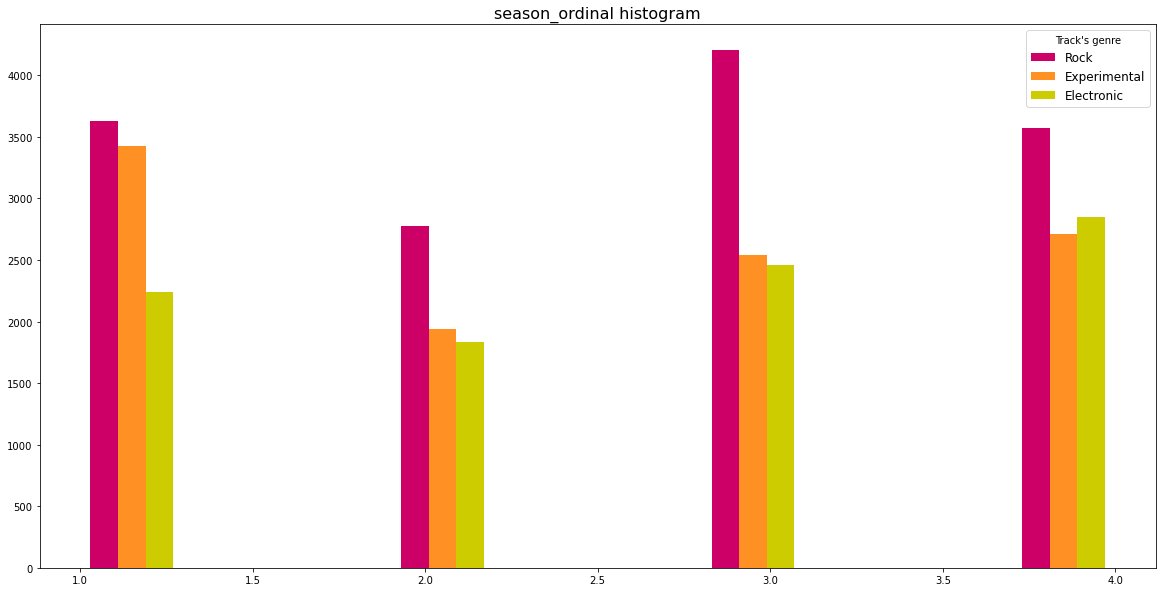

In [2031]:
plot_distributions(tracks_3_genres, 'track_genre_top', False)

<h4>Distribution of all track's genres across variables</h4>

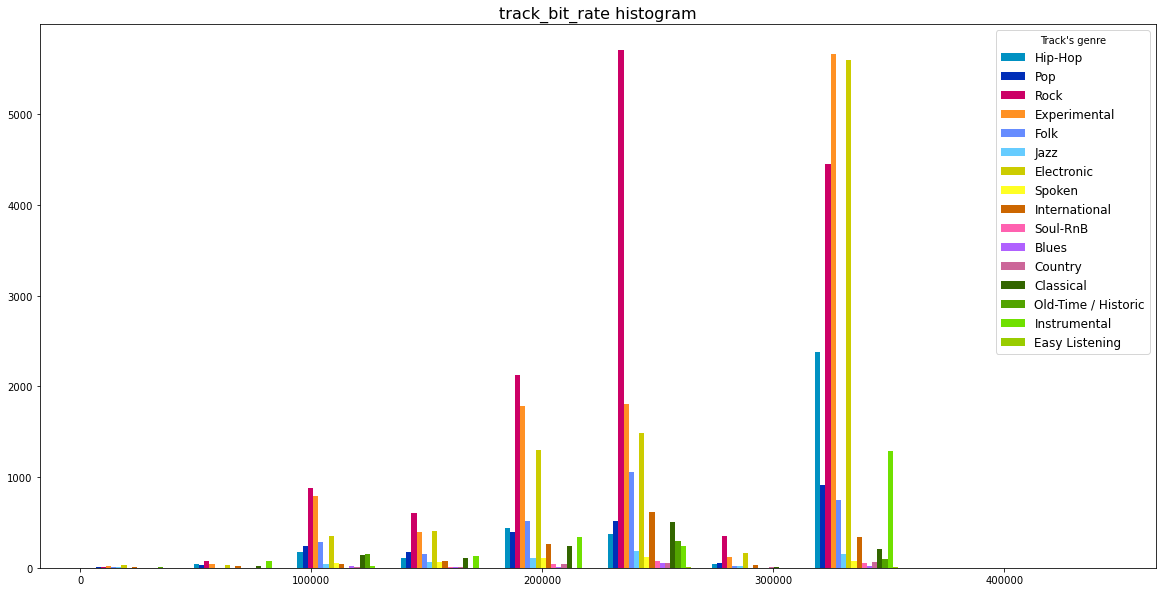

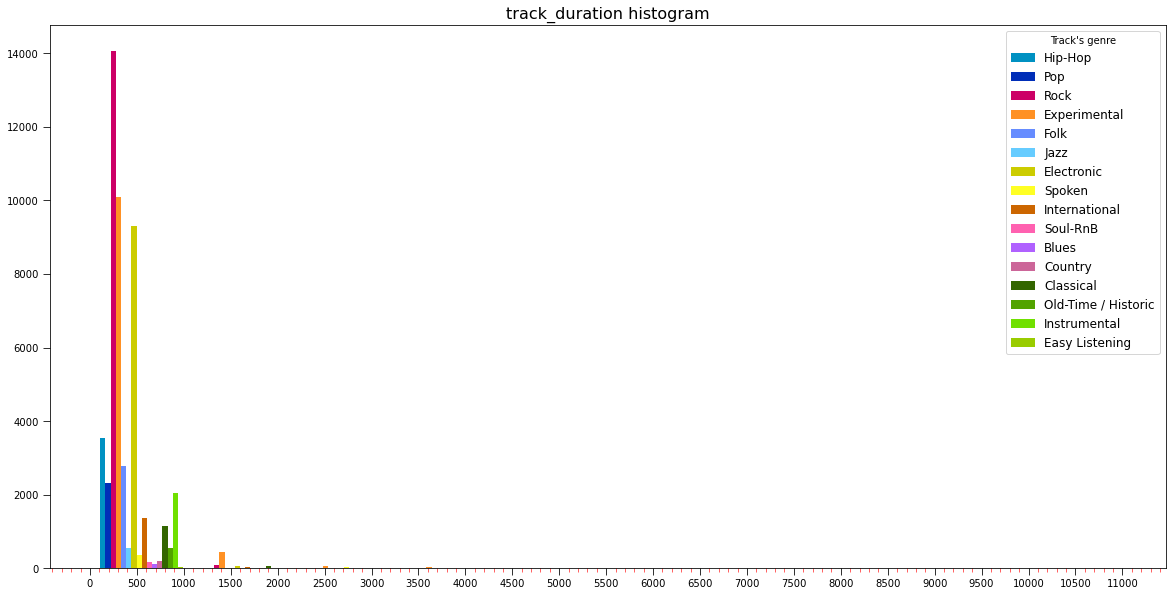

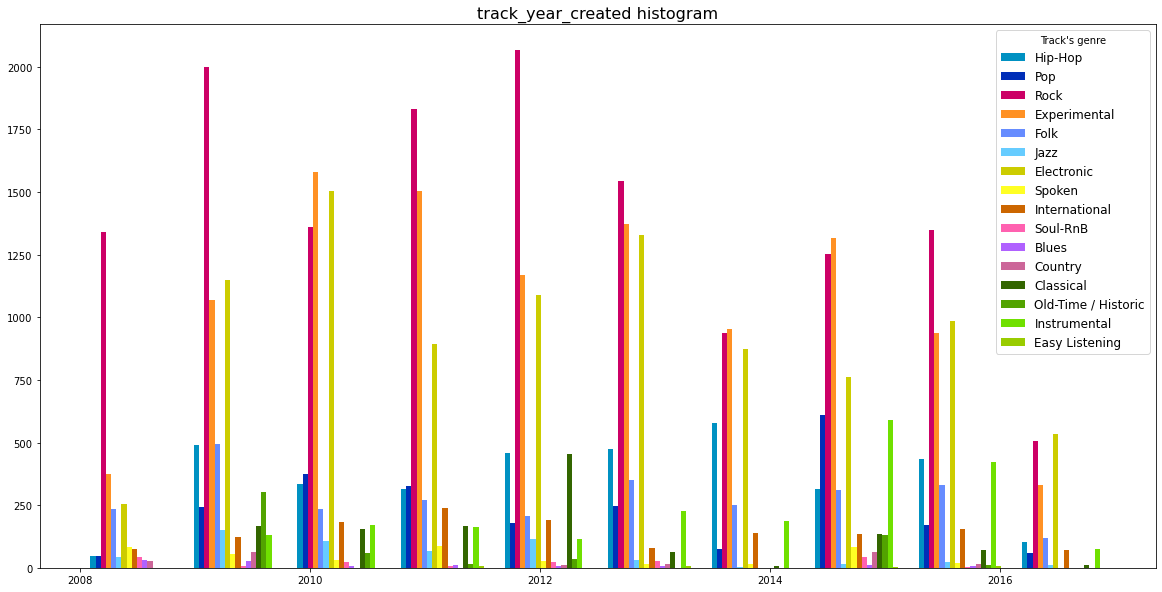

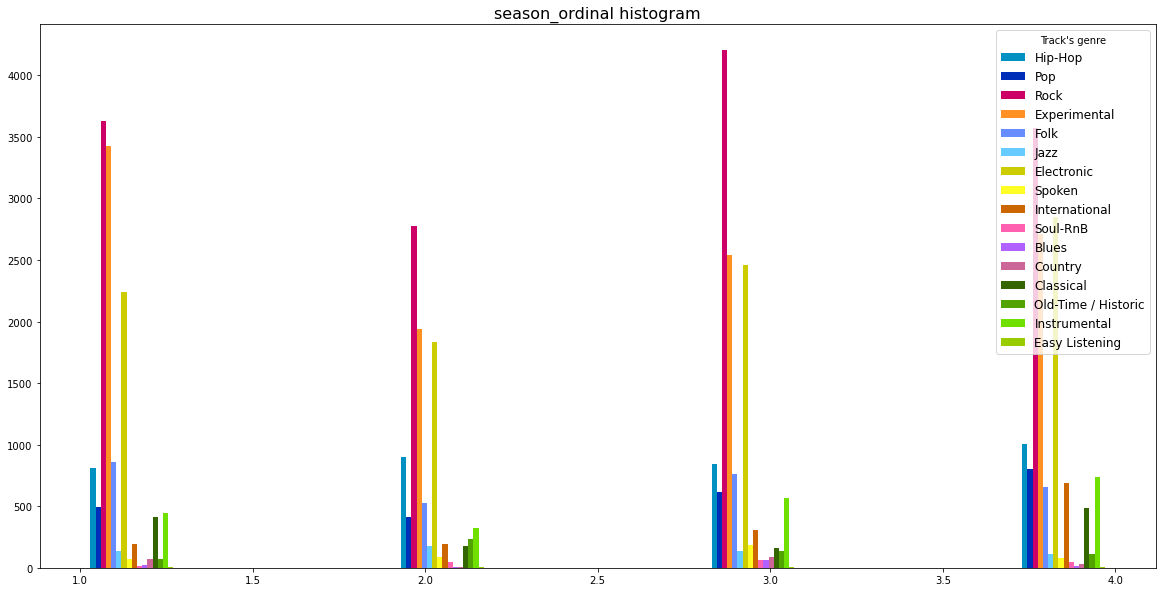

In [2032]:
plot_distributions(tracks_all_genres, 'track_genre_top', True)

<b>We maintain in this dataset only notna values, to realize a significative parallel coordinates plot</b>

In [2033]:
tracks_3_genres_full = tracks_3_genres
tracks_3_genres = tracks_3_genres[tracks_3_genres['track_genre_top'].notna()]
tracks_3_genres

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
10,256000,837,Rock,2008,3
11,256000,509,Rock,2008,3
12,256000,1233,Experimental,2008,3
13,256000,1231,Experimental,2008,3
22,256000,138,Experimental,2008,3
...,...,...,...,...,...
106568,320000,38,Rock,2017,1
106569,320000,162,Rock,2017,1
106570,320000,217,Rock,2017,1
106571,320000,404,Rock,2017,1


In [2034]:
tracks_all_genres_full = tracks_all_genres
tracks_all_genres = tracks_all_genres[tracks_all_genres['track_genre_top'].notna()]
tracks_all_genres

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
0,256000,168,Hip-Hop,2008,3
1,256000,237,Hip-Hop,2008,3
2,256000,206,Hip-Hop,2008,3
3,192000,161,Pop,2008,3
9,256000,207,Hip-Hop,2008,3
...,...,...,...,...,...
106568,320000,38,Rock,2017,1
106569,320000,162,Rock,2017,1
106570,320000,217,Rock,2017,1
106571,320000,404,Rock,2017,1


<h4>We normalize the datasets</h4>

In [2035]:
tracks_3_genres_norm = normalize_df(tracks_3_genres)
tracks_3_genres_norm

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
0,0.571430,0.224913,Rock,0.0,0.666667
1,0.571430,0.136669,Rock,0.0,0.666667
2,0.571430,0.331450,Experimental,0.0,0.666667
3,0.571430,0.330912,Experimental,0.0,0.666667
4,0.571430,0.036858,Experimental,0.0,0.666667
...,...,...,...,...,...
34157,0.714286,0.009954,Rock,1.0,0.000000
34158,0.714286,0.043315,Rock,1.0,0.000000
34159,0.714286,0.058111,Rock,1.0,0.000000
34160,0.714286,0.108421,Rock,1.0,0.000000


In [2036]:
tracks_all_genres_norm = normalize_df(tracks_all_genres)
tracks_all_genres_norm

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
0,0.571430,0.015231,Hip-Hop,0.0,0.666667
1,0.571430,0.021487,Hip-Hop,0.0,0.666667
2,0.571430,0.018676,Hip-Hop,0.0,0.666667
3,0.428573,0.014597,Pop,0.0,0.666667
4,0.571430,0.018767,Hip-Hop,0.0,0.666667
...,...,...,...,...,...
49593,0.714286,0.003445,Rock,1.0,0.000000
49594,0.714286,0.014687,Rock,1.0,0.000000
49595,0.714286,0.019674,Rock,1.0,0.000000
49596,0.714286,0.036627,Rock,1.0,0.000000


<h3>We realize the parallel coordinates plot for the three main track's genres</h3>

In [2038]:
cols = ['season_ordinal' if x=='season_track_created' else x for x in cols]
cols

['track_year_created', 'track_bit_rate', 'track_duration', 'season_ordinal']

<h4>Main track's genres</h4>

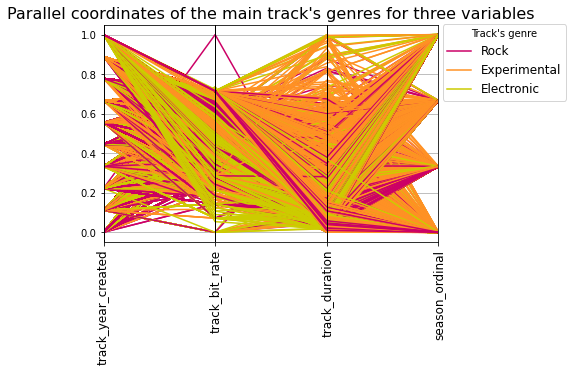

In [2039]:
ax1 = parallel_coordinates(tracks_3_genres_norm, 'track_genre_top', cols = cols, 
                                     color=('#CC0066', '#FF9124', '#CCCC00'))

ax1.legend(loc='upper right', bbox_to_anchor = (1.4, 1.03), title = "Track's genre", frameon = True, fontsize = 12)

plt.title("Parallel coordinates of the main track's genres for three variables", fontsize = 16)
plt.xticks(rotation=90, fontsize = 12)
plt.show()

<b>Now we realize the radar plot of the three main track's genres</b>

In [2040]:
categories = [i for i in tracks_3_genres_norm.columns if i != 'track_genre_top']
categories

['track_bit_rate', 'track_duration', 'track_year_created', 'season_ordinal']

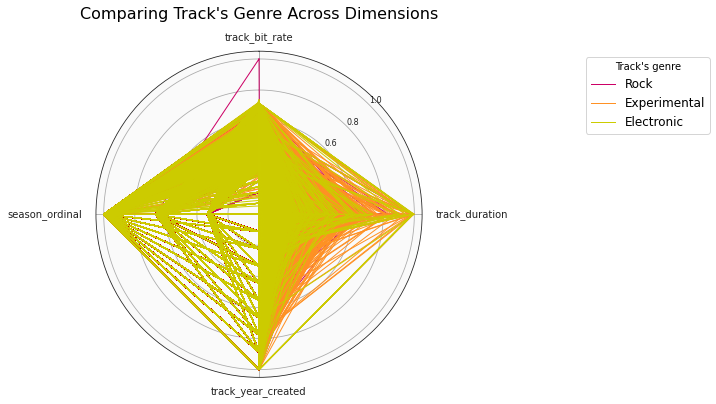

In [2041]:
plot_radar_plot(tracks_3_genres_norm, categories, 'track_genre_top', "Track's genre", False)

<b>Since we notice the presence of two very different values from the rest, let's check which they are, as we suspect that they are outliers</b>

In [2042]:
tracks_3_genres_norm[tracks_3_genres_norm['track_bit_rate'] > 0.8]

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
9517,1.0,0.004574,Rock,0.222222,0.666667


<h4>All track's genres</h4>

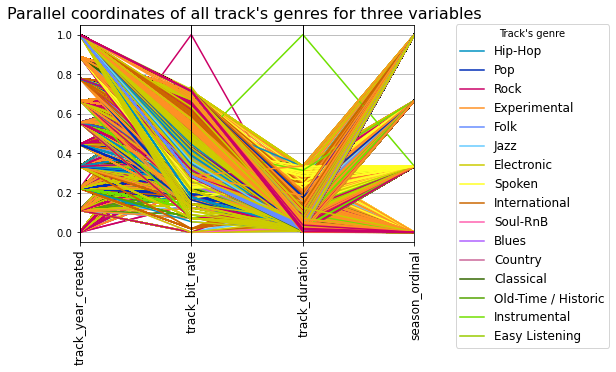

In [2043]:
ax2 = parallel_coordinates(tracks_all_genres_norm, 'track_genre_top', cols = cols, 
                                     color=('#0091C2', '#002EB8', '#CC0066', '#FF9124', '#668CFF', '#66CCFF', '#CCCC00', '#FFFF24', '#CC6600', 
          '#FF61B0', '#B061FF', '#CC6699', '#336600', '#52A300', '#70E000', '#99CC00'))

ax2.legend(loc='upper right', bbox_to_anchor = (1.6, 1.03), title = "Track's genre", frameon = True, fontsize = 12)

plt.title("Parallel coordinates of all track's genres for three variables ", fontsize = 16)
plt.xticks(rotation=90, fontsize = 12)
plt.show()

In [2044]:
categories = [i for i in tracks_all_genres_norm.columns if i != 'track_genre_top']
categories

['track_bit_rate', 'track_duration', 'track_year_created', 'season_ordinal']

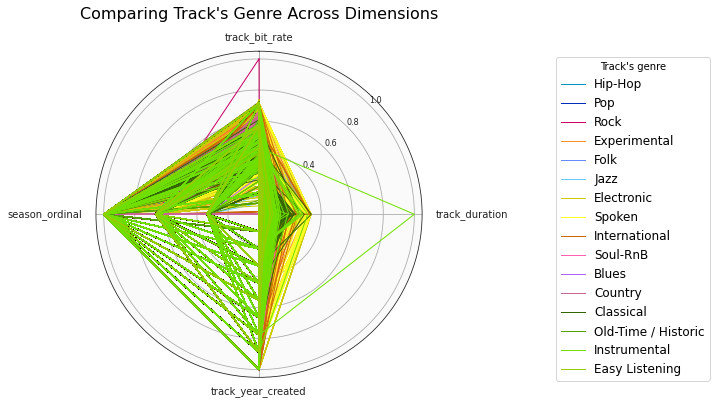

In [2045]:
plot_radar_plot(tracks_all_genres_norm, categories, 'track_genre_top', "Track's genre", True)

In [2046]:
tracks_all_genres_norm[tracks_all_genres_norm['track_duration'] > 0.7]

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
40362,0.428573,1.0,Instrumental,0.777778,0.333333


In [2047]:
tracks_all_genres_norm[tracks_all_genres_norm['track_bit_rate'] > 0.8]

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
13745,1.0,0.001632,Rock,0.222222,0.666667


<h2>Experiments</h2>

<h3>Track duration</h3>

In [2048]:
(tracks_3_genres_full['track_duration']).describe()

count    34162.000000
mean       278.591593
std        282.656811
min          1.000000
25%        145.250000
50%        217.000000
75%        315.000000
max       3718.000000
Name: track_duration, dtype: float64

In [2049]:
genre_unique = [genre for genre in tracks_3_genres_full['track_genre_top'].dropna().unique()]
genre_unique

['Rock', 'Experimental', 'Electronic']

In [2050]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]
    print(dfc['track_duration'].describe())
    print('------------------------------------')

Rock

count    14182.000000
mean       225.497109
std        189.649111
min          2.000000
25%        136.000000
50%        189.000000
75%        260.000000
max       3675.000000
Name: track_duration, dtype: float64
------------------------------------
Experimental

count    10608.000000
mean       362.668458
std        390.914861
min          1.000000
25%        145.000000
50%        256.000000
75%        436.000000
max       3718.000000
Name: track_duration, dtype: float64
------------------------------------
Electronic

count    9372.000000
mean      263.770700
std       226.632493
min         4.000000
25%       171.000000
50%       240.000000
75%       313.000000
max      3714.000000
Name: track_duration, dtype: float64
------------------------------------


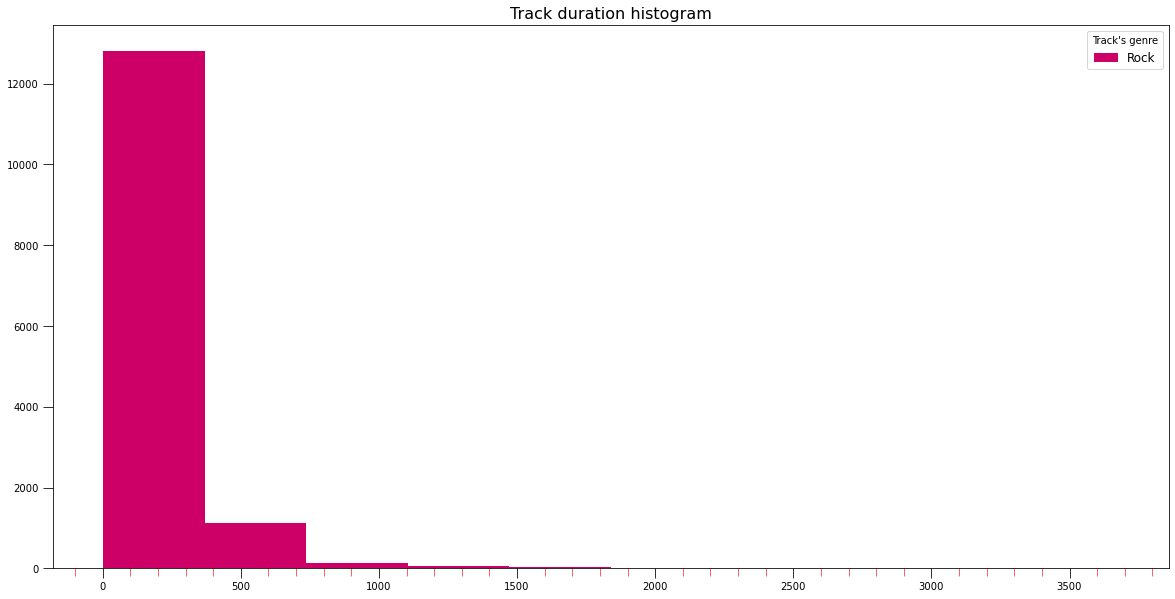

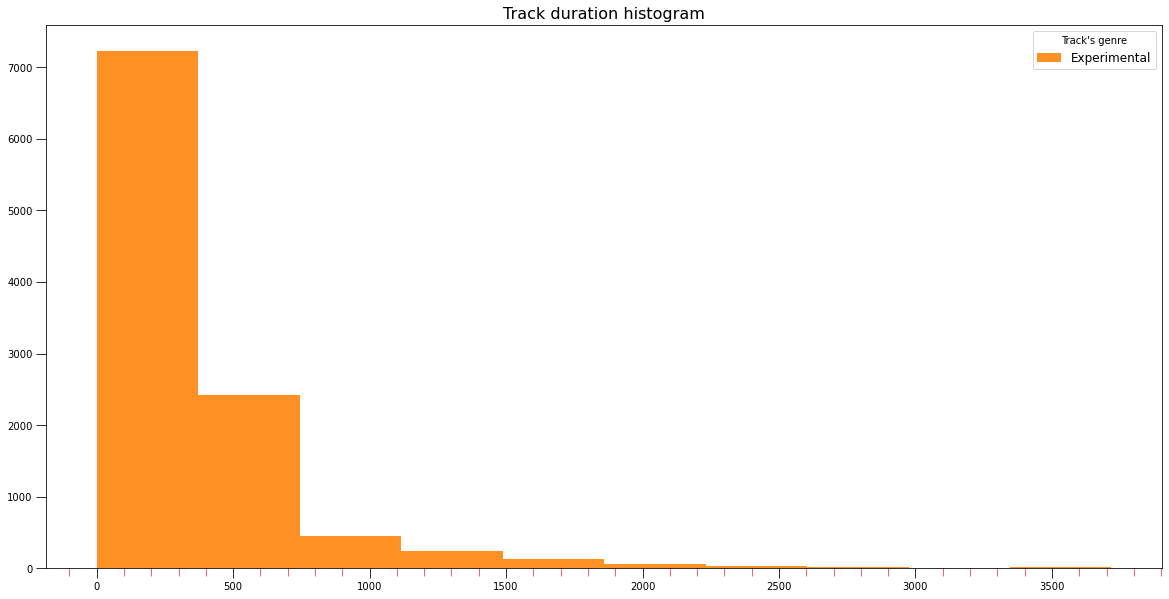

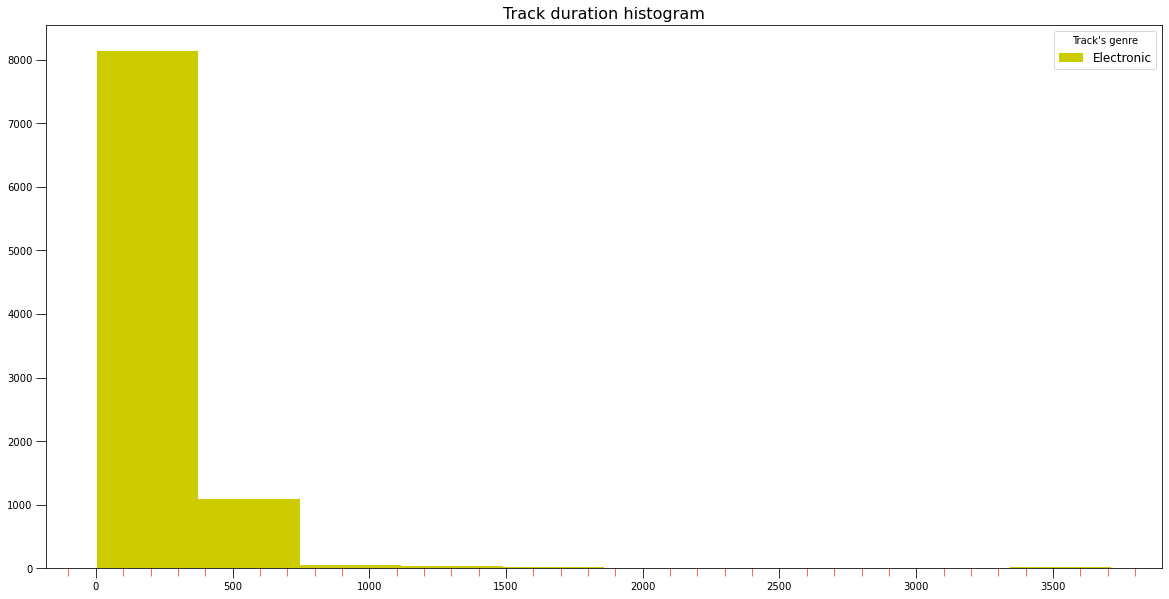

In [2051]:
colors = ['#CC0066', '#FF9124', '#CCCC00']

for i, genre in enumerate(tracks_3_genres_full['track_genre_top'].dropna().unique()):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
    color = colors[i]

    distrib = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]['track_duration']
    ax.hist(distrib, label = genre, color = color)
    ax.legend(loc='upper right', title = "Track's genre", frameon=True, fontsize = 12)
    ax.set_title('Track duration' + " histogram", fontsize = 16)
            
    
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=8, color='r')

    plt.show()

In [2052]:
tr_dr = tracks_3_genres_full[tracks_3_genres_full['track_duration'] > 2000]
tr_dr

,track_bit_rate,track_duration,track_genre_top,track_year_created,season_ordinal
965,256000,2192,Rock,2008,3
1229,256000,3694,Experimental,2008,3
1230,256000,3710,Experimental,2008,3
1942,256000,3086,Rock,2008,3
2008,256000,2356,Rock,2008,3
...,...,...,...,...,...
102370,320000,3682,Electronic,2017,4
102371,320000,3682,Electronic,2017,4
102372,320000,3682,Electronic,2017,4
105330,128000,3703,Experimental,2017,4


In [2053]:
for genre in genre_unique:
    count = 0
    for i, row in enumerate(tr_dr['track_genre_top']):
        if (row == genre):
            count+=1
        
    print("{0:27} {1}".format(genre, count))

Rock                        27
Experimental                114
Electronic                  31


<h3>Track bit rate</h3>

In [2054]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]
    print(dfc['track_bit_rate'].describe())
    print('------------------------------------')

Rock

count     14182.000000
mean     253943.741362
std       59443.394046
min          -1.000000
25%      203730.750000
50%      256000.000000
75%      320000.000000
max      448000.000000
Name: track_bit_rate, dtype: float64
------------------------------------
Experimental

count     10608.000000
mean     265434.069193
std       67695.188434
min          -1.000000
25%      192000.000000
50%      320000.000000
75%      320000.000000
max      322892.000000
Name: track_bit_rate, dtype: float64
------------------------------------
Electronic

count      9372.000000
mean     275473.840909
std       63060.353944
min          -1.000000
25%      254075.000000
50%      320000.000000
75%      320000.000000
max      330042.000000
Name: track_bit_rate, dtype: float64
------------------------------------


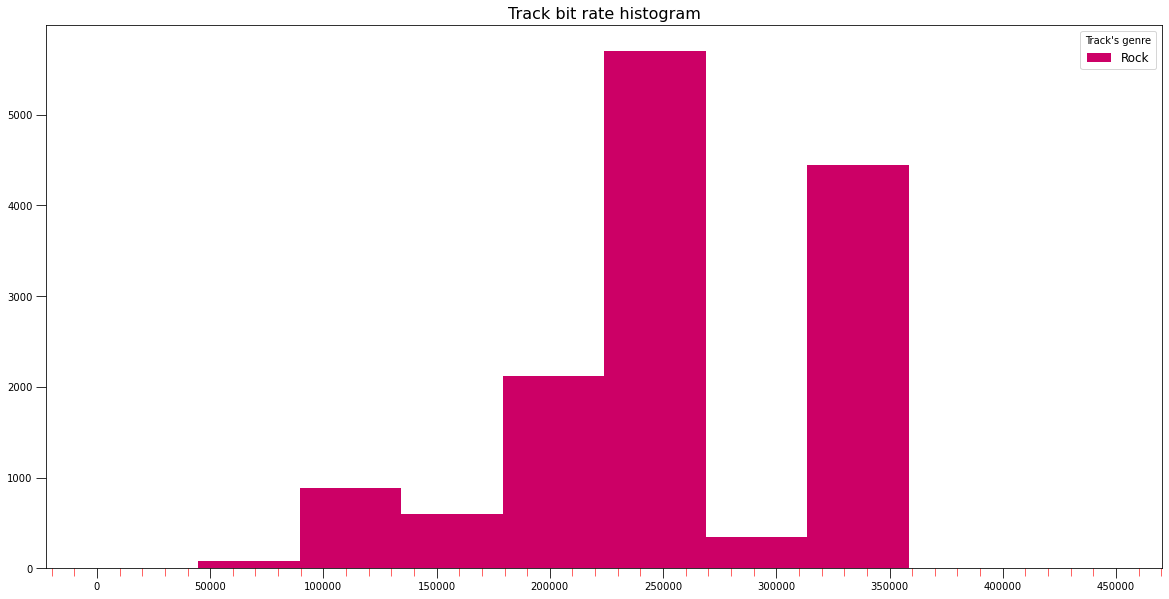

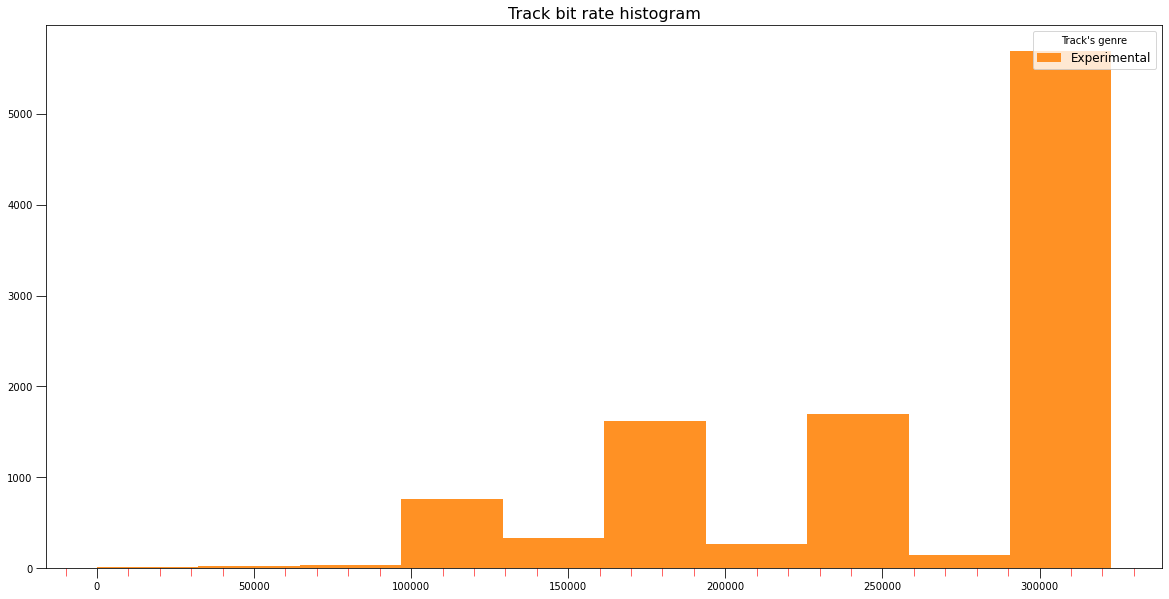

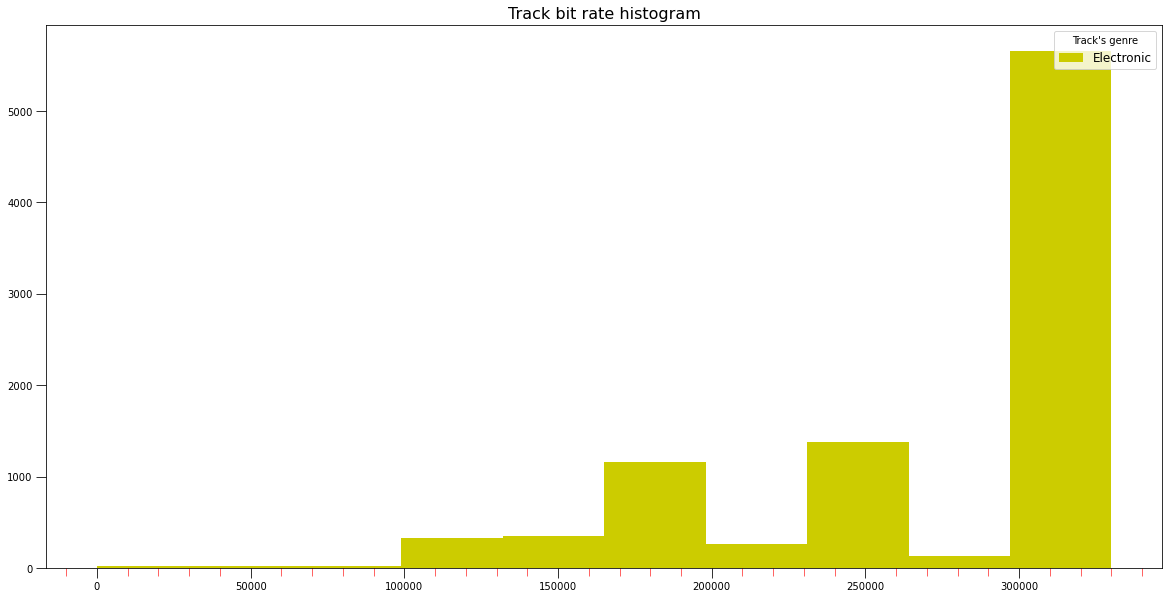

In [2055]:
colors = ['#CC0066', '#FF9124', '#CCCC00']

for i, genre in enumerate(tracks_3_genres_full['track_genre_top'].dropna().unique()):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
    color = colors[i]

    distrib = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]['track_bit_rate']
    ax.hist(distrib, label = genre, color = color)
    ax.legend(loc='upper right', title = "Track's genre", frameon=True, fontsize = 12)
    ax.set_title('Track bit rate' + " histogram", fontsize = 16)
            
    
    ax.xaxis.set_major_locator(MultipleLocator(50000))
    ax.xaxis.set_minor_locator(MultipleLocator(10000))
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=8, color='r')

    plt.show()

<h3>Track year created</h3>

In [2056]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]
    print(dfc['track_year_created'].describe())
    print('------------------------------------')

Rock

count    14182.000000
mean      2011.943238
std          2.621443
min       2008.000000
25%       2010.000000
50%       2012.000000
75%       2014.000000
max       2017.000000
Name: track_year_created, dtype: float64
------------------------------------
Experimental

count    10608.000000
mean      2012.307598
std          2.433064
min       2008.000000
25%       2010.000000
50%       2012.000000
75%       2014.000000
max       2017.000000
Name: track_year_created, dtype: float64
------------------------------------
Electronic

count    9372.000000
mean     2012.385403
std         2.546168
min      2008.000000
25%      2010.000000
50%      2012.000000
75%      2014.000000
max      2017.000000
Name: track_year_created, dtype: float64
------------------------------------


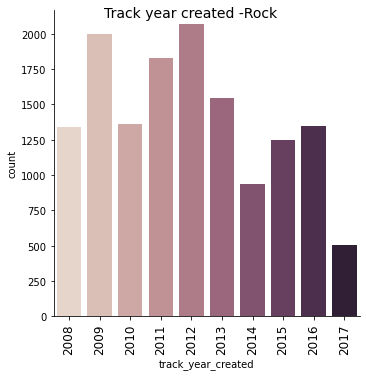

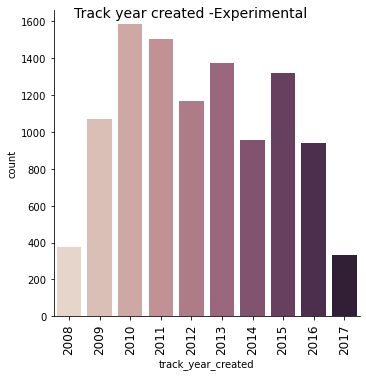

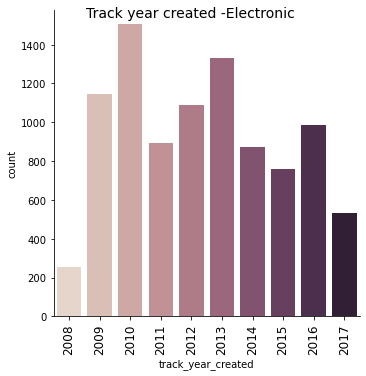

In [2057]:
for genre in genre_unique:
    df = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]
    list_y = [year for year in df['track_year_created'].dropna().unique()]
    
    ax = sns.catplot(x = "track_year_created", data = df, kind = 'count', palette="ch:.15")
    ax.set_xticklabels(rotation=90, fontsize = 12)
    ax.fig.suptitle("Track year created -{}".format(genre), fontsize = 14)
    
    plt.show()

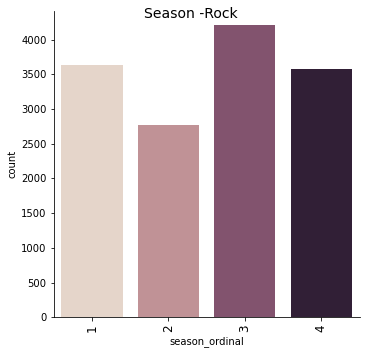

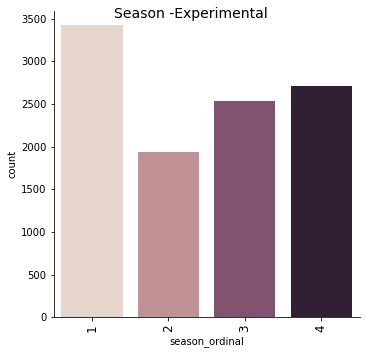

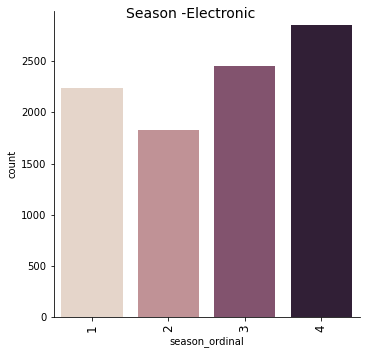

In [2058]:
for genre in genre_unique:
    df = tracks_3_genres_full[tracks_3_genres_full['track_genre_top'] == genre]
    list_s = [s for s in df['season_ordinal'].dropna().unique()]
    
    ax = sns.catplot(x = "season_ordinal", data = df, kind = 'count', palette="ch:.15")
    ax.set_xticklabels(rotation=90, fontsize = 12)
    ax.fig.suptitle("Season -{}".format(genre), fontsize = 14)
    
    plt.show()

In [2059]:
no_genre = df_tracks_part_reduced[df_tracks_part_reduced['track_genre_top'].isna()]

In [2060]:
no_genre[no_genre['track_duration'] > 4000]

,artist_active_year_begin,track_bit_rate,track_duration,track_genre_top,album_year_created,season_ordinal
1681,1973,256000,18350,NaN,2008,2.0
70994,0,206437,10999,NaN,2014,4.0
74094,1998,320000,7372,NaN,2014,1.0
74775,2013,192000,11016,NaN,2015,2.0
86007,2013,192000,7320,NaN,2015,1.0


<h3>All genres</h3>

<h4>Track duration</h4>

In [2061]:
(tracks_all_genres_full['track_duration']).describe()

count    106574.000000
mean        277.849100
std         305.518553
min           0.000000
25%         149.000000
50%         216.000000
75%         305.000000
max       18350.000000
Name: track_duration, dtype: float64

In [2062]:
genre_unique = [genre for genre in tracks_all_genres_full['track_genre_top'].dropna().unique()]
genre_unique

['Hip-Hop',
 'Pop',
 'Rock',
 'Experimental',
 'Folk',
 'Jazz',
 'Electronic',
 'Spoken',
 'International',
 'Soul-RnB',
 'Blues',
 'Country',
 'Classical',
 'Old-Time / Historic',
 'Instrumental',
 'Easy Listening']

In [2063]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]
    print(dfc['track_duration'].describe())
    print('------------------------------------')

Hip-Hop

count    3552.000000
mean      202.759572
std       118.365324
min         5.000000
25%       153.000000
50%       200.000000
75%       244.000000
max      3672.000000
Name: track_duration, dtype: float64
------------------------------------
Pop

count    2332.000000
mean      188.661664
std       153.098186
min         0.000000
25%       104.000000
50%       186.000000
75%       247.000000
max      2511.000000
Name: track_duration, dtype: float64
------------------------------------
Rock

count    14182.000000
mean       225.497109
std        189.649111
min          2.000000
25%        136.000000
50%        189.000000
75%        260.000000
max       3675.000000
Name: track_duration, dtype: float64
------------------------------------
Experimental

count    10608.000000
mean       362.668458
std        390.914861
min          1.000000
25%        145.000000
50%        256.000000
75%        436.000000
max       3718.000000
Name: track_duration, dtype: float64
-------------------

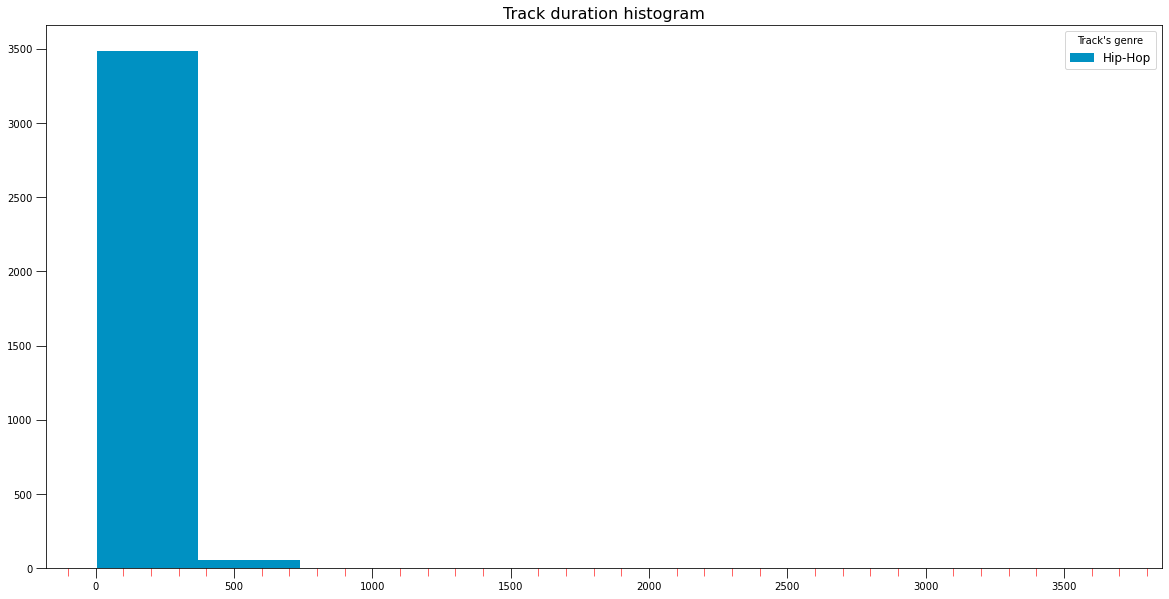

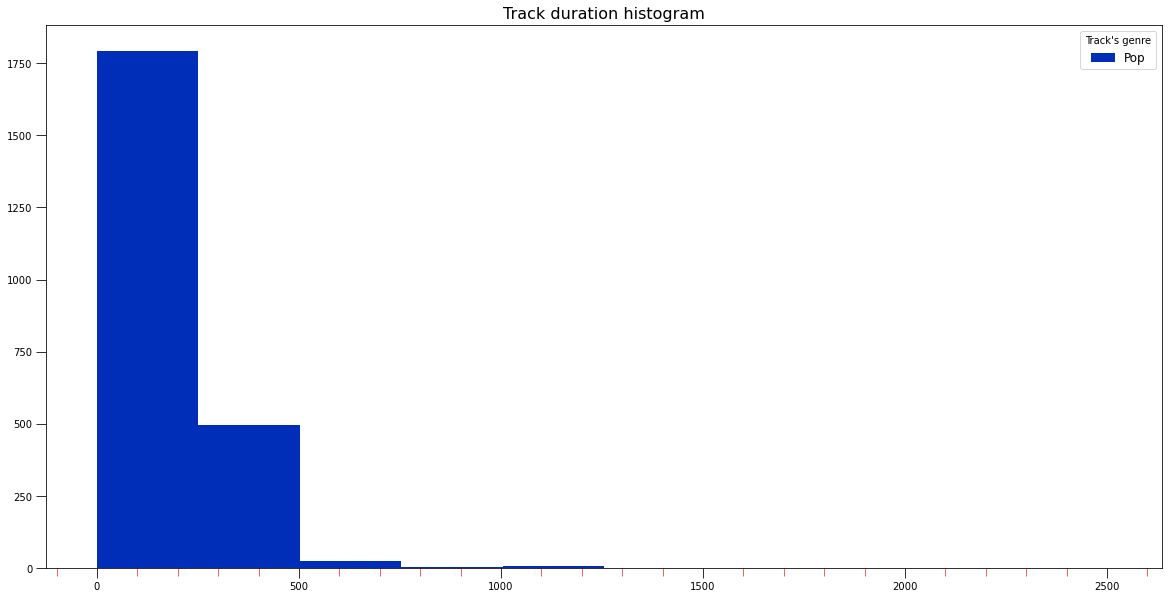

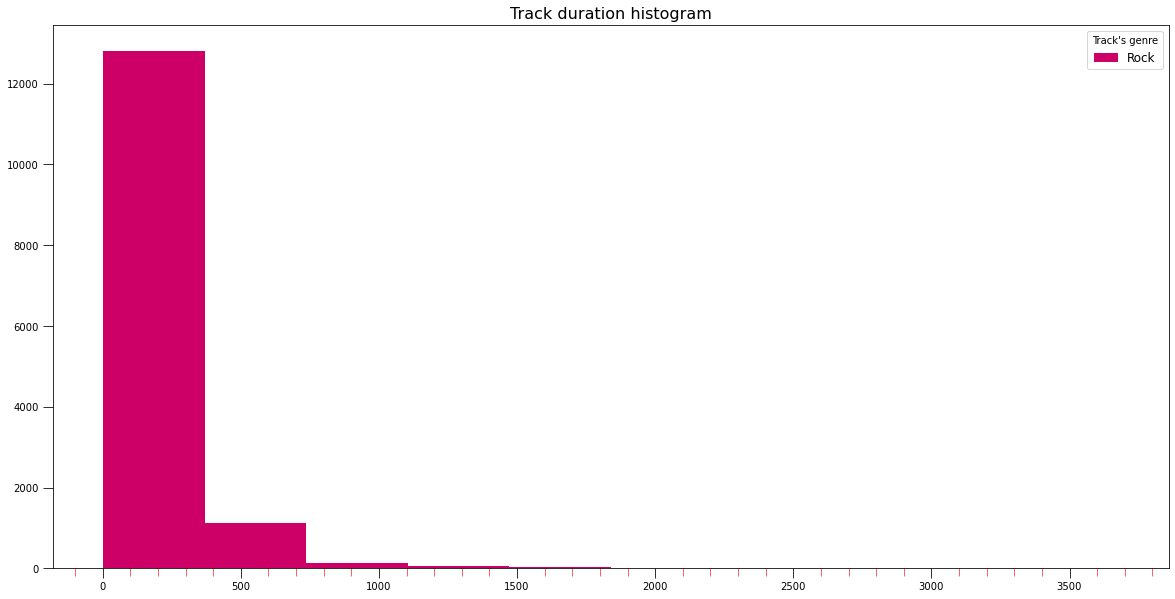

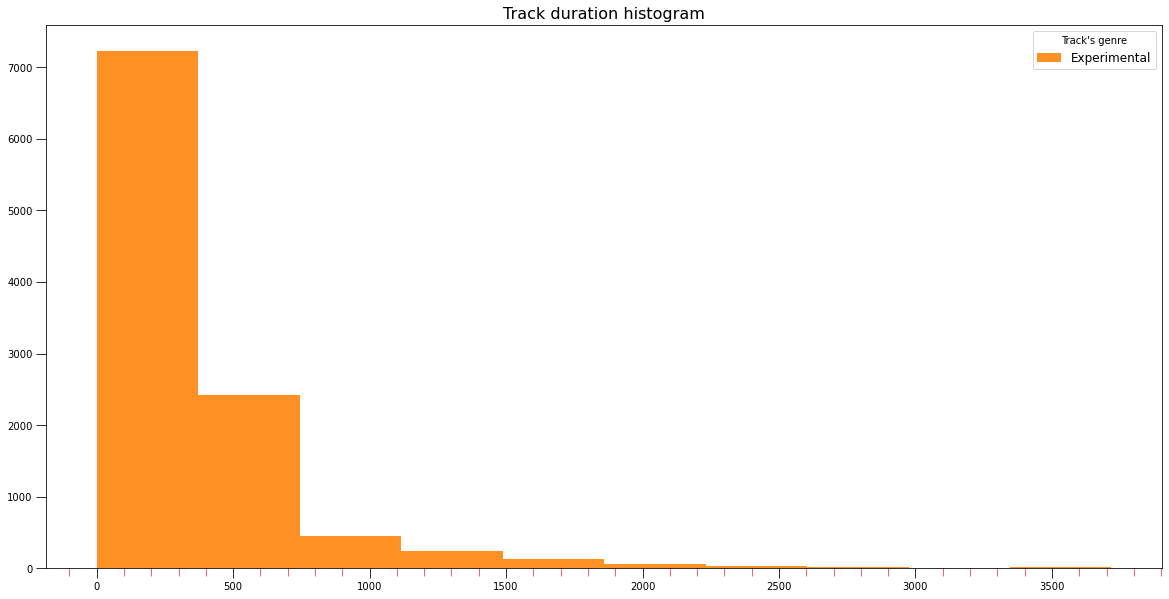

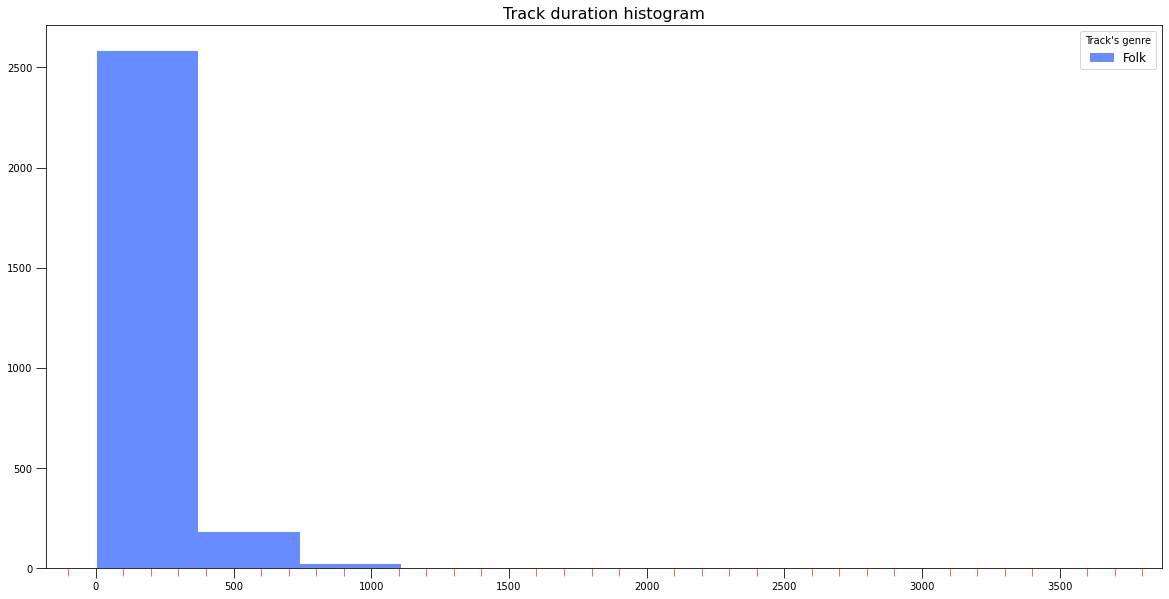

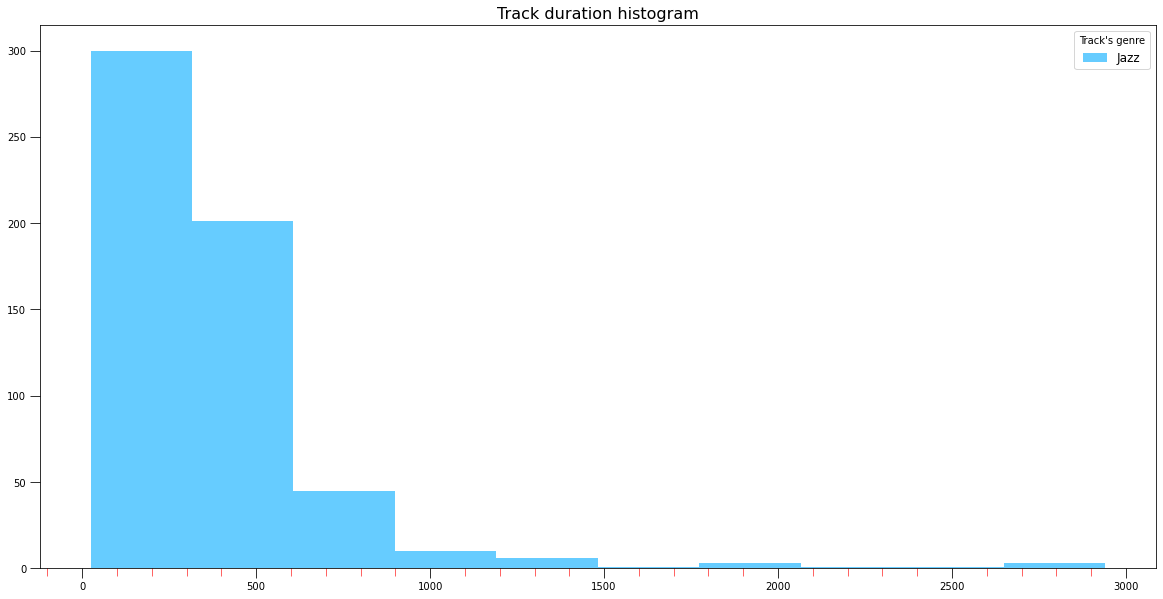

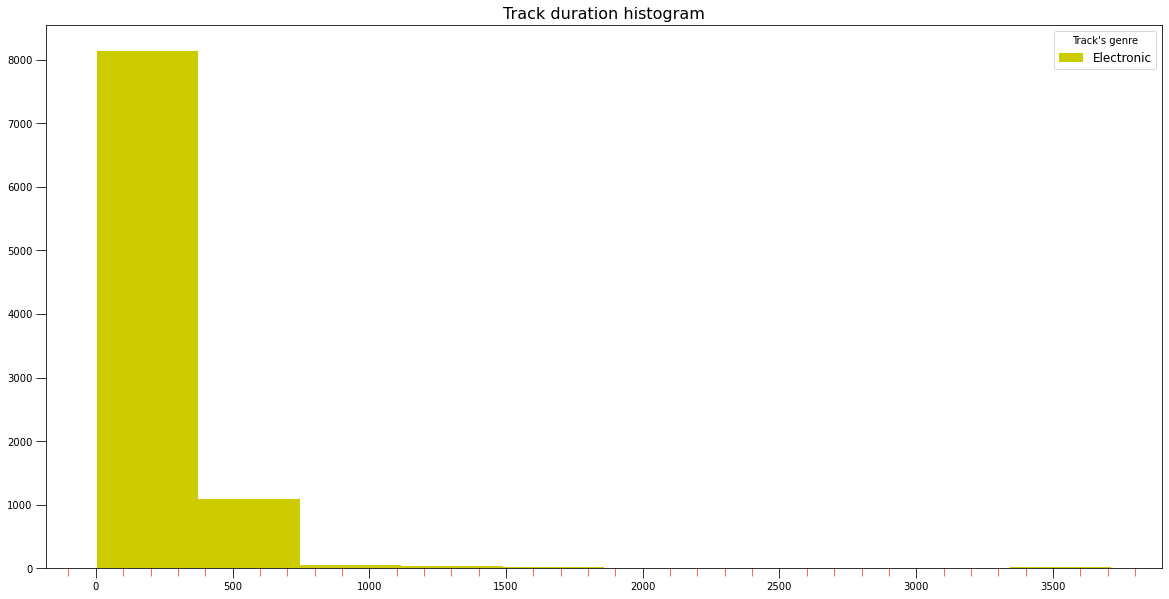

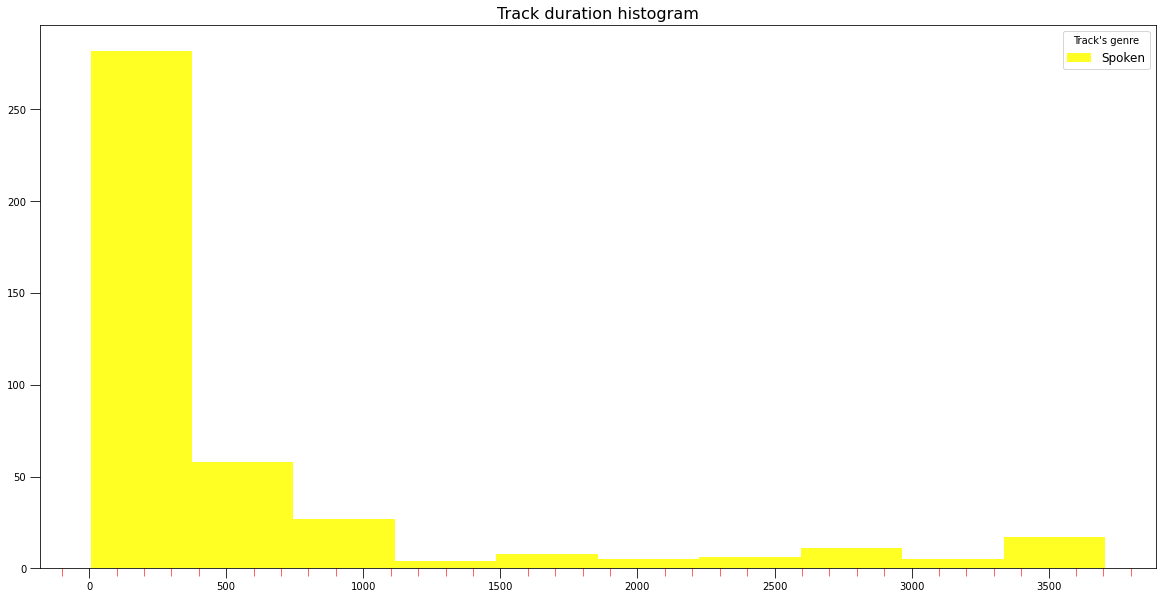

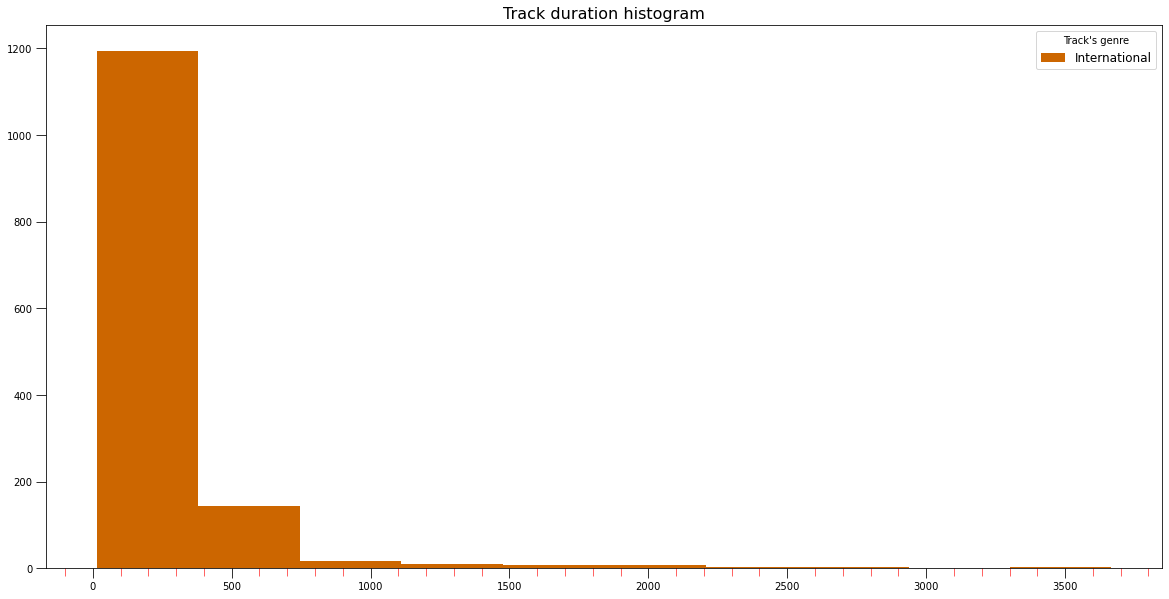

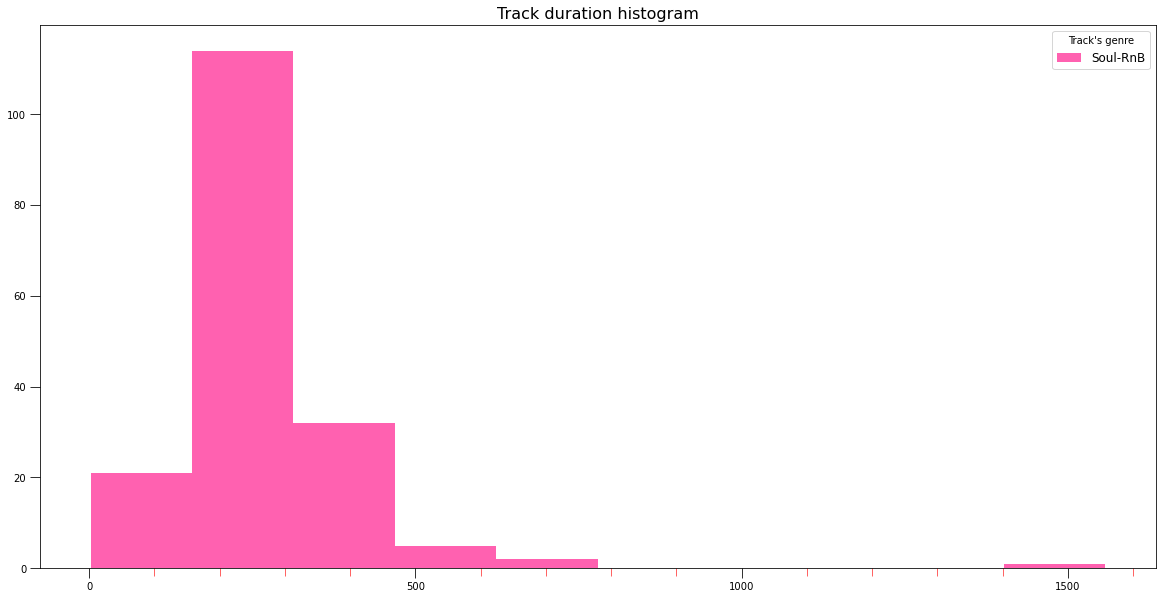

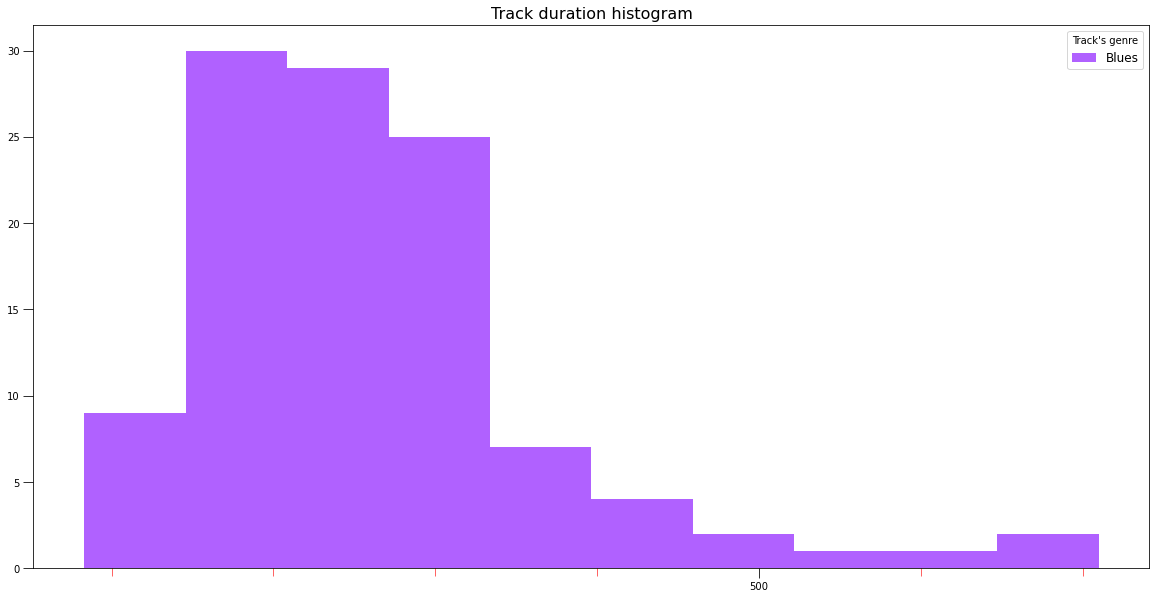

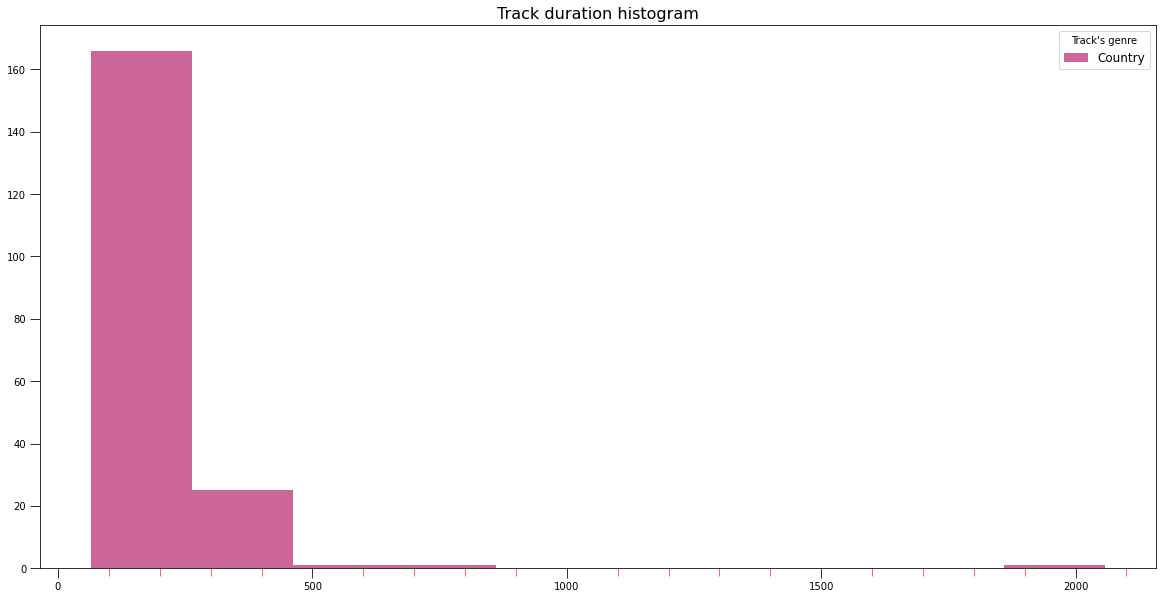

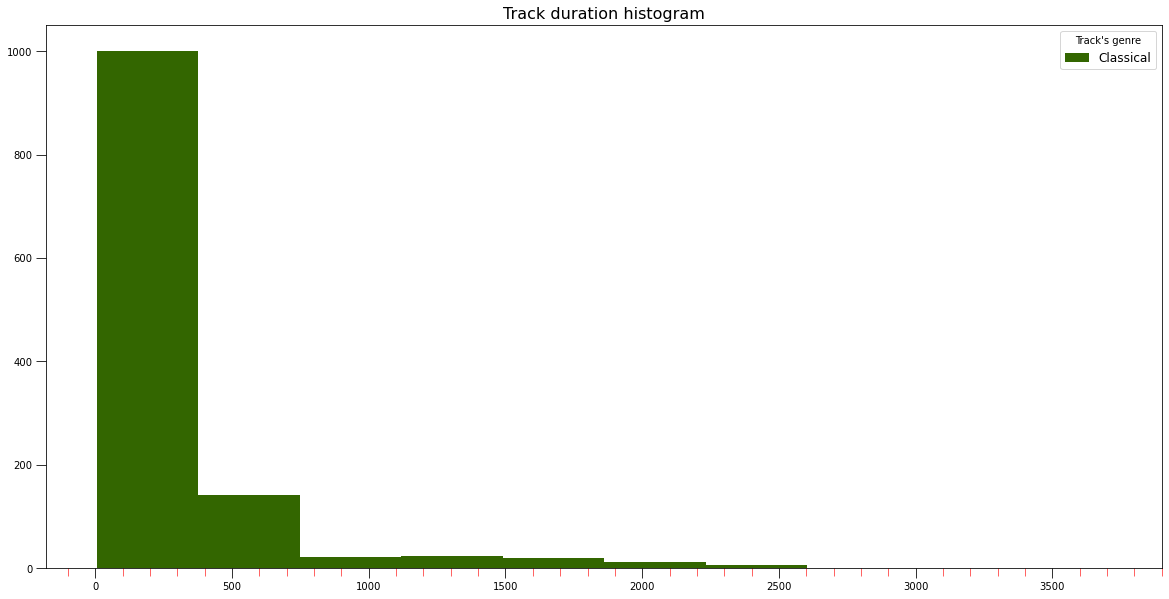

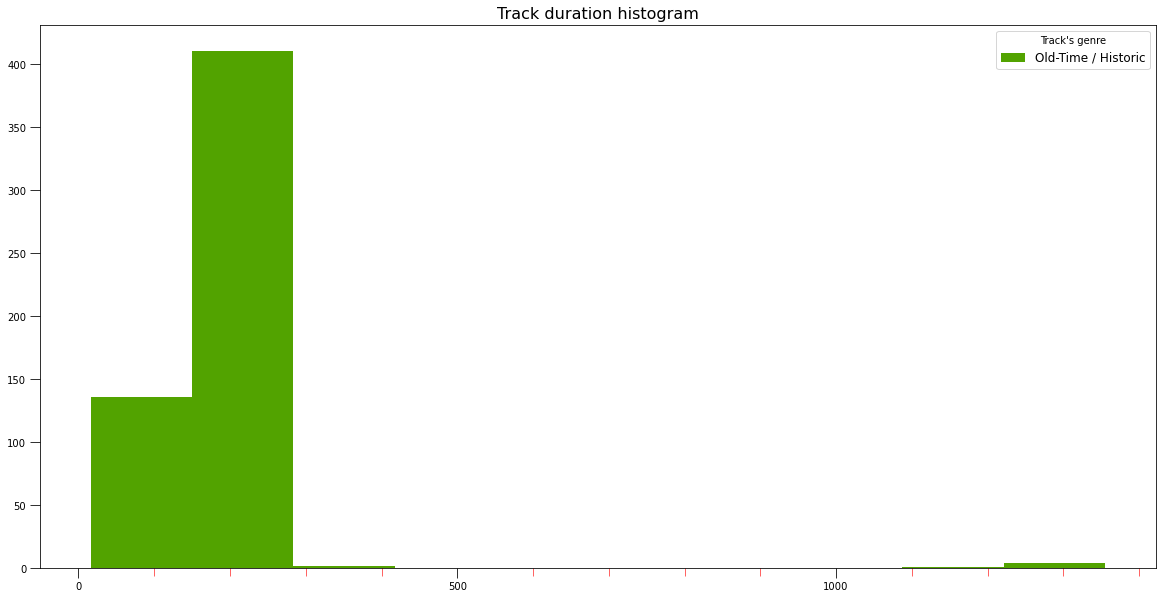

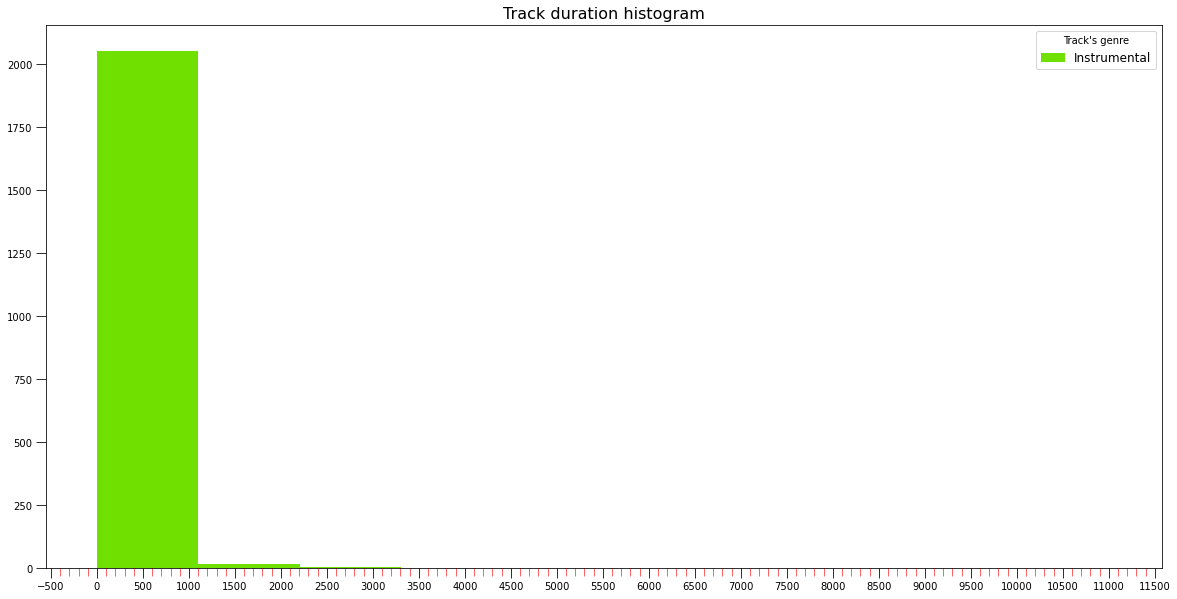

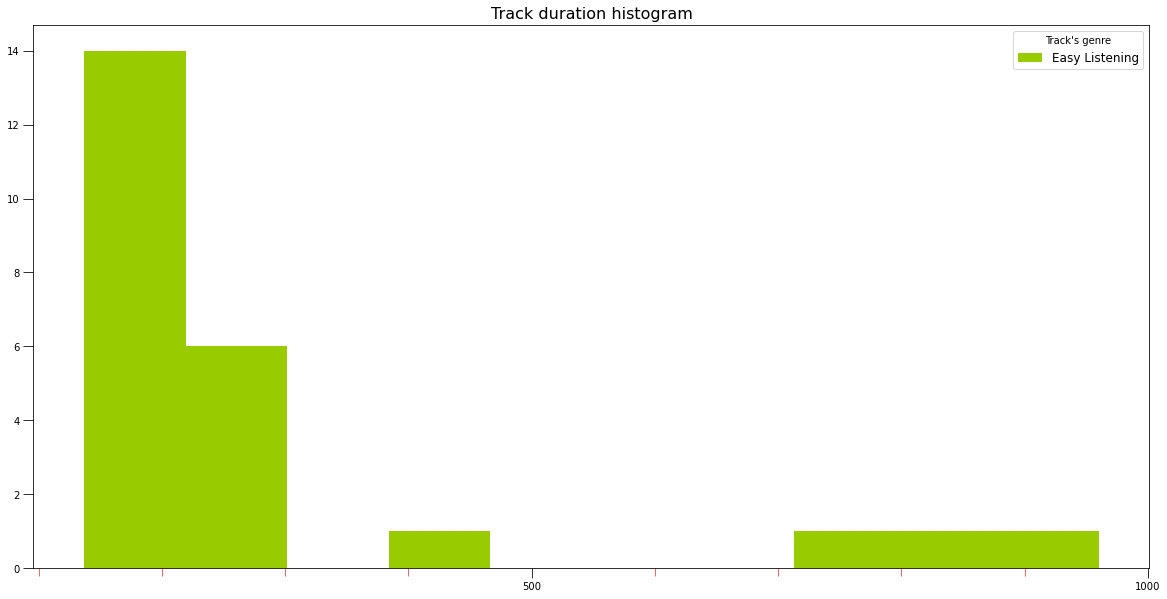

In [2064]:
colors = ['#0091C2', '#002EB8', '#CC0066', '#FF9124', '#668CFF', '#66CCFF', '#CCCC00', '#FFFF24', '#CC6600', 
          '#FF61B0', '#B061FF', '#CC6699', '#336600', '#52A300', '#70E000', '#99CC00']

for i, genre in enumerate(tracks_all_genres_full['track_genre_top'].dropna().unique()):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
    color = colors[i]

    distrib = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]['track_duration']
    ax.hist(distrib, label = genre, color = color)
    ax.legend(loc='upper right', title = "Track's genre", frameon=True, fontsize = 12)
    ax.set_title('Track duration' + " histogram", fontsize = 16)
            
    
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=8, color='r')

    plt.show()

<h3>Track bit rate</h3>

In [2065]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]
    print(dfc['track_bit_rate'].describe())
    print('------------------------------------')

Hip-Hop

count      3552.000000
mean     279045.301802
std       65532.390943
min       24000.000000
25%      256000.000000
50%      320000.000000
75%      320000.000000
max      321966.000000
Name: track_bit_rate, dtype: float64
------------------------------------
Pop

count      2332.000000
mean     246443.307033
std       73395.451234
min          -1.000000
25%      192000.000000
50%      256000.000000
75%      320000.000000
max      323488.000000
Name: track_bit_rate, dtype: float64
------------------------------------
Rock

count     14182.000000
mean     253943.741362
std       59443.394046
min          -1.000000
25%      203730.750000
50%      256000.000000
75%      320000.000000
max      448000.000000
Name: track_bit_rate, dtype: float64
------------------------------------
Experimental

count     10608.000000
mean     265434.069193
std       67695.188434
min          -1.000000
25%      192000.000000
50%      320000.000000
75%      320000.000000
max      322892.000000
Name: tr

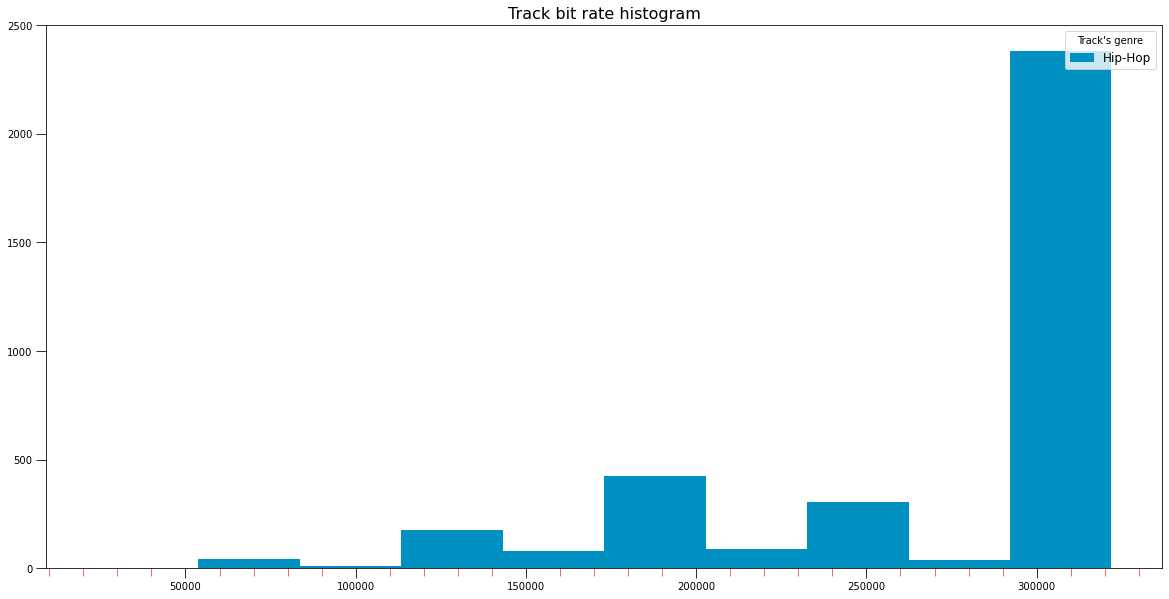

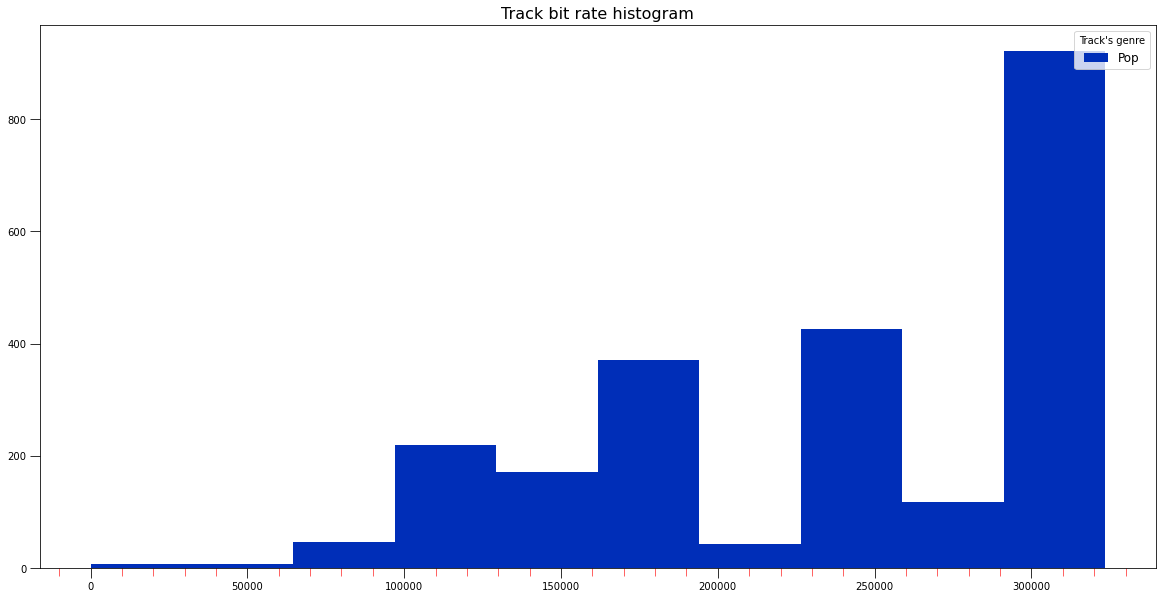

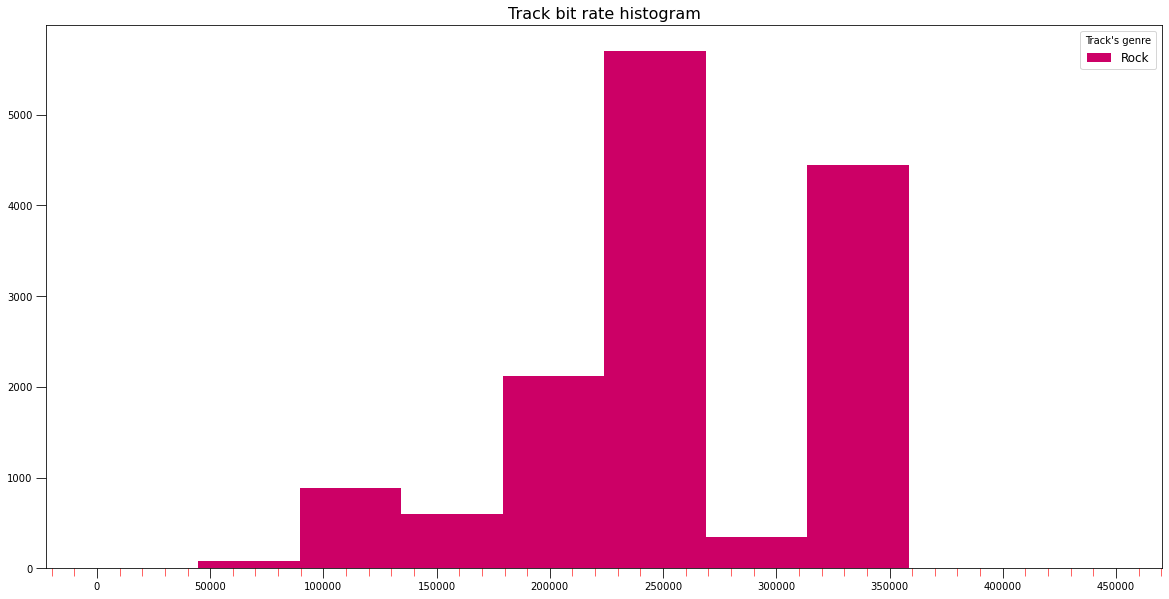

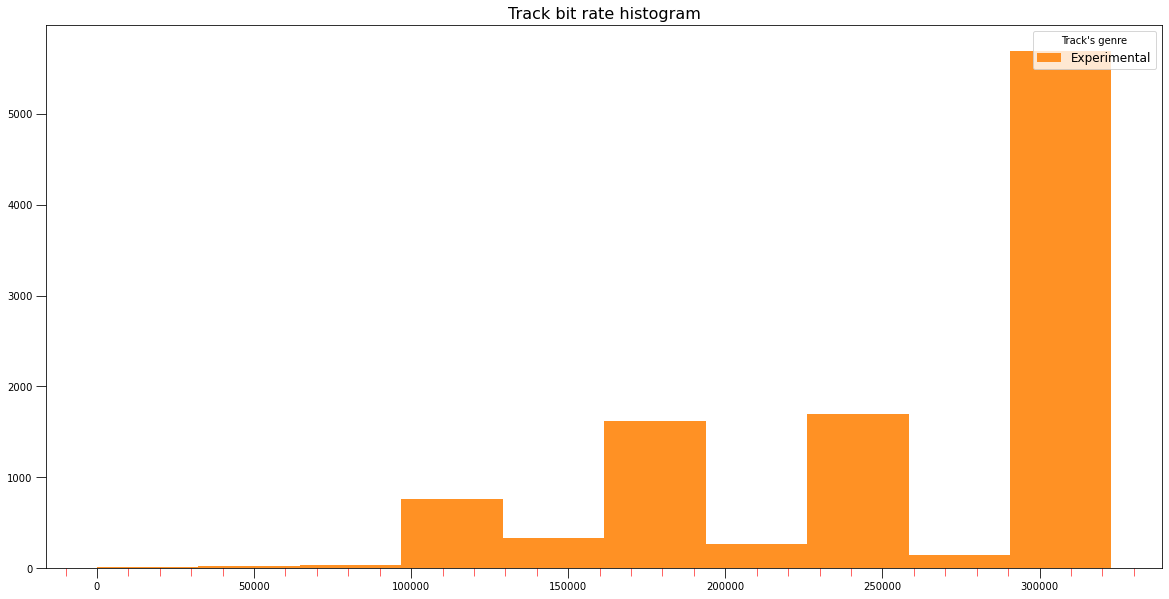

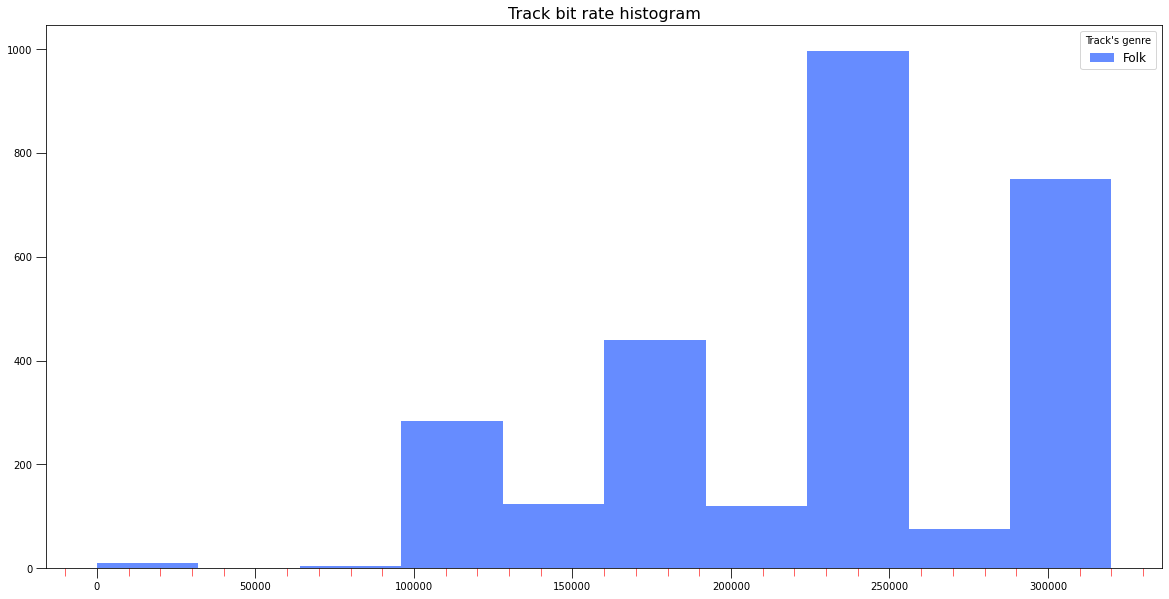

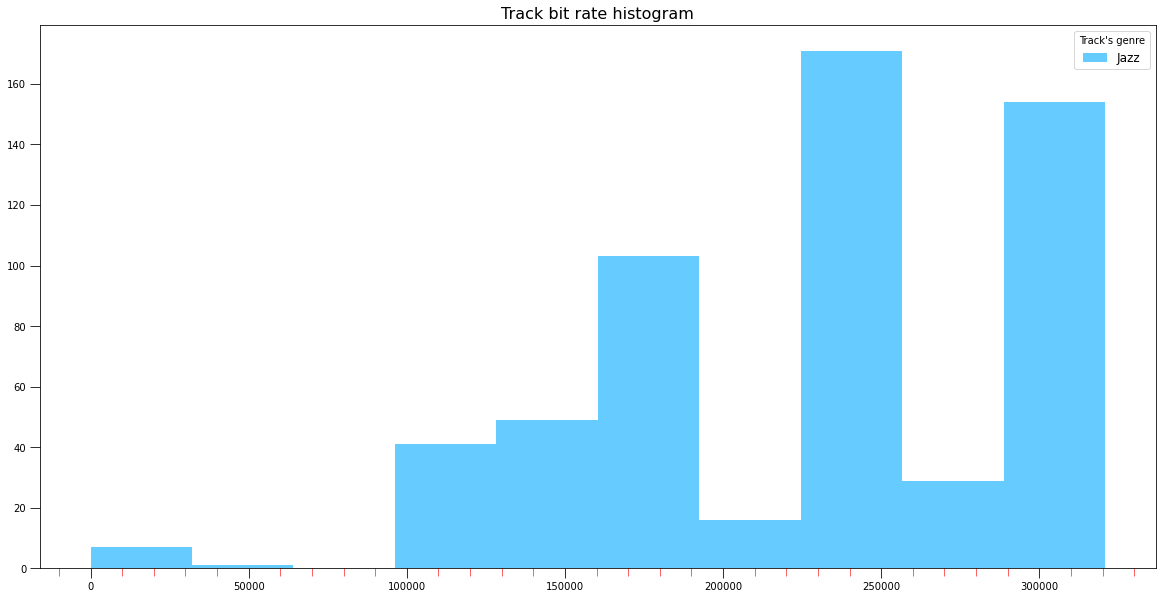

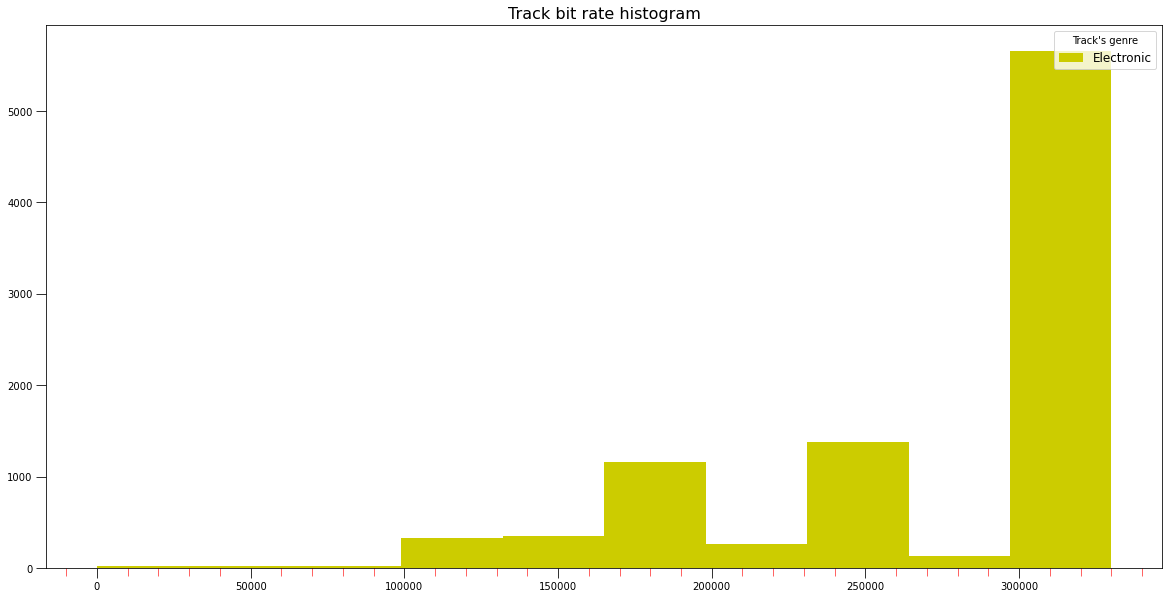

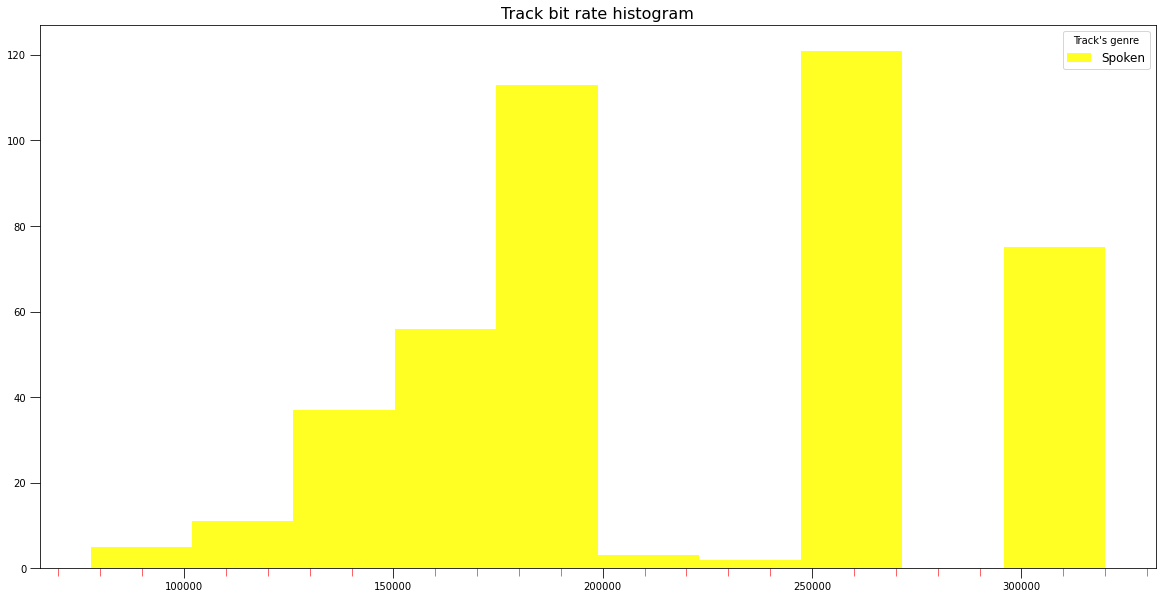

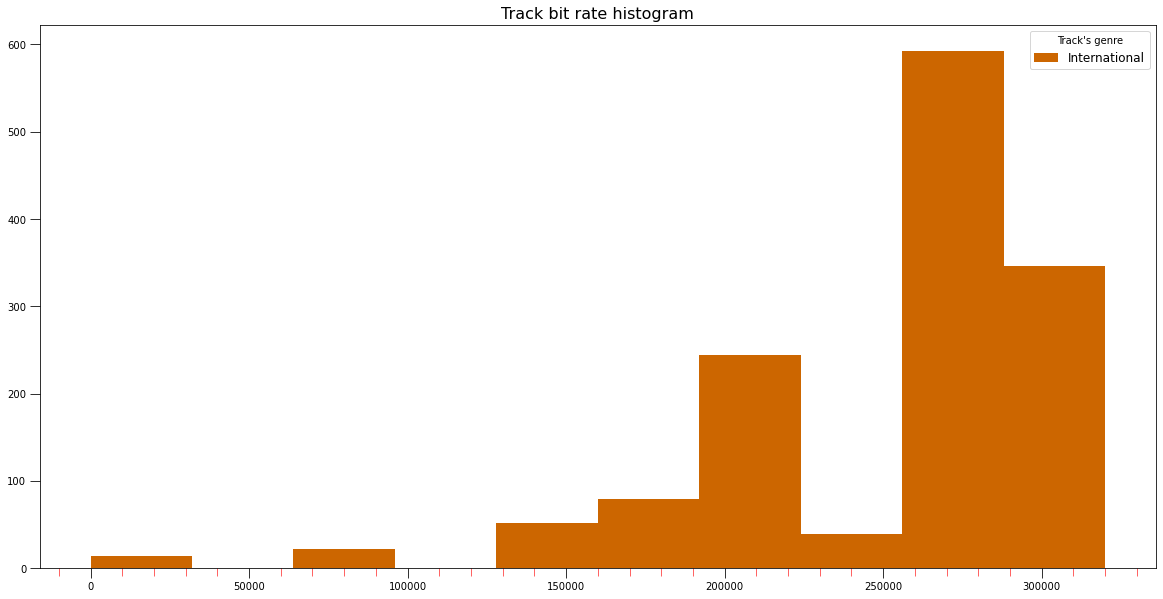

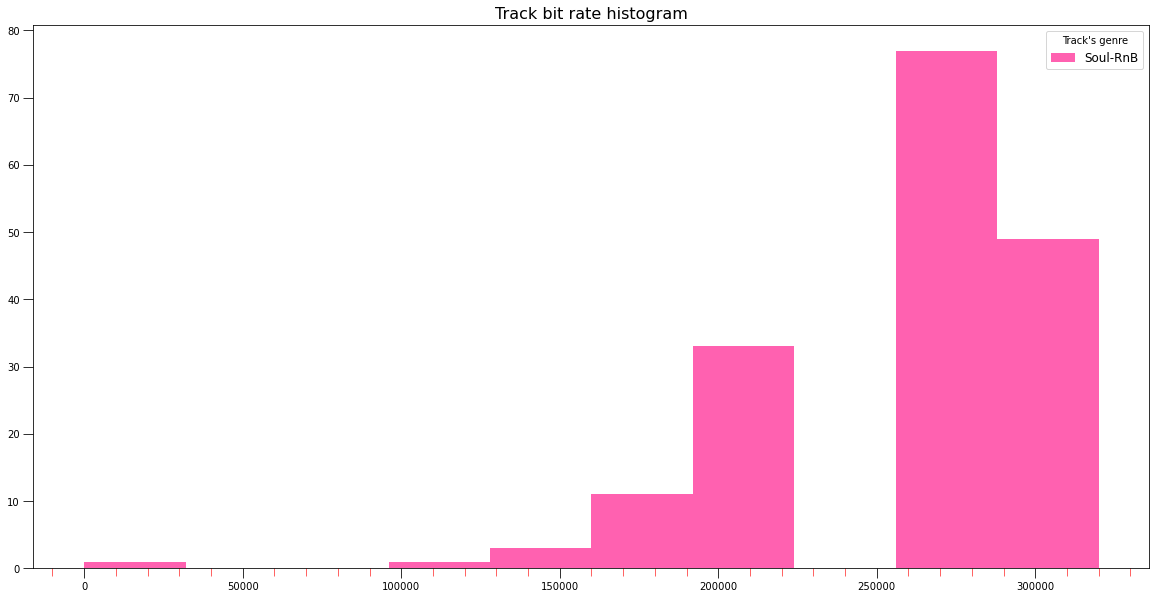

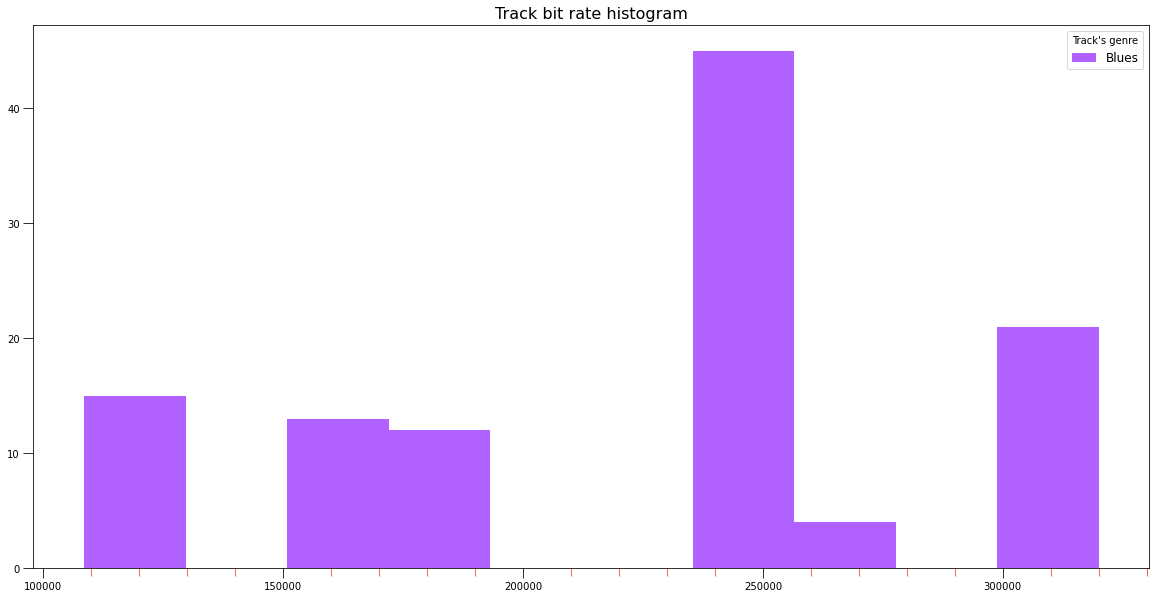

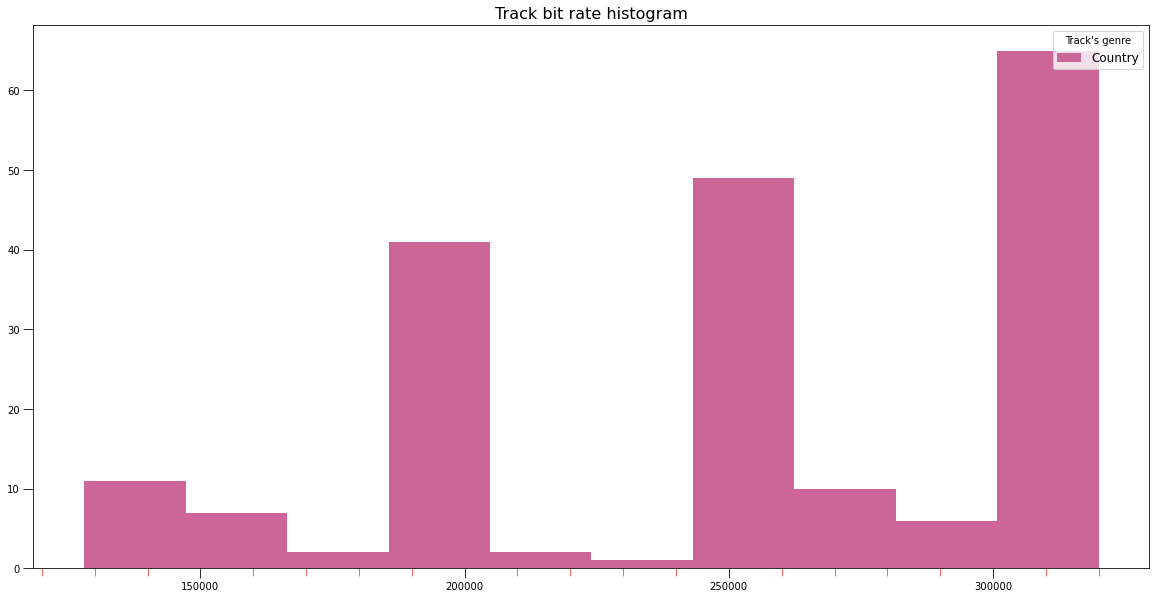

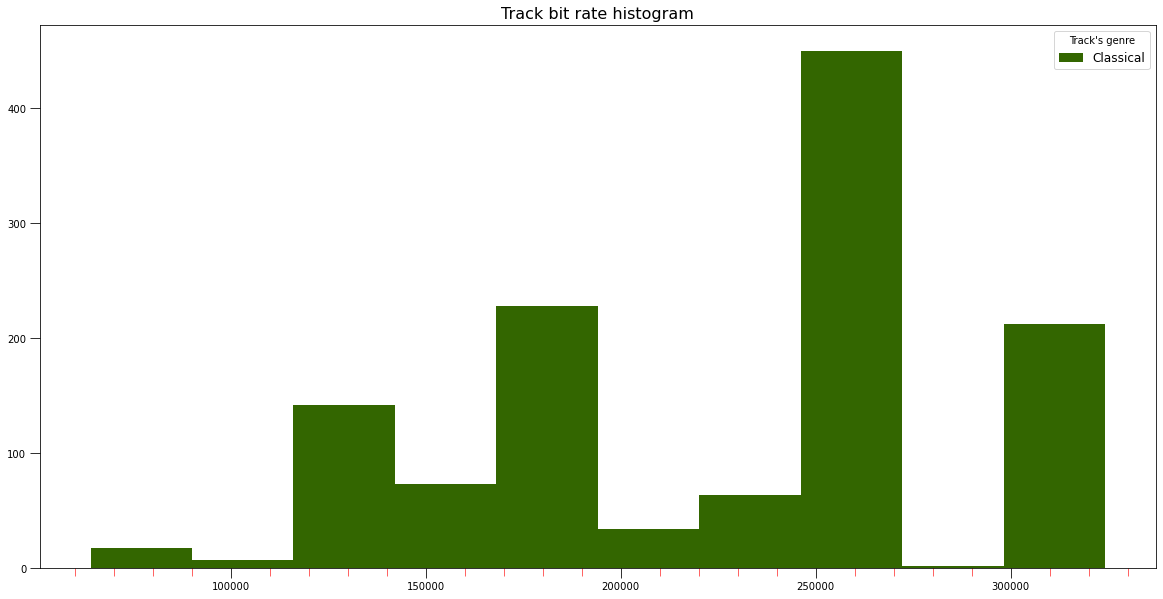

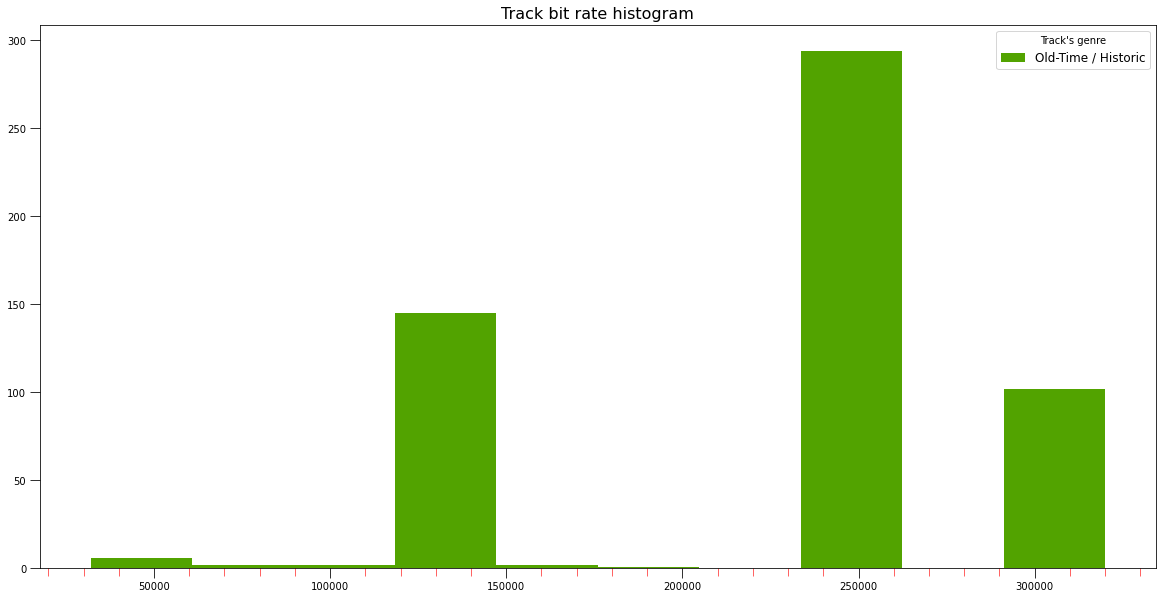

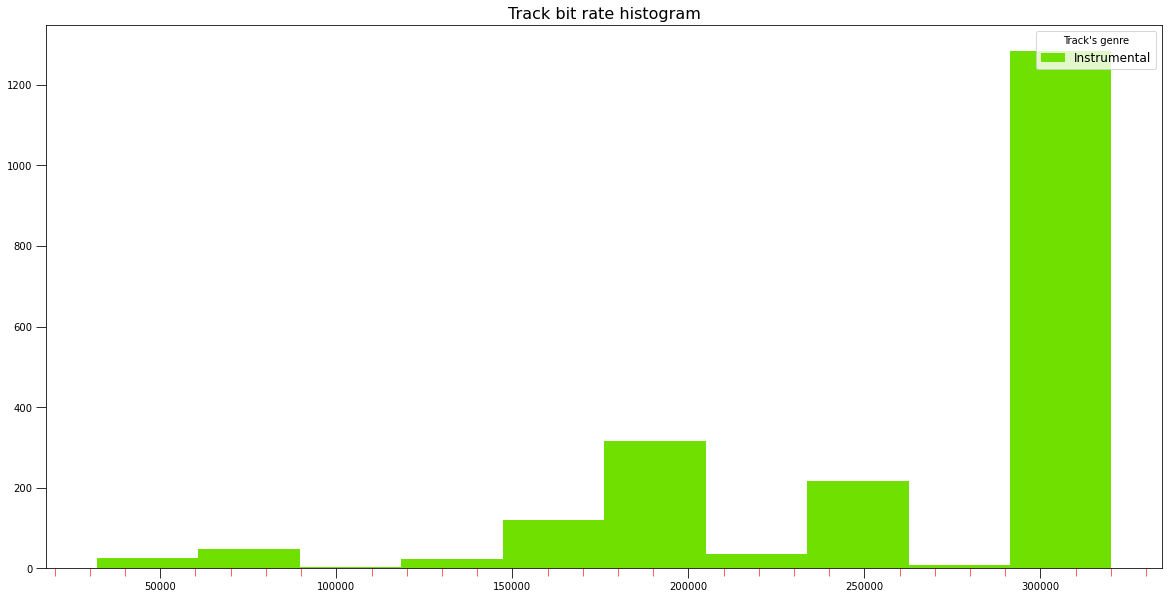

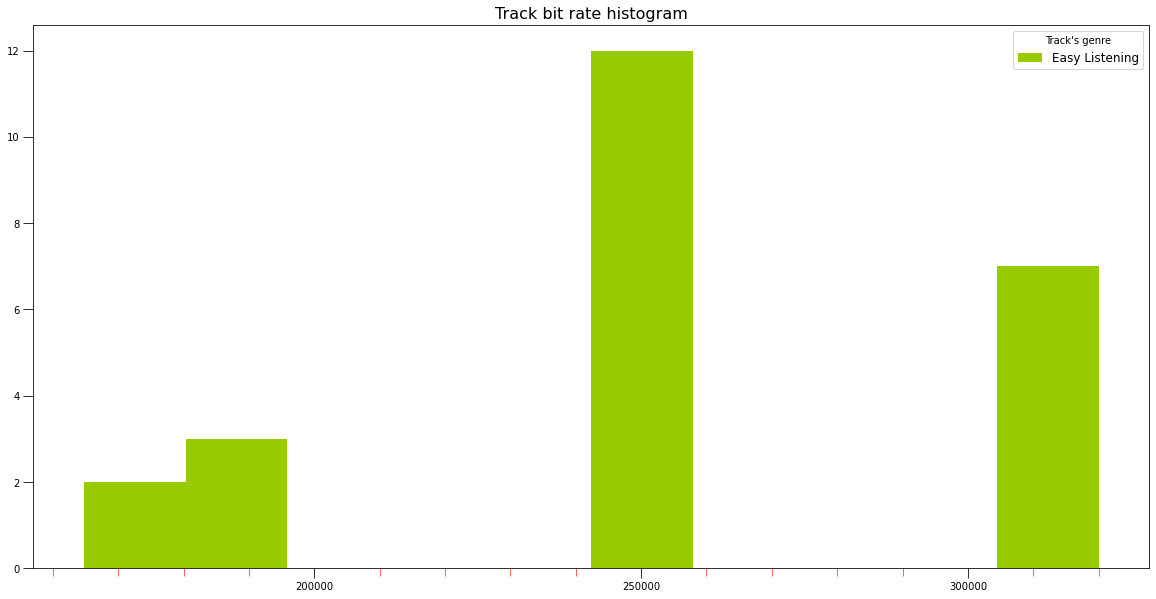

In [1443]:
colors = ['#0091C2', '#002EB8', '#CC0066', '#FF9124', '#668CFF', '#66CCFF', '#CCCC00', '#FFFF24', '#CC6600', 
          '#FF61B0', '#B061FF', '#CC6699', '#336600', '#52A300', '#70E000', '#99CC00']

for i, genre in enumerate(tracks_all_genres_full['track_genre_top'].dropna().unique()):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
    color = colors[i]

    distrib = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]['track_bit_rate']
    ax.hist(distrib, label = genre, color = color)
    ax.legend(loc='upper right', title = "Track's genre", frameon=True, fontsize = 12)
    ax.set_title('Track bit rate' + " histogram", fontsize = 16)
            
    
    ax.xaxis.set_major_locator(MultipleLocator(50000))
    ax.xaxis.set_minor_locator(MultipleLocator(10000))
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=8, color='r')

    plt.show()

<h3>Track year created</h3>

In [2067]:
for genre in genre_unique:
    print(genre)
    print()
    dfc = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]
    print(dfc['track_year_created'].describe())
    print('------------------------------------')

Hip-Hop

count    3552.000000
mean     2012.609797
std         2.411555
min      2008.000000
25%      2011.000000
50%      2013.000000
75%      2014.000000
max      2017.000000
Name: track_year_created, dtype: float64
------------------------------------
Pop

count    2332.000000
mean     2012.522298
std         2.488743
min      2008.000000
25%      2010.000000
50%      2012.000000
75%      2015.000000
max      2017.000000
Name: track_year_created, dtype: float64
------------------------------------
Rock

count    14182.000000
mean      2011.943238
std          2.621443
min       2008.000000
25%       2010.000000
50%       2012.000000
75%       2014.000000
max       2017.000000
Name: track_year_created, dtype: float64
------------------------------------
Experimental

count    10608.000000
mean      2012.307598
std          2.433064
min       2008.000000
25%       2010.000000
50%       2012.000000
75%       2014.000000
max       2017.000000
Name: track_year_created, dtype: float64
---

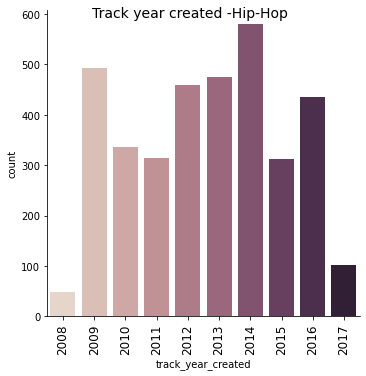

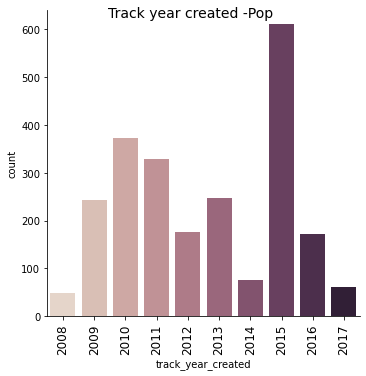

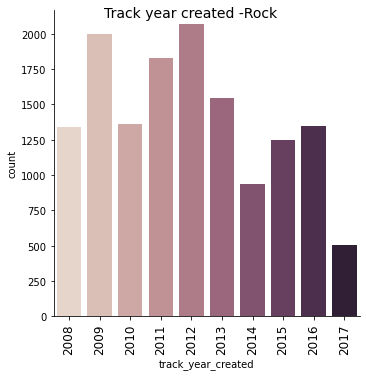

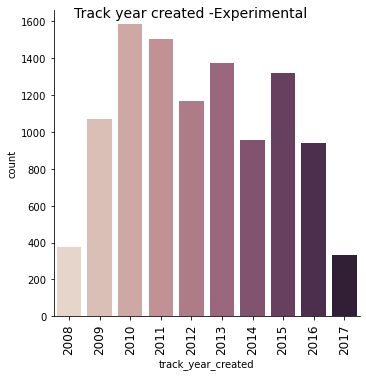

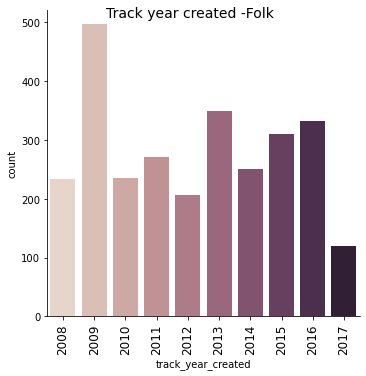

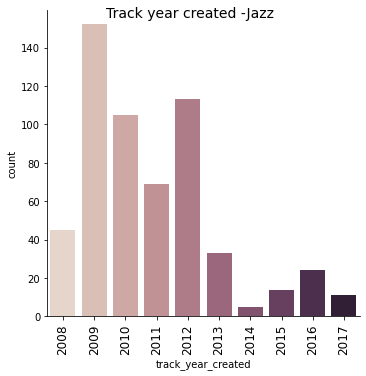

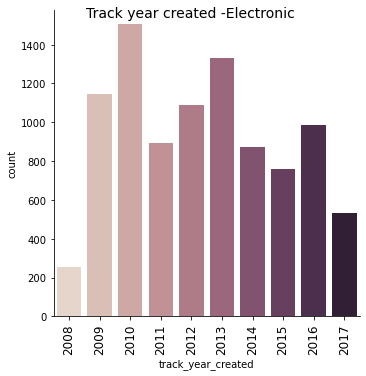

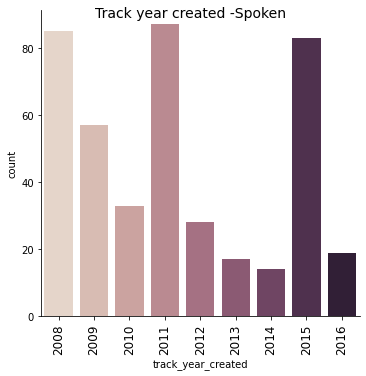

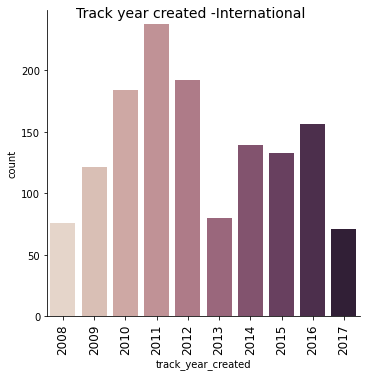

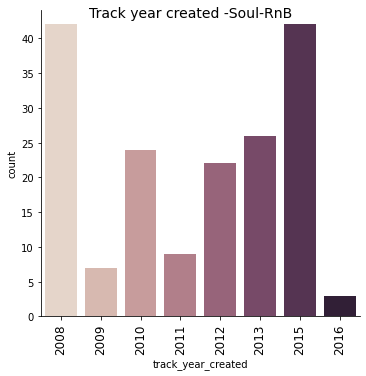

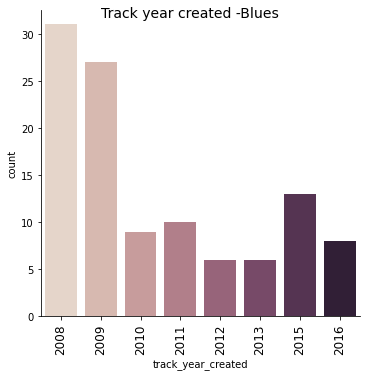

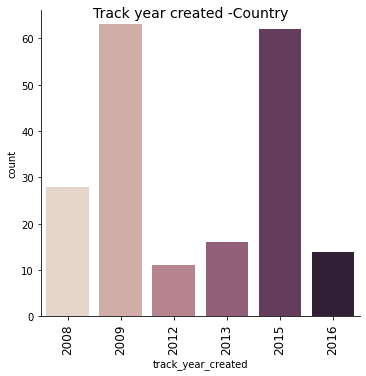

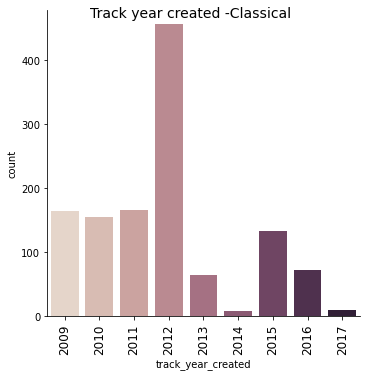

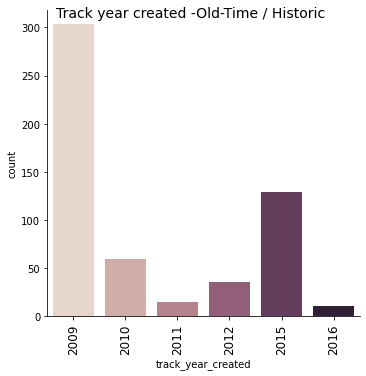

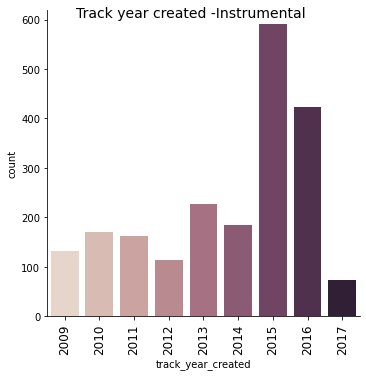

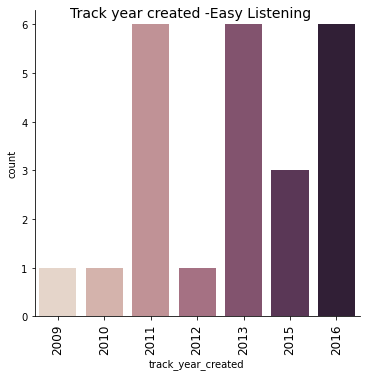

In [2068]:
for genre in genre_unique:
    df = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]
    list_y = [year for year in df['track_year_created'].dropna().unique()]
    
    ax = sns.catplot(x = "track_year_created", data = df, kind = 'count', palette="ch:.15")
    ax.set_xticklabels(rotation=90, fontsize = 12)
    ax.fig.suptitle("Track year created -{}".format(genre), fontsize = 14)
    
    plt.show()

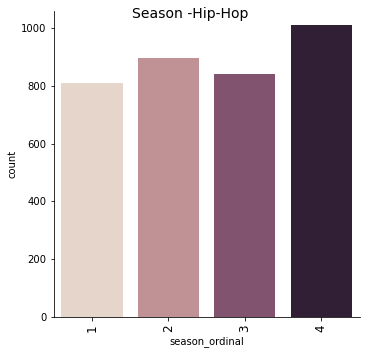

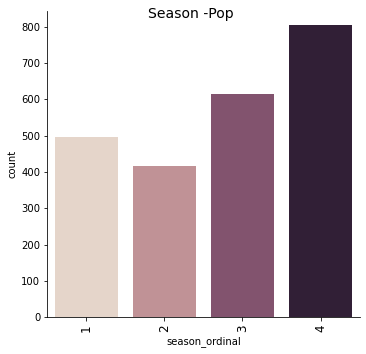

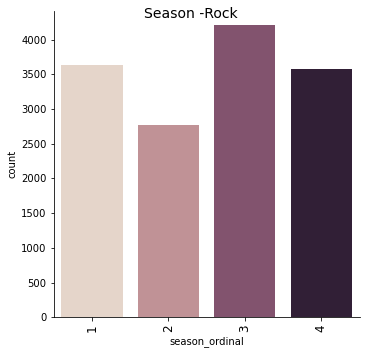

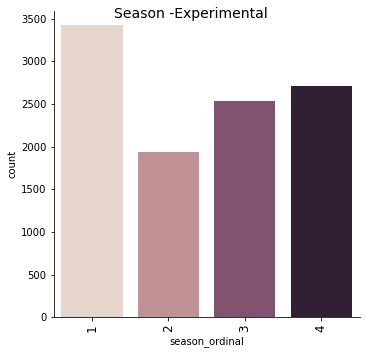

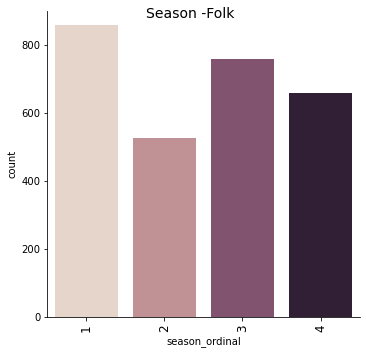

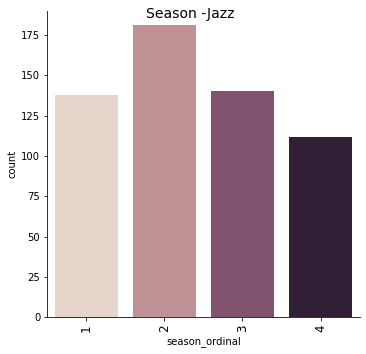

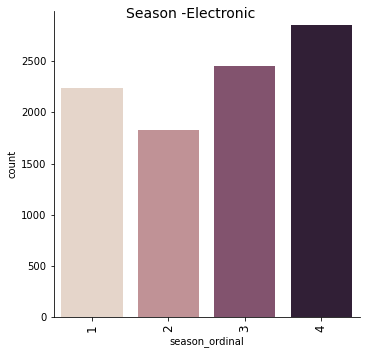

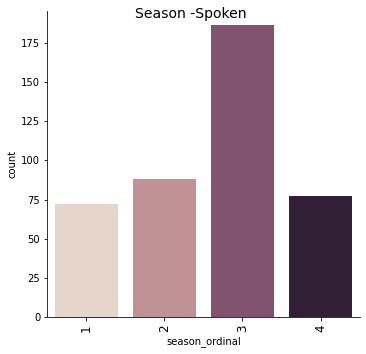

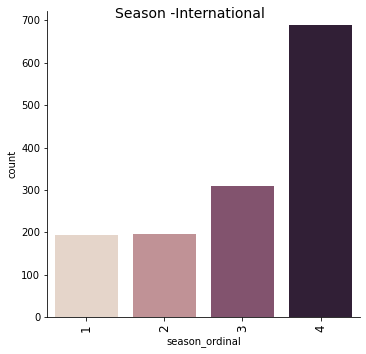

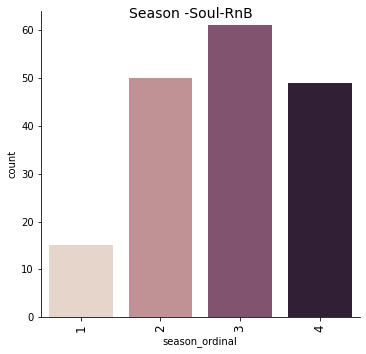

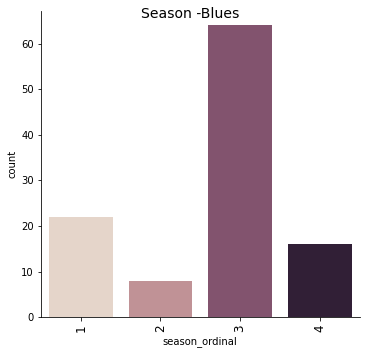

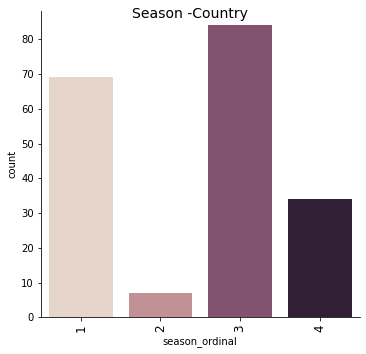

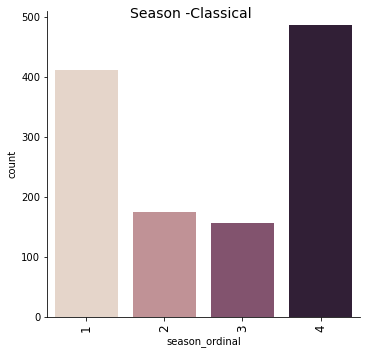

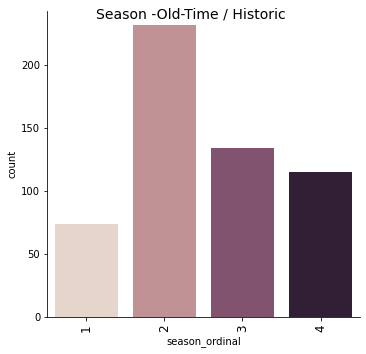

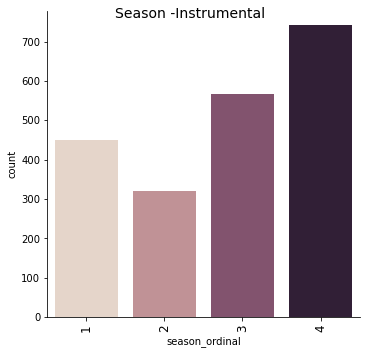

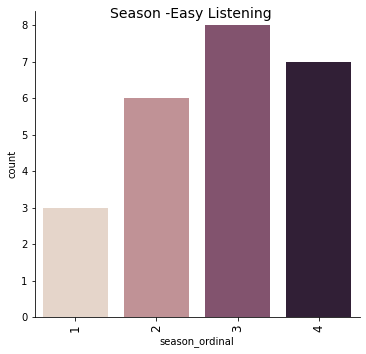

In [2069]:
for genre in genre_unique:
    df = tracks_all_genres_full[tracks_all_genres_full['track_genre_top'] == genre]
    list_s = [s for s in df['season_ordinal'].dropna().unique()]
    
    ax = sns.catplot(x = "season_ordinal", data = df, kind = 'count', palette="ch:.15")
    ax.set_xticklabels(rotation=90, fontsize = 12)
    ax.fig.suptitle("Season -{}".format(genre), fontsize = 14)
    
    plt.show()

<h1>Dataset Features</h1>

In [1449]:
df_features = pd.read_csv("features.csv")

In [1450]:
df_features

,feature,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,statistics,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,...,std,std,std,kurtosis,max,mean,median,min,skew,std
1,number,01,02,03,04,05,06,07,08,09,...,04,05,06,01,01,01,01,01,01,01
2,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,7.1806526184e+00,5.2303090096e+00,2.4932080507e-01,1.3476201296e+00,1.4824777842e+00,5.3137123585e-01,1.4815930128e+00,2.6914546490e+00,8.6686819792e-01,...,5.4125156254e-02,1.2225749902e-02,1.2110591866e-02,5.7588901520e+00,4.5947265625e-01,8.5629448295e-02,7.1289062500e-02,0.0000000000e+00,2.0898721218e+00,6.1448108405e-02
4,3,1.8889633417e+00,7.6053929329e-01,3.4529656172e-01,2.2952005863e+00,1.6540306807e+00,6.7592434585e-02,1.3668476343e+00,1.0540937185e+00,1.0810308903e-01,...,6.3831120729e-02,1.4211839065e-02,1.7740072682e-02,2.8246941566e+00,4.6630859375e-01,8.4578499198e-02,6.3964843750e-02,0.0000000000e+00,1.7167237997e+00,6.9330163300e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106572,155316,-0.490129,0.463834,2.32197,-0.0843522,1.66291,2.11519,-0.237794,5.69544,0.830353,...,0.12841,0.0225471,0.0198161,4.44826,0.172852,0.0287726,0.0283203,0.00390625,0.955388,0.0123847
106573,155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.0826865,-0.229483,...,0.132964,0.0235476,0.0265269,3.27061,0.196289,0.031116,0.027832,0.00244141,1.28306,0.0190591
106574,155318,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.71353,1.41844,1.3252,...,0.108324,0.0175401,0.0204714,2.35673,0.212891,0.0384498,0.0371094,0.00341797,0.828569,0.0179043
106575,155319,-0.176901,0.187208,-0.0506639,0.368843,0.0660052,-0.857354,-0.78086,0.626281,-0.630938,...,0.0883108,0.0183284,0.017936,6.1886,0.16748,0.04148,0.0380859,0.00488281,1.81874,0.0201334


In [1451]:
for i, column in enumerate (df_features.columns):
    col = column
    if "." in col:
        col = col.replace(".", "_")
    else :
        col = col + "_"   
        
    col = hasNumbers(col)  #it checks if there are numbers in the column's name: if yes it replaces these with ""
    col = col + str(df_features.iloc[0][column]) + "_" + str(df_features.iloc[1][column])

    df_features = df_features.rename({column: col}, axis = 1)

In [1452]:
new_name = df_features.iloc[2]['feature_statistics_number']
df_features = df_features.rename({'feature_statistics_number': new_name}, axis = 1)

In [1453]:
df_features = df_features.iloc[3:]
df_features = df_features.reset_index(drop=True)

In [1454]:
df_features.head(10)

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.1806526184e+00,5.2303090096e+00,2.4932080507e-01,1.3476201296e+00,1.4824777842e+00,5.3137123585e-01,1.4815930128e+00,2.6914546490e+00,8.6686819792e-01,...,5.4125156254e-02,1.2225749902e-02,1.2110591866e-02,5.7588901520e+00,4.5947265625e-01,8.5629448295e-02,7.1289062500e-02,0.0000000000e+00,2.0898721218e+00,6.1448108405e-02
1,3,1.8889633417e+00,7.6053929329e-01,3.4529656172e-01,2.2952005863e+00,1.6540306807e+00,6.7592434585e-02,1.3668476343e+00,1.0540937185e+00,1.0810308903e-01,...,6.3831120729e-02,1.4211839065e-02,1.7740072682e-02,2.8246941566e+00,4.6630859375e-01,8.4578499198e-02,6.3964843750e-02,0.0000000000e+00,1.7167237997e+00,6.9330163300e-02
2,5,5.2756297588e-01,-7.7654317021e-02,-2.7961030602e-01,6.8588310480e-01,1.9375696182e+00,8.8083887100e-01,-9.2319184542e-01,-9.2723226547e-01,6.6661673784e-01,...,4.0730185807e-02,1.2690781616e-02,1.4759079553e-02,6.8084154129e+00,3.7500000000e-01,5.3114086390e-02,4.1503906250e-02,0.0000000000e+00,2.1933031082e+00,4.4860601425e-02
3,10,3.7022454739e+00,-2.9119303823e-01,2.1967420578e+00,-2.3444947600e-01,1.3673638105e+00,9.9841135740e-01,1.7706941366e+00,1.6045658588e+00,5.2121698856e-01,...,7.4357867241e-02,1.7951935530e-02,1.3921394013e-02,2.1434211731e+01,4.5214843750e-01,7.7514506876e-02,7.1777343750e-02,0.0000000000e+00,3.5423245430e+00,4.0800448507e-02
4,20,-1.9383698702e-01,-1.9852678478e-01,2.0154602826e-01,2.5855624676e-01,7.7520370483e-01,8.4794059396e-02,-2.8929358721e-01,-8.1641042233e-01,4.3850939721e-02,...,9.5002755523e-02,2.2492416203e-02,2.1355332807e-02,1.6669036865e+01,4.6972656250e-01,4.7224905342e-02,4.0039062500e-02,9.7656250000e-04,3.1898307800e+00,3.0992921442e-02
5,26,-6.9953453541e-01,-6.8415790796e-01,4.8824872822e-02,4.2658798397e-02,-8.1896692514e-01,-9.1712284088e-01,-9.0183424950e-01,-6.6844828427e-02,-2.9103723168e-01,...,1.0371652246e-01,2.5541320443e-02,2.3846302181e-02,4.1645809174e+01,2.5048828125e-01,1.8387714401e-02,1.5625000000e-02,0.0000000000e+00,4.6905956268e+00,1.4598459937e-02
6,30,-7.2148716450e-01,-8.4855991602e-01,8.9090377092e-01,8.8619679213e-02,-4.4551330805e-01,-1.2711701393e+00,-1.2401897907e+00,-1.3437650204e+00,-9.0560036898e-01,...,1.4169253409e-01,2.0426128060e-02,2.5417611003e-02,8.1665945053e+00,5.4687500000e-01,5.4416511208e-02,3.6132812500e-02,2.4414062500e-03,2.2447082996e+00,5.2673552185e-02
7,46,-1.1970755458e-01,-8.5881441832e-01,2.3625464439e+00,1.0658428818e-01,-1.3159115314e+00,-1.2203541994e+00,-1.6681618690e+00,-5.1603251696e-01,-5.3639507294e-01,...,1.3263167441e-01,3.3211655915e-02,2.1309997886e-02,1.4731082916e+01,2.2363281250e-01,3.6600999534e-02,3.2226562500e-02,0.0000000000e+00,2.8487360477e+00,2.0713411272e-02
8,48,-1.0540534258e+00,9.3233942986e-01,5.2806353569e-01,-1.0353376865e+00,-1.0006815195e+00,-1.1193039417e+00,1.1669902802e+00,-1.0026028156e+00,-1.0949990749e+00,...,1.4195451140e-01,2.4653503671e-02,2.5202710181e-02,2.4550788879e+01,3.7158203125e-01,3.3015336841e-02,2.2460937500e-02,0.0000000000e+00,4.4067325592e+00,3.9016269147e-02
9,134,9.1844475269e-01,6.7414724827e-01,5.7781827450e-01,1.2811170816e+00,9.3374562263e-01,7.8176945448e-02,1.1992042065e+00,-1.7522314191e-01,9.2548191547e-01,...,5.8766160160e-02,1.6322381794e-02,1.5819497406e-02,4.7310867310e+00,4.1943359375e-01,6.4369551837e-02,5.0781250000e-02,0.0000000000e+00,1.8061059713e+00,5.4622855037e-02


In [1455]:
FeatureMissValcount = 0

for i, value in (df_features.isnull().sum().items()):
    if value!=0:
        FeatureMissValcount+=1
        print("{0:23} {1}".format(i, value))
        
print("{} features with missing values".format(FeatureMissValcount))

0 features with missing values


In [1456]:
for column in df_features.columns:
    if not ("mean" in column):
        df_features = df_features.drop(column, axis = 1)

In [1519]:
for column in df_features.columns:
    df_features[column] = df_features[column].astype(float)

In [1520]:
df_features.info(verbose = True, max_cols = 300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 74 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   chroma_cens_mean_01         106574 non-null  float64
 1   chroma_cens_mean_02         106574 non-null  float64
 2   chroma_cens_mean_03         106574 non-null  float64
 3   chroma_cens_mean_04         106574 non-null  float64
 4   chroma_cens_mean_05         106574 non-null  float64
 5   chroma_cens_mean_06         106574 non-null  float64
 6   chroma_cens_mean_07         106574 non-null  float64
 7   chroma_cens_mean_08         106574 non-null  float64
 8   chroma_cens_mean_09         106574 non-null  float64
 9   chroma_cens_mean_10         106574 non-null  float64
 10  chroma_cens_mean_11         106574 non-null  float64
 11  chroma_cens_mean_12         106574 non-null  float64
 12  chroma_cqt_mean_01          106574 non-null  float64
 13  chroma_cqt_mea

We want to perform a statistical test to find out if there is a statistically significant difference between the columns of the same category.
To compare columns that belong to the same category, we create a list in which we store the individual categories.

In [1683]:
categories_list = []

for i, col in enumerate(df_features.columns):

    col_name = df_features.columns[i]
    
    for char in col_name:
        if char.isdigit():
            col_name = col_name.replace(char, "")

    col_name = col_name[:-1]
    
    if col_name not in categories_list:
        categories_list.append(col_name)
        
print(len(categories_list))
print(categories_list)

11
['chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean', 'mfcc_mean', 'rmse_mean', 'spectral_bandwidth_mean', 'spectral_centroid_mean', 'spectral_contrast_mean', 'spectral_rolloff_mean', 'tonnetz_mean', 'zcr_mean']


Before applying a statistical test, we must verify if our data are normally distributed or not, as, in the first case, we can apply parametric statistical tests, in the second, instead, we must use non-parametric tests.

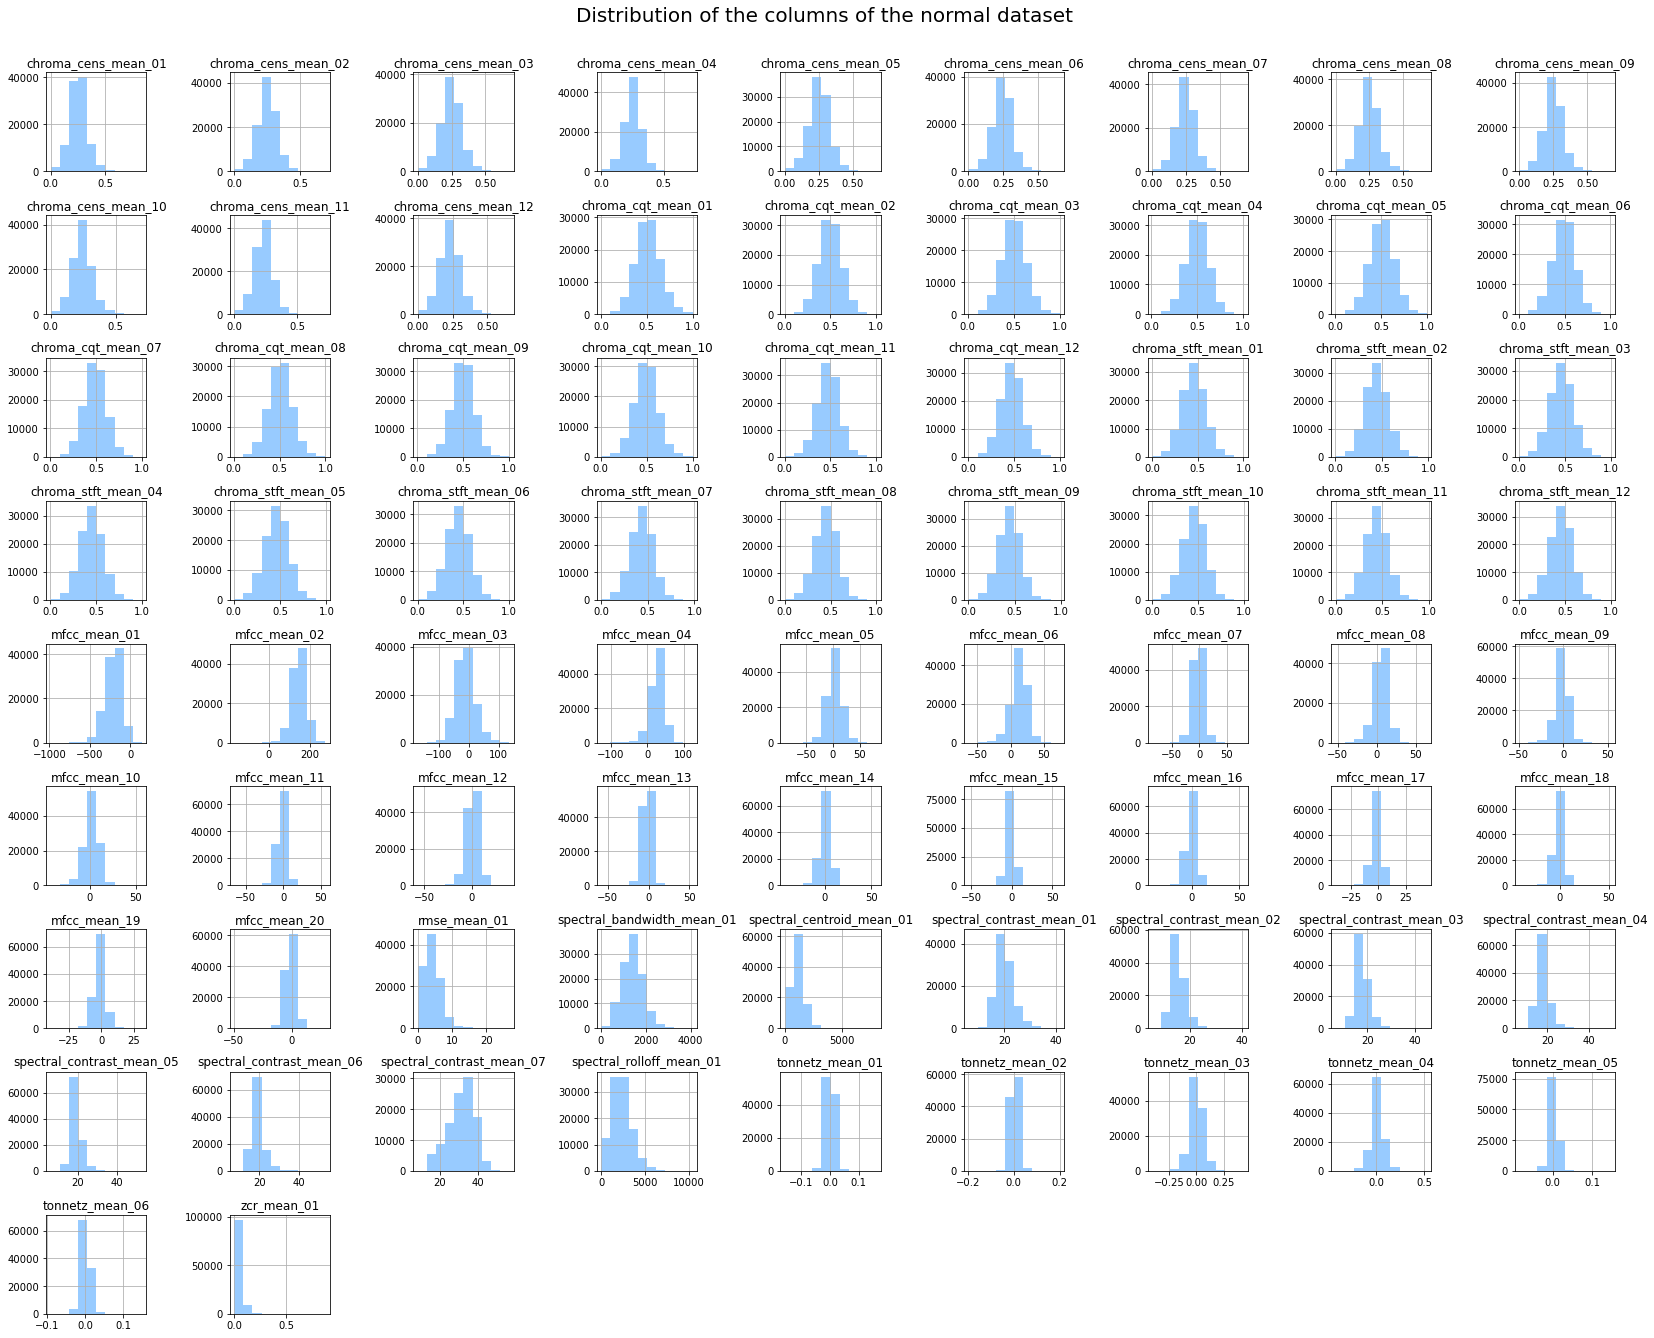

In [1817]:
df_features.hist(alpha = 0.5, figsize = (23, 18), color = '#3399FF')
plt.suptitle("Distribution of the columns of the normal dataset", y = 1.03, fontsize = 20)
plt.tight_layout()
plt.show()

Let's check if the distribution of the data is similar to a Gaussian with <b>shapiro</b>, <b>normaltest</b> and <b>kstest</b> methods.

In [1684]:
for column_name in df_features.columns:
    data = df_features[column_name]
    test_stat, pvalue = shapiro(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

In [1701]:
for column_name in features_trans.columns:
    data = features_trans[column_name]
    test_stat, pvalue = normaltest(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

In [1702]:
for column_name in features_trans.columns:
    data = features_trans[column_name]
    test_stat, pvalue = kstest(data, 'norm')
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

Since we have seen that our data do not demonstrate a normal distribution, we need to apply a non-parametric statistical test.

**scipy.stats.mannwhitneyu** compute the Mann-Whitney rank test on samples x and y.

We apply the Mann-Whitney U test (nonparametric version of 2-sample T-test).

In [1691]:
total_list = []

for category in categories_list:
    temp_list = []
    for column in df_features.columns:
        if category in column:
            temp_list.append(column)
    
    if (len(temp_list) > 1):
        print("- ", category, "(", temp_list[0], "-", temp_list[-1], ")")
        candidate_list = []
        for i in range(len(temp_list)):
            for j in range(i+1, len(temp_list)):
                data1 = df_features[temp_list[i]]
                data2 = df_features[temp_list[j]]
                test_stat, pvalue = mannwhitneyu(data1, data2)
                if pvalue > 0.05:
                    print("No statistically significative difference between {} and {}".format(temp_list[i], temp_list[j]))
                    if temp_list[i] not in candidate_list:
                        candidate_list.append(temp_list[j])
        
        if candidate_list:
            print(candidate_list)
            total_list.append(candidate_list)
        print()
        print()
        
total_list = [item for sublist in total_list for item in sublist]        
print("Columns that can be deleted %d" %len(total_list))

-  chroma_cens_mean ( chroma_cens_mean_01 - chroma_cens_mean_12 )
No statistically significative difference between chroma_cens_mean_02 and chroma_cens_mean_04
No statistically significative difference between chroma_cens_mean_02 and chroma_cens_mean_08
No statistically significative difference between chroma_cens_mean_04 and chroma_cens_mean_08
No statistically significative difference between chroma_cens_mean_08 and chroma_cens_mean_09
['chroma_cens_mean_04', 'chroma_cens_mean_08']


-  chroma_cqt_mean ( chroma_cqt_mean_01 - chroma_cqt_mean_12 )
No statistically significative difference between chroma_cqt_mean_02 and chroma_cqt_mean_04
No statistically significative difference between chroma_cqt_mean_02 and chroma_cqt_mean_09
No statistically significative difference between chroma_cqt_mean_04 and chroma_cqt_mean_09
No statistically significative difference between chroma_cqt_mean_06 and chroma_cqt_mean_10
['chroma_cqt_mean_04', 'chroma_cqt_mean_09', 'chroma_cqt_mean_10']


-  chroma

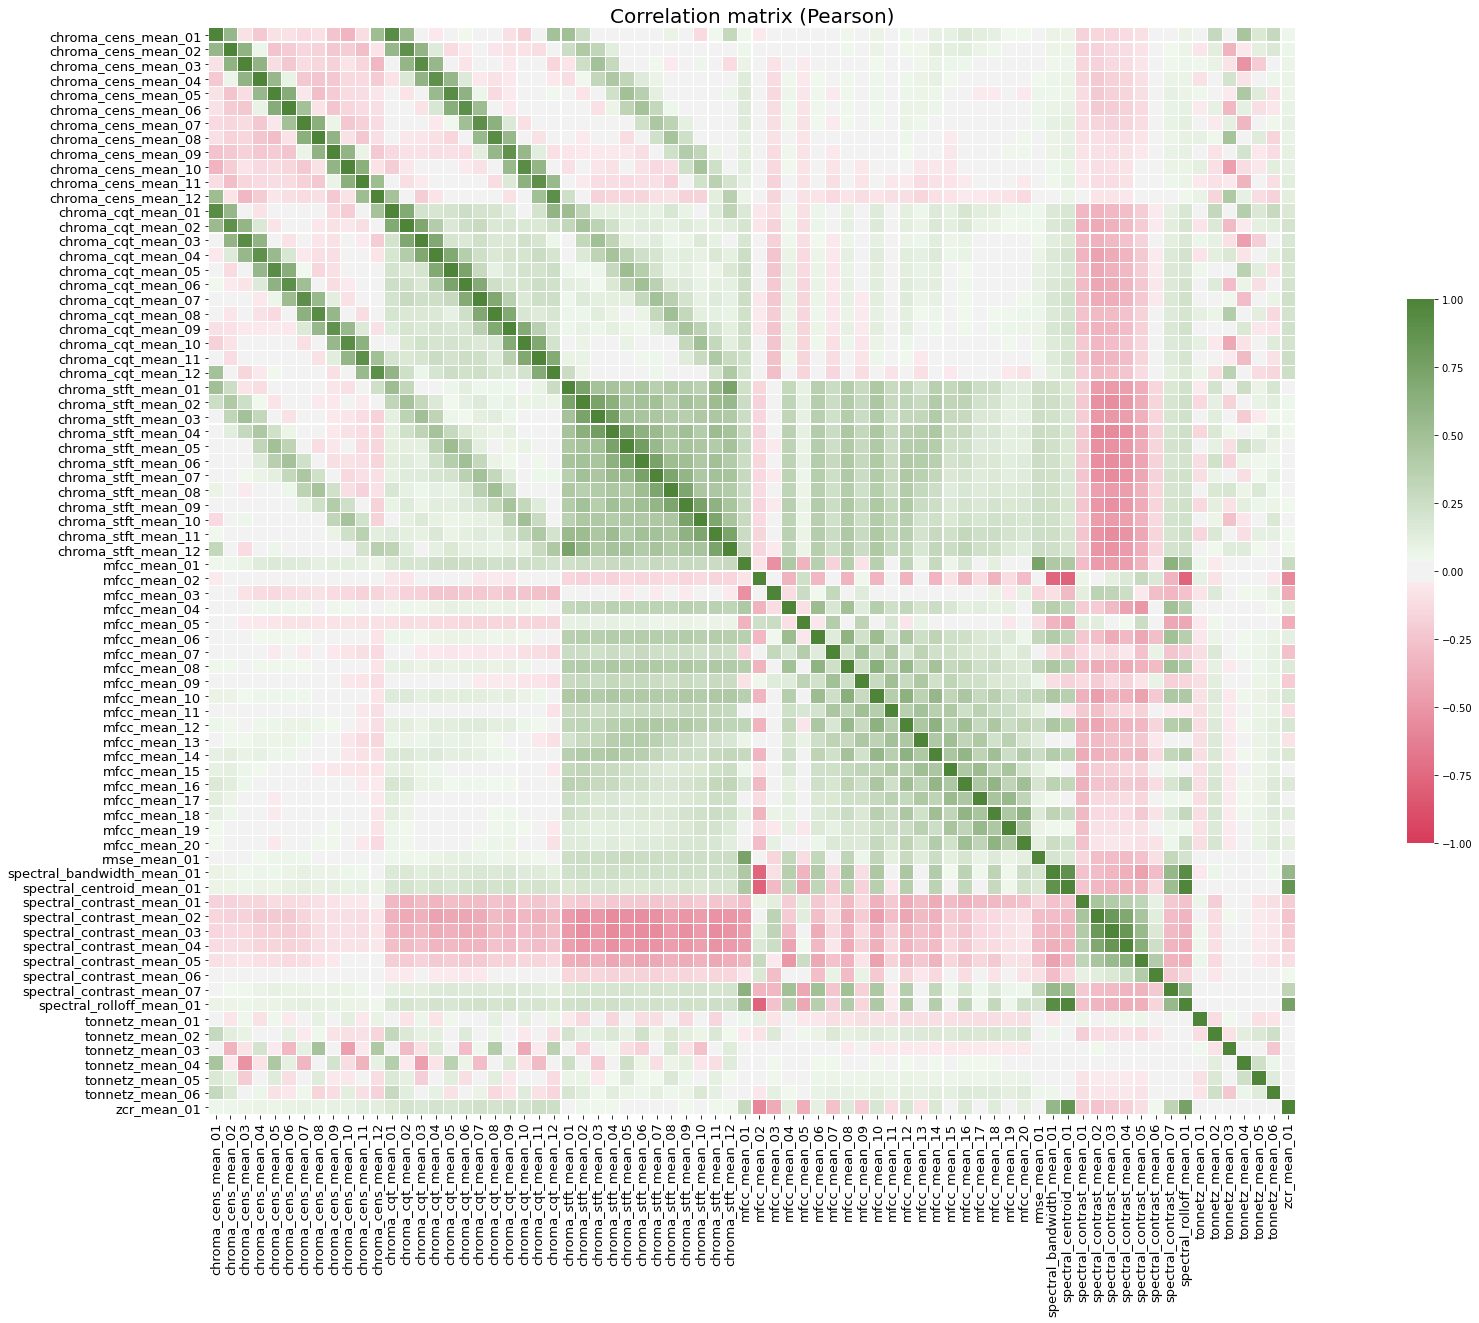

In [1870]:
correlation_matrix = df_features.corr('pearson')

plot_correlation_matrix(correlation_matrix, "Correlation matrix (Pearson)")

In [1848]:
cm = df_features.corr("pearson")
cm

,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,...,spectral_contrast_mean_06,spectral_contrast_mean_07,spectral_rolloff_mean_01,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,zcr_mean_01
chroma_cens_mean_01,1.000000,0.570877,-0.090188,-0.220442,-0.089897,-0.086418,-0.128188,-0.101012,-0.256029,-0.331387,...,-0.021136,0.032735,0.081299,-0.033519,0.295931,0.034493,0.457571,0.174345,0.291743,0.056846
chroma_cens_mean_02,0.570877,1.000000,0.605972,0.068273,-0.255596,-0.203147,-0.147609,-0.179125,-0.233258,-0.196236,...,-0.017839,0.040824,0.077952,-0.070194,0.122368,-0.338726,-0.048437,0.115133,0.171357,0.065165
chroma_cens_mean_03,-0.090188,0.605972,1.000000,0.599740,-0.116448,-0.228623,-0.120135,-0.149659,-0.186378,-0.073952,...,-0.013288,0.047815,0.067790,0.054322,0.090601,-0.083396,-0.518649,-0.206708,0.022150,0.072202
chroma_cens_mean_04,-0.220442,0.068273,0.599740,1.000000,0.563020,0.086259,-0.229043,-0.245119,-0.229549,-0.140507,...,-0.022130,0.080650,0.083912,-0.091690,0.038720,0.215597,-0.080269,-0.030780,0.063263,0.082310
chroma_cens_mean_05,-0.089897,-0.255596,-0.116448,0.563020,1.000000,0.670305,-0.055413,-0.278740,-0.210031,-0.121316,...,-0.026027,0.094478,0.078613,0.053987,0.008502,-0.043292,0.430669,0.139945,-0.092660,0.073838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tonnetz_mean_03,0.034493,-0.338726,-0.083396,0.215597,-0.043292,-0.319135,0.106087,0.469310,0.012783,-0.449734,...,0.016120,-0.012349,-0.009697,0.045091,-0.081199,1.000000,0.023050,0.026068,-0.227019,0.014417
tonnetz_mean_04,0.457571,-0.048437,-0.518649,-0.080269,0.430669,0.107713,-0.323901,-0.020554,0.205277,-0.113024,...,-0.012252,0.005823,-0.000989,-0.011028,0.120407,0.023050,1.000000,0.240383,0.064154,-0.031493
tonnetz_mean_05,0.174345,0.115133,-0.206708,-0.030780,0.139945,-0.109125,-0.038110,0.135580,-0.047230,-0.059105,...,-0.022216,0.013012,0.012567,-0.094173,0.171130,0.026068,0.240383,1.000000,0.136460,-0.026787
tonnetz_mean_06,0.291743,0.171357,0.022150,0.063263,-0.092660,-0.060868,0.053165,-0.157641,-0.111552,0.121817,...,-0.038141,0.023491,0.035069,-0.073774,0.241285,-0.227019,0.064154,0.136460,1.000000,-0.037025


In [1873]:
corr_tab = []
headers = ("Col1", "Col2", "Correlation")

for i in range(len(cm.columns)):
    for j in range(i):
        if (cm.iloc[i, j] >= 0.5):
            corr_tab.append((cm.columns[i], cm.columns[j], cm.iloc[i, j]))
            

print(tabulate(corr_tab, headers, tablefmt = "grid", colalign = ("left", "left", "left")))

+---------------------------+----------------------------+---------------+
| Col1                      | Col2                       | Correlation   |
+===========================+============================+===============+
| chroma_cens_mean_02       | chroma_cens_mean_01        | 0.570877      |
+---------------------------+----------------------------+---------------+
| chroma_cens_mean_03       | chroma_cens_mean_02        | 0.605972      |
+---------------------------+----------------------------+---------------+
| chroma_cens_mean_04       | chroma_cens_mean_03        | 0.59974       |
+---------------------------+----------------------------+---------------+
| chroma_cens_mean_05       | chroma_cens_mean_04        | 0.56302       |
+---------------------------+----------------------------+---------------+
| chroma_cens_mean_06       | chroma_cens_mean_05        | 0.670305      |
+---------------------------+----------------------------+---------------+
| chroma_cens_mean_08    

In [1874]:
corr_tab = []
headers = ("Col1", "Col2", "Correlation")

for i in range(len(cm.columns)):
    for j in range(i):
        if (cm.iloc[i, j] <= 0.5):
            count+=1
            corr_tab.append((cm.columns[i], cm.columns[j], cm.iloc[i, j]))
            

print(tabulate(corr_tab, headers, tablefmt = "grid", colalign = ("left", "left", "left")))

+----------------------------+----------------------------+---------------+
| Col1                       | Col2                       | Correlation   |
+============================+============================+===============+
| chroma_cens_mean_03        | chroma_cens_mean_01        | -0.090188     |
+----------------------------+----------------------------+---------------+
| chroma_cens_mean_04        | chroma_cens_mean_01        | -0.220442     |
+----------------------------+----------------------------+---------------+
| chroma_cens_mean_04        | chroma_cens_mean_02        | 0.0682735     |
+----------------------------+----------------------------+---------------+
| chroma_cens_mean_05        | chroma_cens_mean_01        | -0.0898974    |
+----------------------------+----------------------------+---------------+
| chroma_cens_mean_05        | chroma_cens_mean_02        | -0.255596     |
+----------------------------+----------------------------+---------------+
| chroma_cen

<h2>Attempt to make the distribution of variables more like a Gaussian</h2>

<h3>Power Transformer</h3>

Power Transformer apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, <b>PowerTransformer</b> supports the <b>Box-Cox</b> transform and the <b>Yeo-Johnson</b> transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.

Since <b>Box-Cox requires the input data to be strictly positive, while Yeo-Johnson supports both positive and negative data</b>, we check if there are values below 0 in our dataset.

In [1694]:
(df_features < 0).any().any()

True

Since in our dataset there are negative values, we use <b>Yeo-Johnson transform</b>.

We create a parallel dataset in which the columns have the transformed values.

In [1721]:
#retrieve just the numeric input values
x = df_features.values

# perform a yeo-johnson transform of the dataset
pt = PowerTransformer(method='yeo-johnson')
x_scaled = pt.fit_transform(x)

# convert the array back to a dataframe
features_trans = pd.DataFrame(x_scaled, columns = df_features.columns)

In [1722]:
df_features.shape

(106574, 74)

In [1723]:
features_trans.shape

(106574, 74)

<h4>Verify the distribution</h4>

Visual inspection can be done in a different way with Q-Q plots. The red straight line is the fitted theoretical Gaussian distribution function. <b>If the scatter plot is closer to the red straight line, it means that the data is very close to Gaussian distribution</b>. Deviation from the red line indicates that the data is most likely not Gaussian.

We see the graph of the first 12 columns of the dataset.

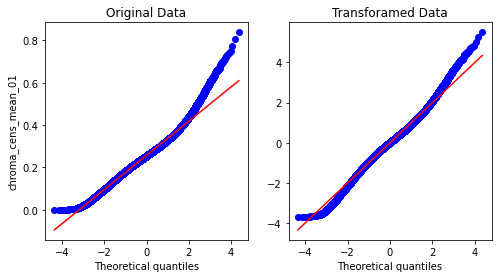

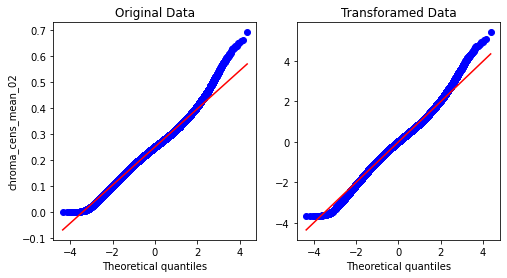

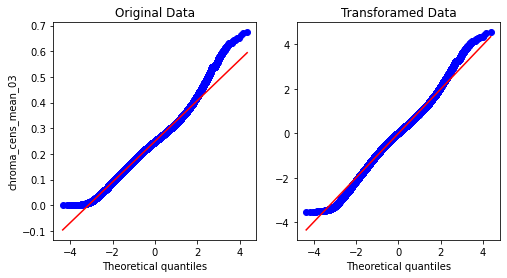

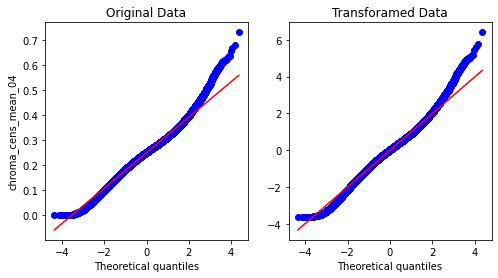

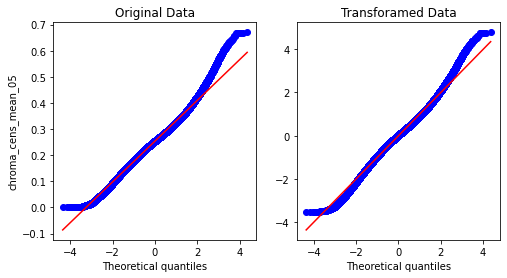

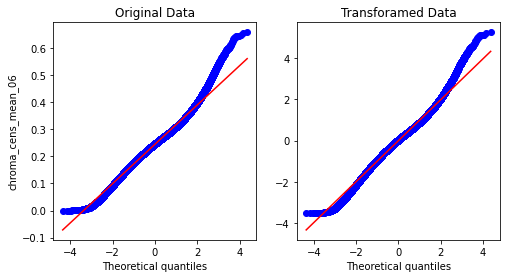

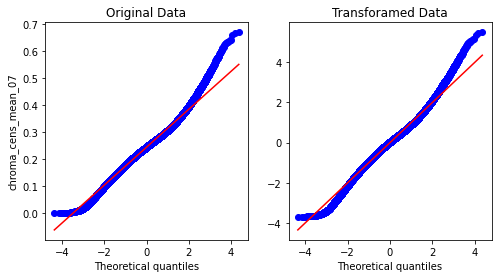

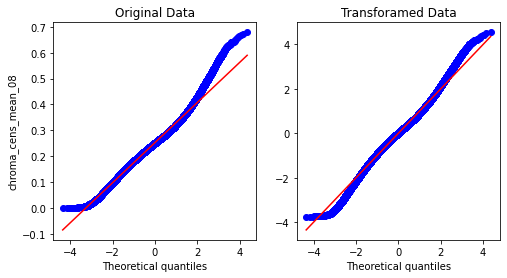

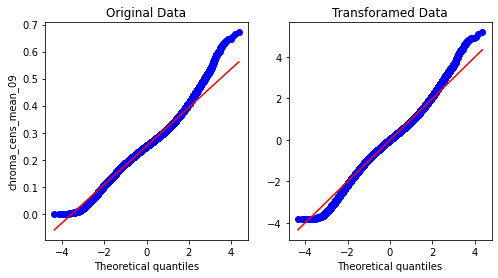

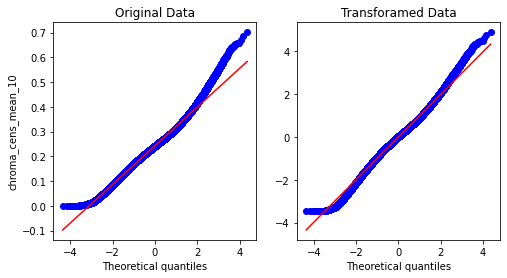

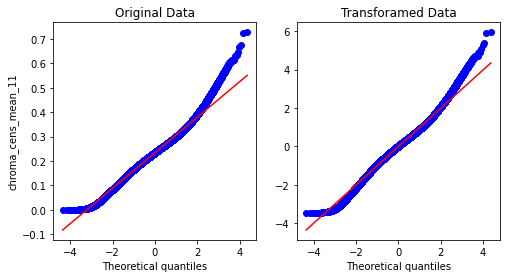

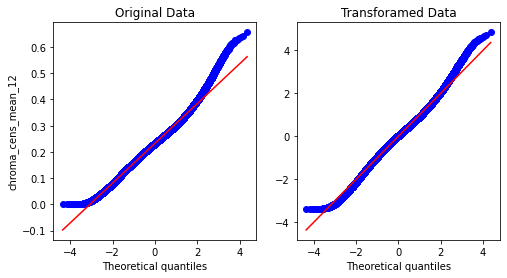

In [1724]:
for column in df_features.iloc[:, :12]:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    data_orig = df_features[column].values
    data_trans = features_trans[column].values
    
    prob = stats.probplot(data_orig, dist=stats.norm, plot=ax1)
    prob = stats.probplot(data_trans, dist=stats.norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('%s' % column)
    ax2.set_title('Transforamed Data');
    ax2.set_ylabel('');
    
    plt.show()

Let's check if the distribution of the data is now similar to a Gaussian with <b>shapiro</b>, <b>normaltest</b> and <b>kstest</b> methods.

In [1726]:
for column_name in features_trans.columns:
    data = features_trans[column_name]
    test_stat, pvalue = shapiro(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

In [1727]:
for column_name in features_trans.columns:
    data = features_trans[column_name]
    test_stat, pvalue = normaltest(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

In [1728]:
for column_name in features_trans.columns:
    data = features_trans[column_name]
    test_stat, pvalue = kstest(data, 'norm')
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))

**The data still appears to have a distribution that cannot be described as normal**.

We check with some histograms.

Now we visualize the difference between the distribution of the first 12 columns of the original dataset and the distribution of the transformed dataset.

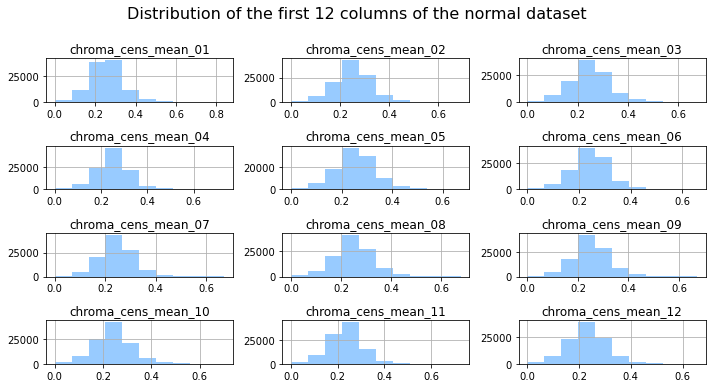

In [1756]:
part_df = pd.DataFrame(df_features.iloc[:, :12], columns = df_features.iloc[:, :12].columns)
part_df.hist(alpha = 0.5, figsize = (10, 5), color = '#3399FF')
plt.suptitle("Distribution of the first 12 columns of the normal dataset", y = 1.07, fontsize = 16)
plt.tight_layout()
plt.show()

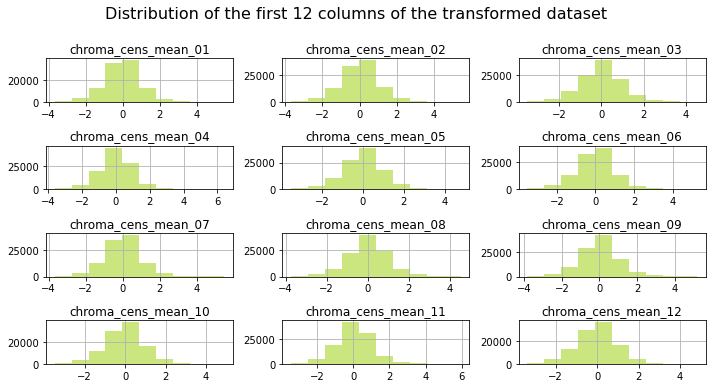

In [1757]:
part_df = pd.DataFrame(features_trans.iloc[:, :12], columns = features_trans.iloc[:, :12].columns)
part_df.hist(alpha = 0.5, figsize = (10, 5), color = '#99CC00')
plt.suptitle("Distribution of the first 12 columns of the transformed dataset", y = 1.07, fontsize = 16)
plt.tight_layout()
plt.show()

<h3>QuantileTransformer</h3>

QuantileTransformer transform features using quantiles information.

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

The transformation is applied on each feature independently. First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution. The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. 

<b>Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable</b>.

In [1732]:
#retrieve just the numeric input values
x = df_features.values

# perform a yeo-johnson transform of the dataset
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
x_scaled = quantile_transformer.fit_transform(x)

# convert the array back to a dataframe
features_trans_q = pd.DataFrame(x_scaled, columns = df_features.columns)

<h4>Verify the distribution</h4>

Let's check if the distribution of the data is now similar to a Gaussian with Q-Q plots.

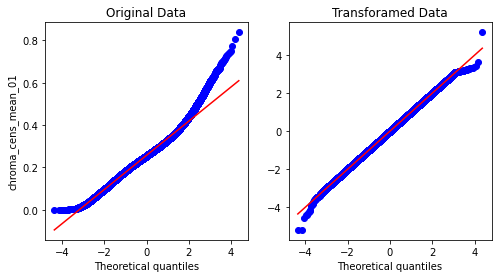

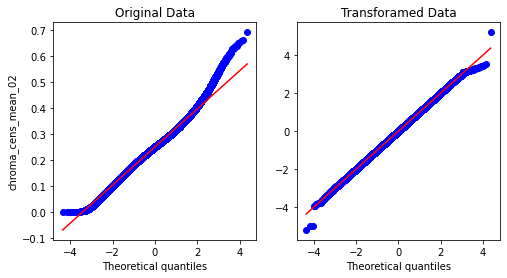

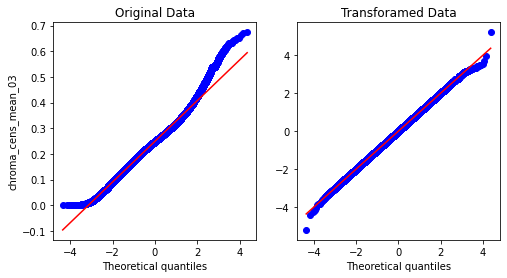

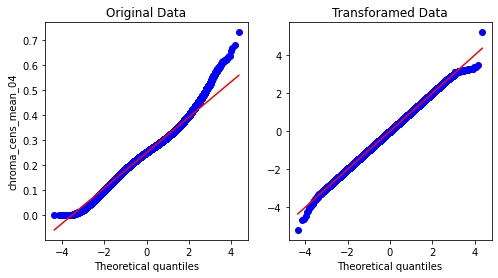

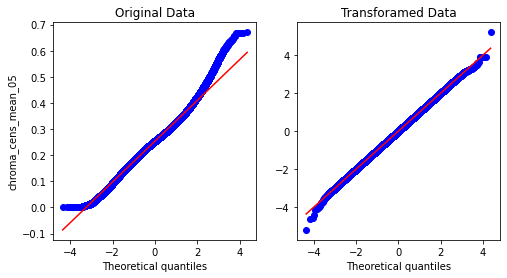

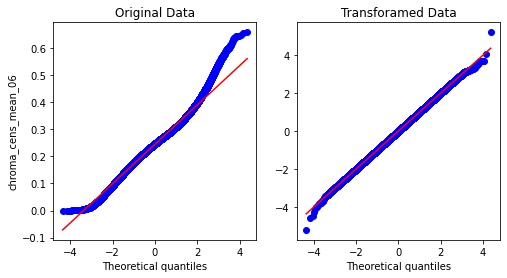

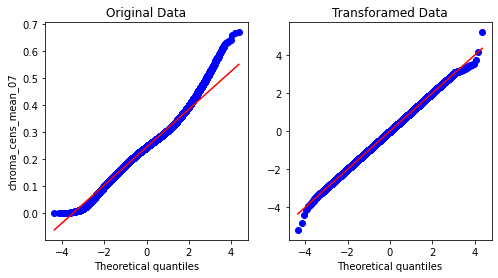

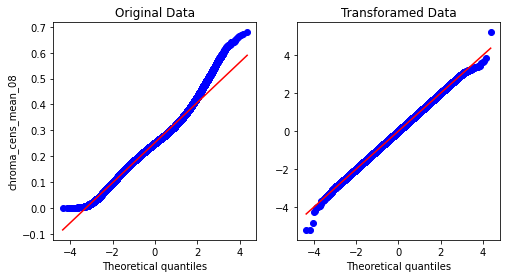

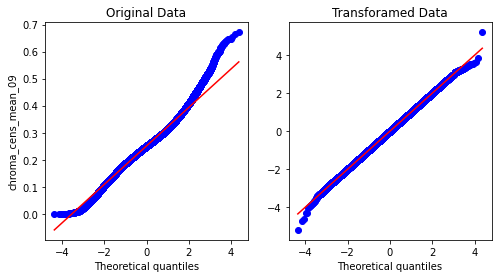

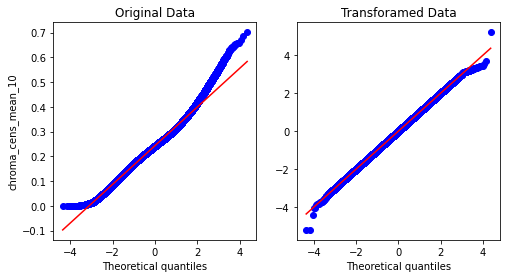

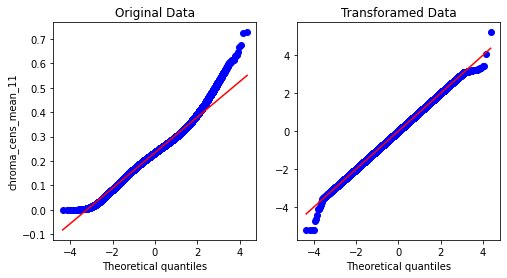

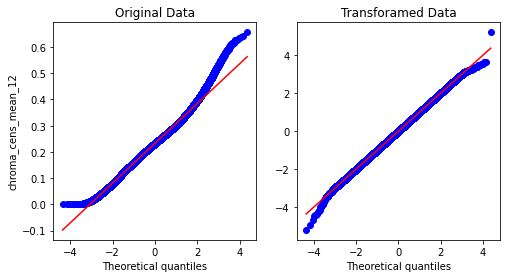

In [1733]:
for column in df_features.iloc[:, :12]:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    data_orig = df_features[column].values
    data_trans = features_trans_q[column].values
    
    prob = stats.probplot(data_orig, dist=stats.norm, plot=ax1)
    prob = stats.probplot(data_trans, dist=stats.norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('%s' % column)
    ax2.set_title('Transforamed Data');
    ax2.set_ylabel('');
    
    plt.show()

Let's check if the distribution of the data is now similar to a Gaussian with <b>shapiro</b>, <b>normaltest</b> and <b>kstest</b> methods.

In [1735]:
count = 0
for column_name in features_trans_q.columns:
    data = features_trans_q[column_name]
    test_stat, pvalue = shapiro(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))
        count+=1
print()
print("%s: %d normally distributed features" % (shapiro.__name__, count))

The column chroma_cens_mean_03 is taken from a normally distributed population
The column chroma_cens_mean_05 is taken from a normally distributed population
The column chroma_cens_mean_06 is taken from a normally distributed population
The column chroma_cens_mean_07 is taken from a normally distributed population
The column chroma_cens_mean_08 is taken from a normally distributed population
The column chroma_cens_mean_09 is taken from a normally distributed population
The column chroma_cens_mean_10 is taken from a normally distributed population
The column chroma_cqt_mean_01 is taken from a normally distributed population
The column chroma_cqt_mean_02 is taken from a normally distributed population
The column chroma_cqt_mean_03 is taken from a normally distributed population
The column chroma_cqt_mean_04 is taken from a normally distributed population
The column chroma_cqt_mean_05 is taken from a normally distributed population
The column chroma_cqt_mean_06 is taken from a normally di

In [1736]:
count = 0
for column_name in features_trans_q.columns:
    data = features_trans_q[column_name]
    test_stat, pvalue = normaltest(data)
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))
        count+=1
print()
print("%s: %d normally distributed features" % (normaltest.__name__, count))

The column chroma_cens_mean_01 is taken from a normally distributed population
The column chroma_cens_mean_02 is taken from a normally distributed population
The column chroma_cens_mean_03 is taken from a normally distributed population
The column chroma_cens_mean_04 is taken from a normally distributed population
The column chroma_cens_mean_05 is taken from a normally distributed population
The column chroma_cens_mean_06 is taken from a normally distributed population
The column chroma_cens_mean_07 is taken from a normally distributed population
The column chroma_cens_mean_08 is taken from a normally distributed population
The column chroma_cens_mean_09 is taken from a normally distributed population
The column chroma_cens_mean_10 is taken from a normally distributed population
The column chroma_cens_mean_11 is taken from a normally distributed population
The column chroma_cens_mean_12 is taken from a normally distributed population
The column chroma_cqt_mean_01 is taken from a normal

In [1737]:
count = 0
for column_name in features_trans_q.columns:
    data = features_trans_q[column_name]
    test_stat, pvalue = kstest(data, 'norm')
    if pvalue >= 0.05:
        print('The column {} is taken from a normally distributed population'.format(column_name))
        count+=1
print()
print("%s: %d normally distributed features" % (kstest.__name__, count))

The column chroma_cens_mean_01 is taken from a normally distributed population
The column chroma_cens_mean_02 is taken from a normally distributed population
The column chroma_cens_mean_03 is taken from a normally distributed population
The column chroma_cens_mean_04 is taken from a normally distributed population
The column chroma_cens_mean_05 is taken from a normally distributed population
The column chroma_cens_mean_06 is taken from a normally distributed population
The column chroma_cens_mean_07 is taken from a normally distributed population
The column chroma_cens_mean_08 is taken from a normally distributed population
The column chroma_cens_mean_09 is taken from a normally distributed population
The column chroma_cens_mean_10 is taken from a normally distributed population
The column chroma_cens_mean_11 is taken from a normally distributed population
The column chroma_cens_mean_12 is taken from a normally distributed population
The column chroma_cqt_mean_01 is taken from a normal

Now we visualize the difference between the distribution of the first 12 columns of the original dataset and the distribution of the transformed dataset.

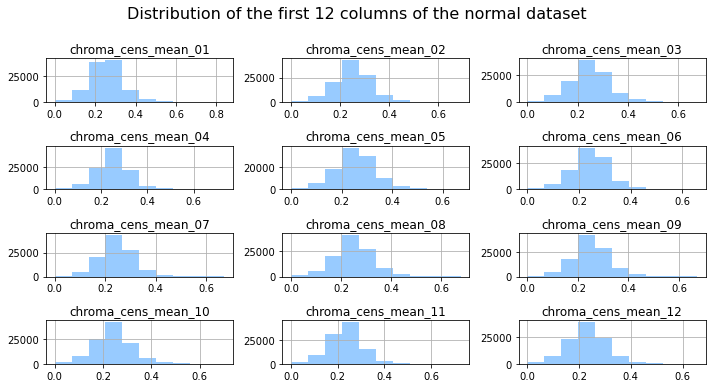

In [1754]:
part_df = pd.DataFrame(df_features.iloc[:, :12], columns = df_features.iloc[:, :12].columns)
part_df.hist(alpha = 0.5, figsize = (10, 5), color = '#3399FF')
plt.suptitle("Distribution of the first 12 columns of the normal dataset", y = 1.07, fontsize = 16)
plt.tight_layout()
plt.show()

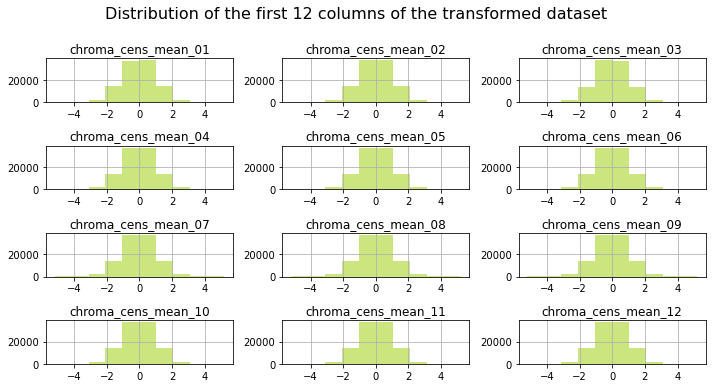

In [1755]:
part_df = pd.DataFrame(features_trans_q.iloc[:, :12], columns = features_trans_q.iloc[:, :12].columns)
part_df.hist(alpha = 0.5, figsize = (10, 5), color = '#99CC00')
plt.suptitle("Distribution of the first 12 columns of the transformed dataset", y = 1.07, fontsize = 16)
plt.tight_layout()
plt.show()

In [1758]:
features_trans_q

,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,...,spectral_contrast_mean_06,spectral_contrast_mean_07,spectral_rolloff_mean_01,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,zcr_mean_01
0,2.253525,1.624248,-0.188294,-0.385569,-0.446262,-0.384178,-0.260176,-0.027613,-0.851916,-0.924502,...,-0.441267,1.045556,0.881915,-0.287020,1.147974,0.257504,1.076196,0.867325,1.424042,1.288204
1,-0.320310,-0.335602,-0.332237,-0.557345,-0.478616,-0.057866,1.735142,1.935013,0.968673,0.010799,...,0.161921,1.235232,1.062960,-0.005710,0.282500,0.905246,-0.787089,1.580022,-0.395158,1.258320
2,0.051342,0.801689,0.028401,-0.530458,-0.123286,-0.163564,0.517787,0.654629,1.388737,0.703593,...,0.299237,0.693839,0.489552,-0.752694,-1.651717,-0.585909,0.259443,0.360737,-0.716011,0.253168
3,-0.361945,0.556596,-0.129405,-0.406232,-0.848732,0.694206,2.150673,1.302654,0.299115,0.017186,...,0.189251,0.422619,0.341164,-1.737778,-1.644081,-0.032880,-1.391302,0.836814,0.611963,1.072741
4,-0.733593,-0.100047,0.213546,-0.951063,-0.973616,-0.130621,0.564230,0.639591,-0.056089,0.738435,...,-1.086921,-1.519427,1.513145,1.063889,0.690903,-0.423255,-1.410250,0.531058,-1.030643,0.006763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,-1.235472,-1.207959,-0.893218,1.705012,2.614670,2.034322,-1.066804,-1.771235,-1.207059,-0.822391,...,-0.236627,0.359239,-0.482809,-0.294234,-1.738989,-0.282182,1.534955,-0.579998,-1.566887,-0.913716
106570,-1.448356,0.147557,1.764435,1.249459,-0.752504,-0.802675,-0.849932,-1.674812,-0.528607,1.204892,...,0.140927,-0.094049,-0.361679,-0.306312,-0.860094,-0.959465,-1.836316,-1.773054,1.034778,-0.776508
106571,-0.815157,-0.680525,0.049253,1.493414,1.873367,1.264832,-0.572294,-0.673778,-0.110366,-0.039169,...,-0.283986,0.425665,-0.052979,0.218378,-1.139398,0.282752,0.760631,-0.693042,-1.313026,-0.391702
106572,-0.167924,0.138707,0.049149,0.193534,0.800984,1.094641,0.873329,0.295003,0.363051,0.246612,...,-0.360633,0.733301,0.122629,0.626957,-0.934935,-0.497083,0.175981,-0.519168,0.013707,-0.244979


<h3>T-test</h3>

Since we know that now our data have a normal distribution, we can apply the <b>T-test</b>.

<b>scipy.stats.ttest_ind</b> calculate the <b>T-test for the means of two independent samples of scores</b>.

This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

Notes

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. 

If we observe a <b>large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores</b>. 

If the <b>p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages</b>.

In [1713]:
total_list = []

for category in categories_list:
    temp_list = []
    for column in features_trans_q.columns:
        if category in column:
            temp_list.append(column)
    
    if (len(temp_list) > 1):
        print("- ", category, "(", temp_list[0], "-", temp_list[-1], ")")
        candidate_list = []
        for i in range(len(temp_list)):
            for j in range(i+1, len(temp_list)):
                data1 = features_trans_q[temp_list[i]]
                data2 = features_trans_q[temp_list[j]]
                test_stat, pvalue = stats.ttest_ind(data1, data2)
                if pvalue > 0.05:
                    print("No statistically significative difference between {} and {}".format(temp_list[i], temp_list[j]))
                    if temp_list[i] not in candidate_list:
                        candidate_list.append(temp_list[j])
        
        if candidate_list:
            print(candidate_list)
            total_list.append(candidate_list)
        print()
        print()
        
total_list = [item for sublist in total_list for item in sublist]        
print("Columns that can be deleted %d" %len(total_list))

-  chroma_cens_mean ( chroma_cens_mean_01 - chroma_cens_mean_12 )
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_02
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_03
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_04
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_05
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_06
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_07
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_08
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_09
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_mean_10
No statistically significative difference between chroma_cens_mean_01 and chroma_cens_me

No statistically significative difference between chroma_stft_mean_01 and chroma_stft_mean_09
No statistically significative difference between chroma_stft_mean_01 and chroma_stft_mean_10
No statistically significative difference between chroma_stft_mean_01 and chroma_stft_mean_11
No statistically significative difference between chroma_stft_mean_01 and chroma_stft_mean_12
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_03
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_04
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_05
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_06
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_07
No statistically significative difference between chroma_stft_mean_02 and chroma_stft_mean_08
No statistically significative difference between chroma_stf

No statistically significative difference between mfcc_mean_05 and mfcc_mean_06
No statistically significative difference between mfcc_mean_05 and mfcc_mean_07
No statistically significative difference between mfcc_mean_05 and mfcc_mean_08
No statistically significative difference between mfcc_mean_05 and mfcc_mean_09
No statistically significative difference between mfcc_mean_05 and mfcc_mean_10
No statistically significative difference between mfcc_mean_05 and mfcc_mean_11
No statistically significative difference between mfcc_mean_05 and mfcc_mean_12
No statistically significative difference between mfcc_mean_05 and mfcc_mean_13
No statistically significative difference between mfcc_mean_05 and mfcc_mean_14
No statistically significative difference between mfcc_mean_05 and mfcc_mean_15
No statistically significative difference between mfcc_mean_05 and mfcc_mean_16
No statistically significative difference between mfcc_mean_05 and mfcc_mean_17
No statistically significative differenc

No statistically significative difference between spectral_contrast_mean_01 and spectral_contrast_mean_06
No statistically significative difference between spectral_contrast_mean_01 and spectral_contrast_mean_07
No statistically significative difference between spectral_contrast_mean_02 and spectral_contrast_mean_03
No statistically significative difference between spectral_contrast_mean_02 and spectral_contrast_mean_04
No statistically significative difference between spectral_contrast_mean_02 and spectral_contrast_mean_05
No statistically significative difference between spectral_contrast_mean_02 and spectral_contrast_mean_06
No statistically significative difference between spectral_contrast_mean_02 and spectral_contrast_mean_07
No statistically significative difference between spectral_contrast_mean_03 and spectral_contrast_mean_04
No statistically significative difference between spectral_contrast_mean_03 and spectral_contrast_mean_05
No statistically significative difference betw